# Projet GENOM 2021-2022
Analyse globale de génomes procaryotes par distribution de mots

**Damien Legros, Cédric Cornède et Valentin Gherdol**

Dans ce projet, nous nous sommes intéressés à l'analyse de K-mères au sein des génomes de bactéries et d'archées.

### Bibliographie utilisée :

- Sims G. E., Jun S. R., Wu G. A. and Kim S. H. (2009). Alignment -free genome comparison with feature frequency profiles (FFP) and optimal resolutions. Proc Natl Acad Sci U S A 106, 2677-2682.

- Deschavanne P., DuBow M. S. and Regeard C. (2010). The use of genomic signature distance between bacteriophages and their hosts displays evolutionary relationships and phage growth cycle determination. Virol J 7, 163.

- Deschavanne P. and Tuffery P. (2008). Exploring an alignment free approach for protein classification and structural class prediction. Biochimie 90, 615-625.

- Chapus C., Dufraigne C., Edwards S., Giron A., Fertil B. and Deschavanne P. (2005). Exploration of phylogenetic data using a global sequence analysis method. BMC Evol Biol 5, 63.

- Deschavanne P. J., Giron A., Vilain J., Fagot G. and Fertil B. (1999). Genomic signature: characterization and classification of species assessed by c haos game representation of sequences. Mol Biol Evol 16, 1391-1399.

------------------------------------------------------------------

## Imports
Les librairies que nous utilisons dans notre code. La librairie `Kython` est uniquement utilisée pour importer les données, le reste des fonctions à été fait par nous.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from itertools import combinations_with_replacement
from tqdm import tqdm
from kython import pp
from ete3 import Tree, TreeStyle
import copy
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.models import Model

## Variables globales
Les variables globales que nous utilisons dans l'ensemble des fonctions : pour l'instant uniquement l'alphabet comprenant les différents nucléotides.

In [2]:
alphabet = ["A", "C", "T", "G"]

------------------------------------------------------------------

# Partie 1 : Constitution du jeu de données

**Seulement les génomes sont étudiés : Il nous faut encore trouver un moyen de télécharger les séquences protéiques (fichiers `.faa`)**

## Télechargement des génomes avec `Kython`
La base de données [ftp://ftp.ncbi.nih.gov/genomes/archive/old_refseq](ftp://ftp.ncbi.nih.gov/genomes/archive/old_refseq) ne comprennant plus les archées, nous avons récupérés directement les génomes d'un autre projet disponible sur le github suivant : [https://github.com/LeroyAdrien/K-Mer](https://github.com/LeroyAdrien/K-Mer)

On modifie la fonction `ParseSequences` de `Kython` pour récuperer les fichiers avec les bons noms et on range les organismes dans l'ordre alphabétique dans le dictionnaire.

In [3]:
def ParseSequences(path):
    #Dictionnary of all the adresses
    dictGen={}
    #Getting the species names via Regular expression
    regex="[0-9] (.+)(chromosome|,)"
    
    listPhylums=os.listdir(path)
    
    listFiles=[[] for _ in range(len(listPhylums))]
    for i in range(len(listPhylums)):
        listfaa=[]
        listfna=[]
        listNames=[]
        for root,dirs,files in os.walk(path+'/'+listPhylums[i]):
            for file in files:
                if file.endswith('.faa'):
                    listfaa.append(root+'/'+file)
                elif file.endswith('.fna'):
                    listfna.append(root+'/'+file)
                    lineSpecie=open(root+'/'+file).readlines()[0]
                    match=re.search(regex,lineSpecie).group(1)
                    if 'chromosome' in match.split(' '):
                        match=' '.join(match.split(' ')[:match.split(' ').index('chromosome')])
                    listNames.append(match.replace(' ','_'))

                    
        dictGen[listPhylums[i]]=dict(zip(listNames,listfna))         
        
    return dictGen

In [4]:
resultsfolder='./refseq/'
pathDictionnary=ParseSequences(resultsfolder)

In [5]:
print("Bacterias:",'\n')
i = 0
pathDictionnary['bacteria'] = {key: val for key, val in sorted(pathDictionnary['bacteria'].items(), key = lambda ele: ele[0])}
for bacteria in pathDictionnary['bacteria'].keys():
    print('index : ' + str(i) + ' - ' + bacteria)
    i += 1
print("\n")

print("Archaeas:",'\n')
pathDictionnary['archaea'] = {key: val for key, val in sorted(pathDictionnary['archaea'].items(), key = lambda ele: ele[0])}
i = 0
for archaea in pathDictionnary['archaea'].keys():
    print('index : ' + str(i) + ' - ' + archaea)
    i += 1

Bacterias: 

index : 0 - Acholeplasma_laidlawii_PG-8A
index : 1 - Acidobacterium_capsulatum_ATCC_51196
index : 2 - Akkermansia_muciniphila_ATCC_BAA-835
index : 3 - Alicyclobacillus_acidocaldarius_subsp._acidocaldarius_DSM_446
index : 4 - Aquifex_aeolicus_VF5
index : 5 - Bacillus_cereus_Q1
index : 6 - Bacillus_pseudofirmus_OF4
index : 7 - Bacteroides_fragilis_YCH46
index : 8 - Bacteroides_fragilis_YCH46_isolate_Bacteroides_fragilis_82A12
index : 9 - Bdellovibrio_bacteriovorus_HD100
index : 10 - Bordetella_pertussis_Tohama_I
index : 11 - Bordetella_pertussis_Tohama_I_
index : 12 - Campylobacter_jejuni_subsp._jejuni_81-176
index : 13 - Campylobacter_jejuni_subsp._jejuni_81-176-UMCW7_plasmid_pVir
index : 14 - Candidatus_Amoebophilus_asiaticus_5a2
index : 15 - Carboxydothermus_hydrogenoformans_Z-2901
index : 16 - Chlamydia_trachomatis_434/Bu
index : 17 - Chlorobium_chlorochromatii_CaD3
index : 18 - Chloroflexus_aurantiacus_J-10-fl
index : 19 - Clostridium_acetobutylicum_ATCC_824
index : 20 

## Récupération des génomes depuis les fichiers `.fna`
Une fois les données récupérés, nous stockons l'ensemble des génomes de bactéries dans une liste `bacteriaGenoms`. Cette liste est composé de tuples comprenant le nom de l'organisme dans une **String** et le génome de l'organisme dans une **String**.

Ainsi `bacteriaGenoms[0][0]` renvoie le nom de la première bactérie de la liste et `bacteriaGenoms[0][1]` renvoie son génome.

Le même principe est utilisé pour stocker les génomes des archées.

In [6]:
bacteriaGenoms = []
for bacteria in tqdm(pathDictionnary['bacteria'].keys(), ascii=True, desc="Reading bacteria files.. "):
    with open(pathDictionnary['bacteria'][bacteria], "r") as file:
        next(file)
        bacteriaGenoms.append((bacteria, file.read().replace('\n', '')))
archaeaGenoms = []
for archaea in tqdm(pathDictionnary['archaea'].keys(), ascii=True, desc="Reading archaea files.. "):
    with open(pathDictionnary['archaea'][archaea], "r") as file:
        next(file)
        archaeaGenoms.append((archaea, file.read().replace('\n', '')))

Reading archaea files.. : 100%|################| 43/43 [00:00<00:00, 340.42it/s]


------------------------------------------------------------------

# Partie 2 : Calcul des profils

## Comptage des k-mères
On utilise notre variable globale `alphabet` pour récupéré la liste des acides aminés. `k` représente le nombre de lettres dans un k-mère. On implémente une fonction `kmers_count` marchant avec différentes valeurs de `k`.

La valeur de `k` étant variable, il nous faut recalculer la liste des combinaisons avec répétitions possibles d'acides aminés  à chaque début de fonction en utilisant la fonction `combinations_with_replacement` de `itertools`. On parcourt ensuite le génome et on incrémente le score de chaque combinaison d'acides aminées lorsqu'elles sont trouvées.

In [7]:
def kmers_count(genom, k=2, alphabet=alphabet, printer=True):
    labels = np.array(list(combinations_with_replacement(alphabet, k)))
    labels_string = []
    for i in range(len(labels)):
        labels_string.append(''.join(labels[i]))
    labels_string = np.array(labels_string)
    scores = np.zeros(len(labels))
    if printer:
        bar = tqdm(range(len(genom)), ascii=True, desc="Counting k-mers.. ")
    else:
        bar = range(len(genom))
    for i in bar:
        index = np.where(labels_string==genom[i:i+k])
        scores[index] += 1
    
    return labels_string, scores

## Affichage du profil du génome
On implémente une fonction `profile_plot` pour faciliter l'affichage d'un histogramme représentant les differentes valeurs obtenues pour chaque combinaison possible d'acides aminées. La valeur `fontsize` doit être modifié par rapport au nombre de combinaisons lorsqu'on modifie `k`.

In [8]:
def profile_plot(labels, scores, namefig, xlabel, ylabel, fontsize=5):
    custom_params = {"axes.spines.right": False, 
                     "axes.spines.top": False}
    sns.set_theme(style="ticks", rc=custom_params)
    plt.figure(figsize=(10,5))
    plt.bar(labels, scores, color="blue", alpha=0.25)
    plt.xticks(fontsize=fontsize)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(namefig)
    plt.gcf().set_dpi(300)
    plt.show()
    plt.clf()

## Nettoyage des listes
On implémente une fonction `clean_profile` pour retirer de la liste `labels` et `scores` l'ensemble des k-mères qui ne sont pas dans le génome étudié.

In [9]:
def cleaned_profile(labels, scores):
    cleaned_labels, cleaned_scores = labels, scores
    indexes = np.where(scores == 0)
    np.delete(cleaned_labels, indexes)
    np.delete(cleaned_scores, indexes)
    return cleaned_labels, cleaned_scores

### Exemple sur la première bactérie de la liste

Counting k-mers.. : 100%|#########| 1496992/1496992 [00:05<00:00, 280516.90it/s]


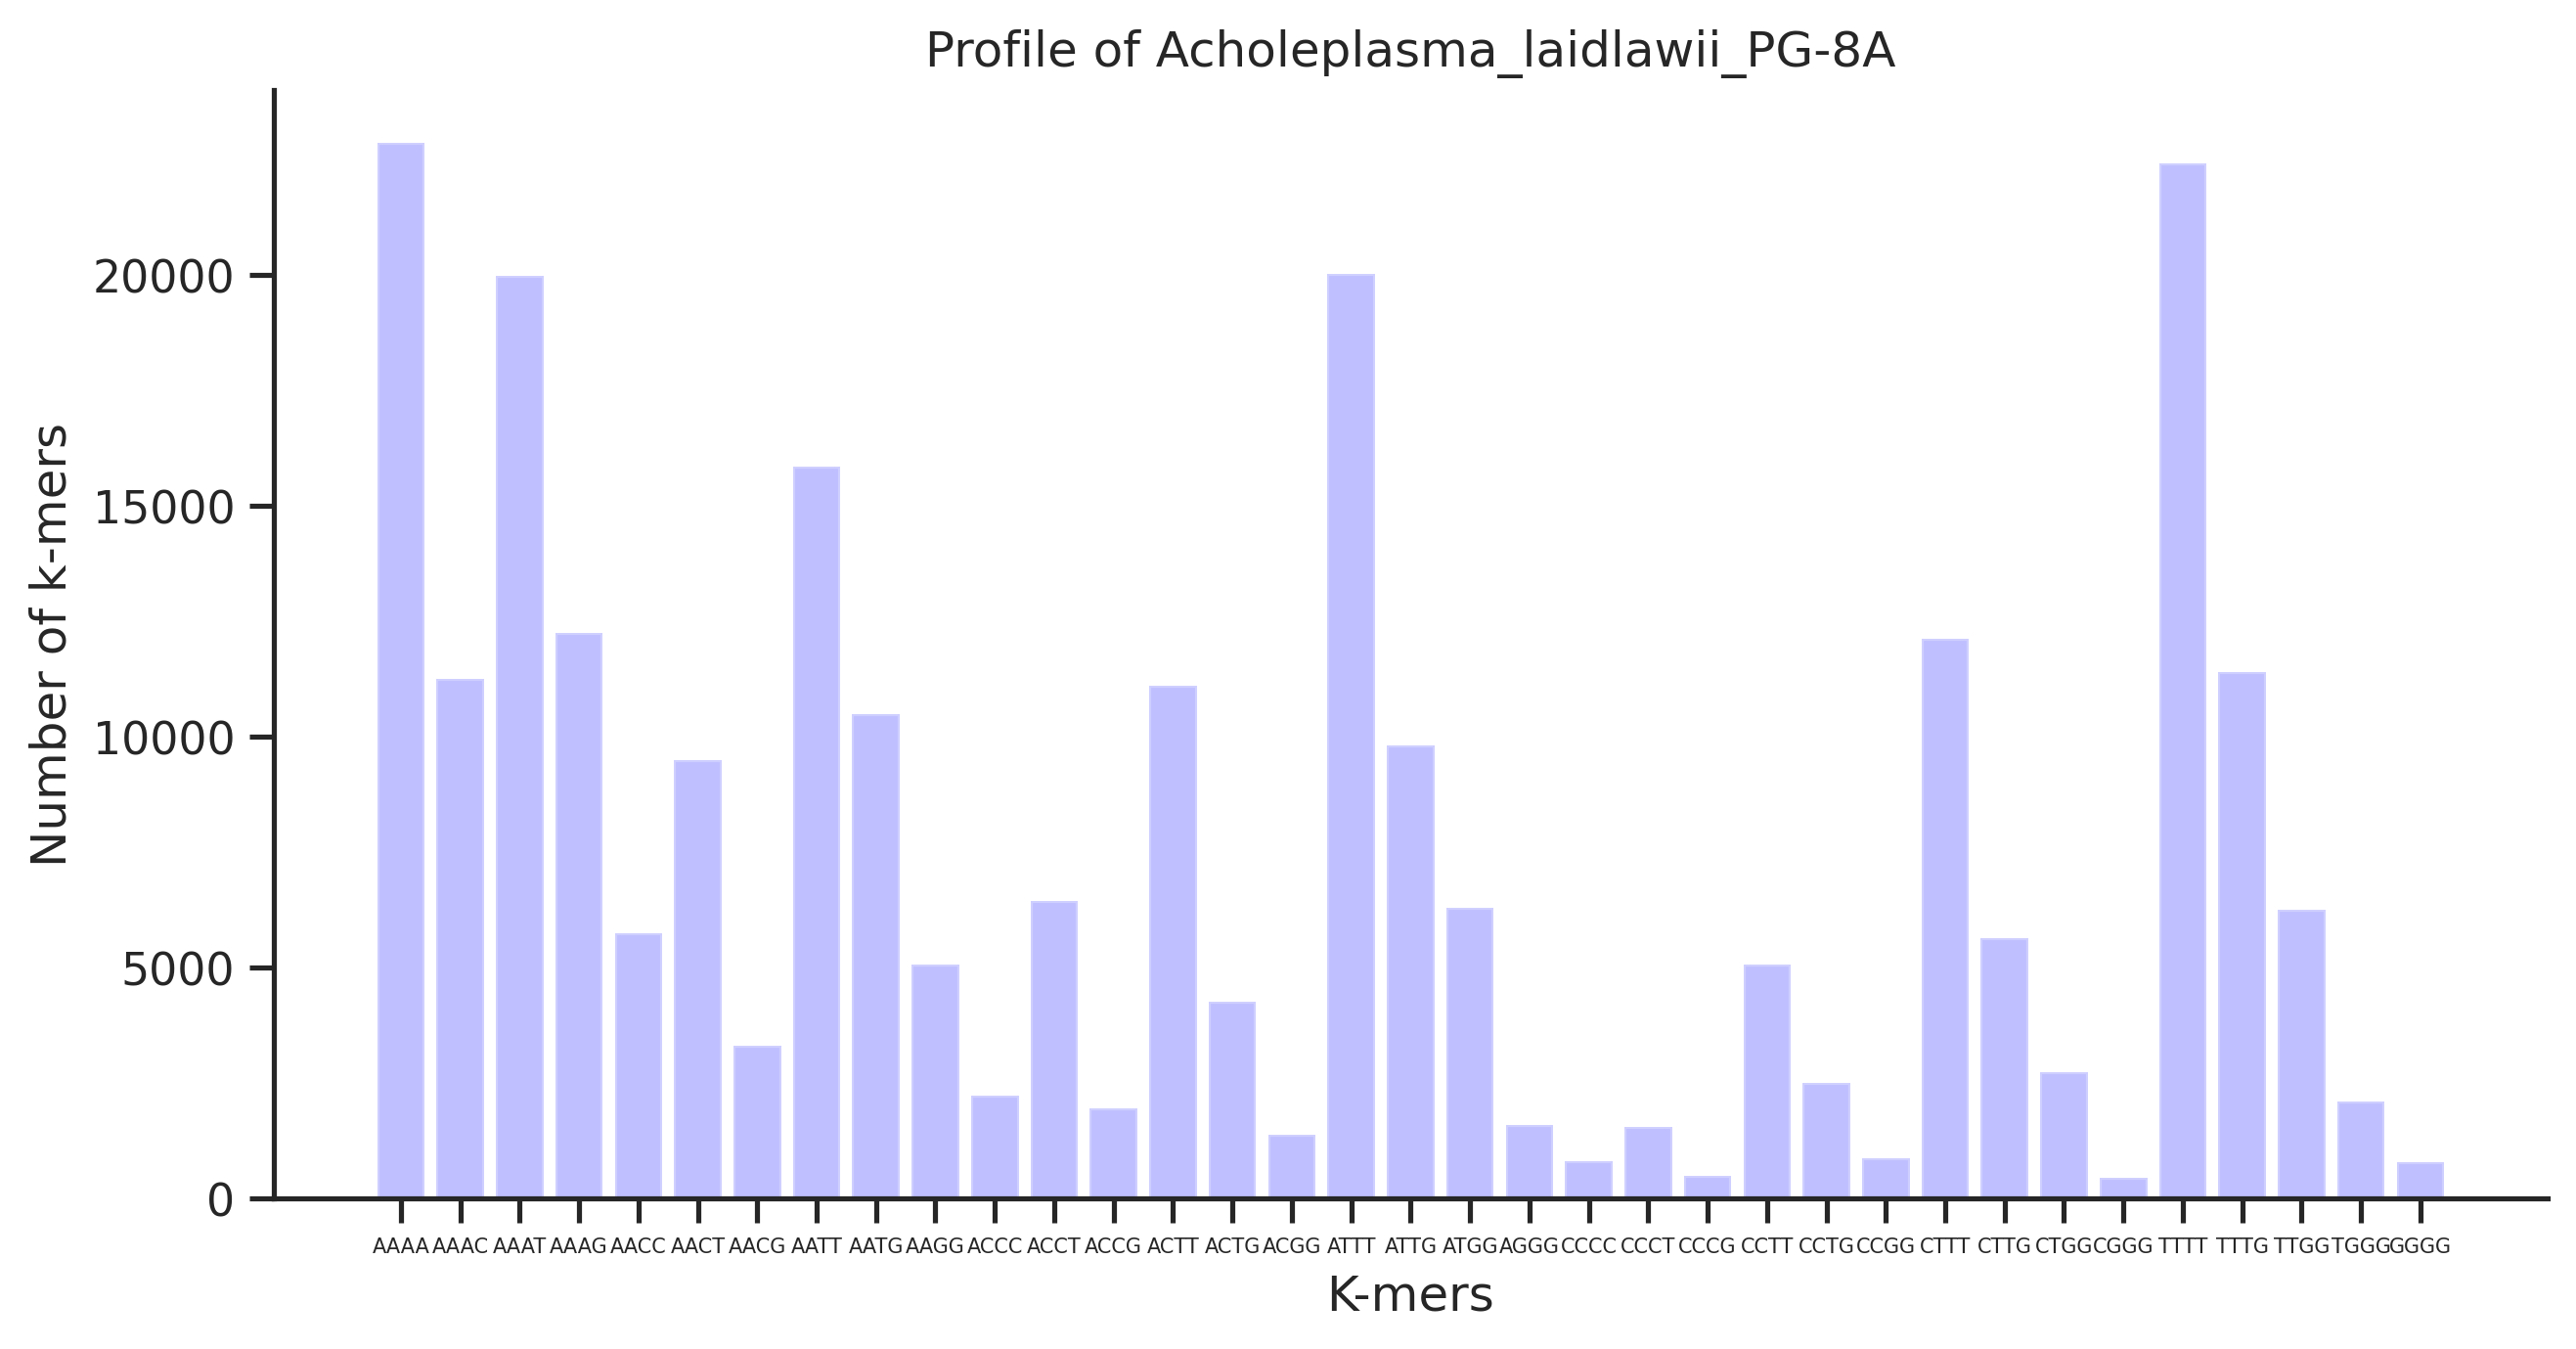

<Figure size 432x288 with 0 Axes>

In [10]:
labels, scores = kmers_count(bacteriaGenoms[0][1], 4)
labels, scores = cleaned_profile(labels, scores)
profile_plot(labels, 
             scores, 
             "Profile of "+bacteriaGenoms[0][0], 
             "K-mers", 
             "Number of k-mers")

### Exemple sur le premier archée de la liste

Counting k-mers.. : 100%|#########| 1669696/1669696 [00:06<00:00, 274433.25it/s]


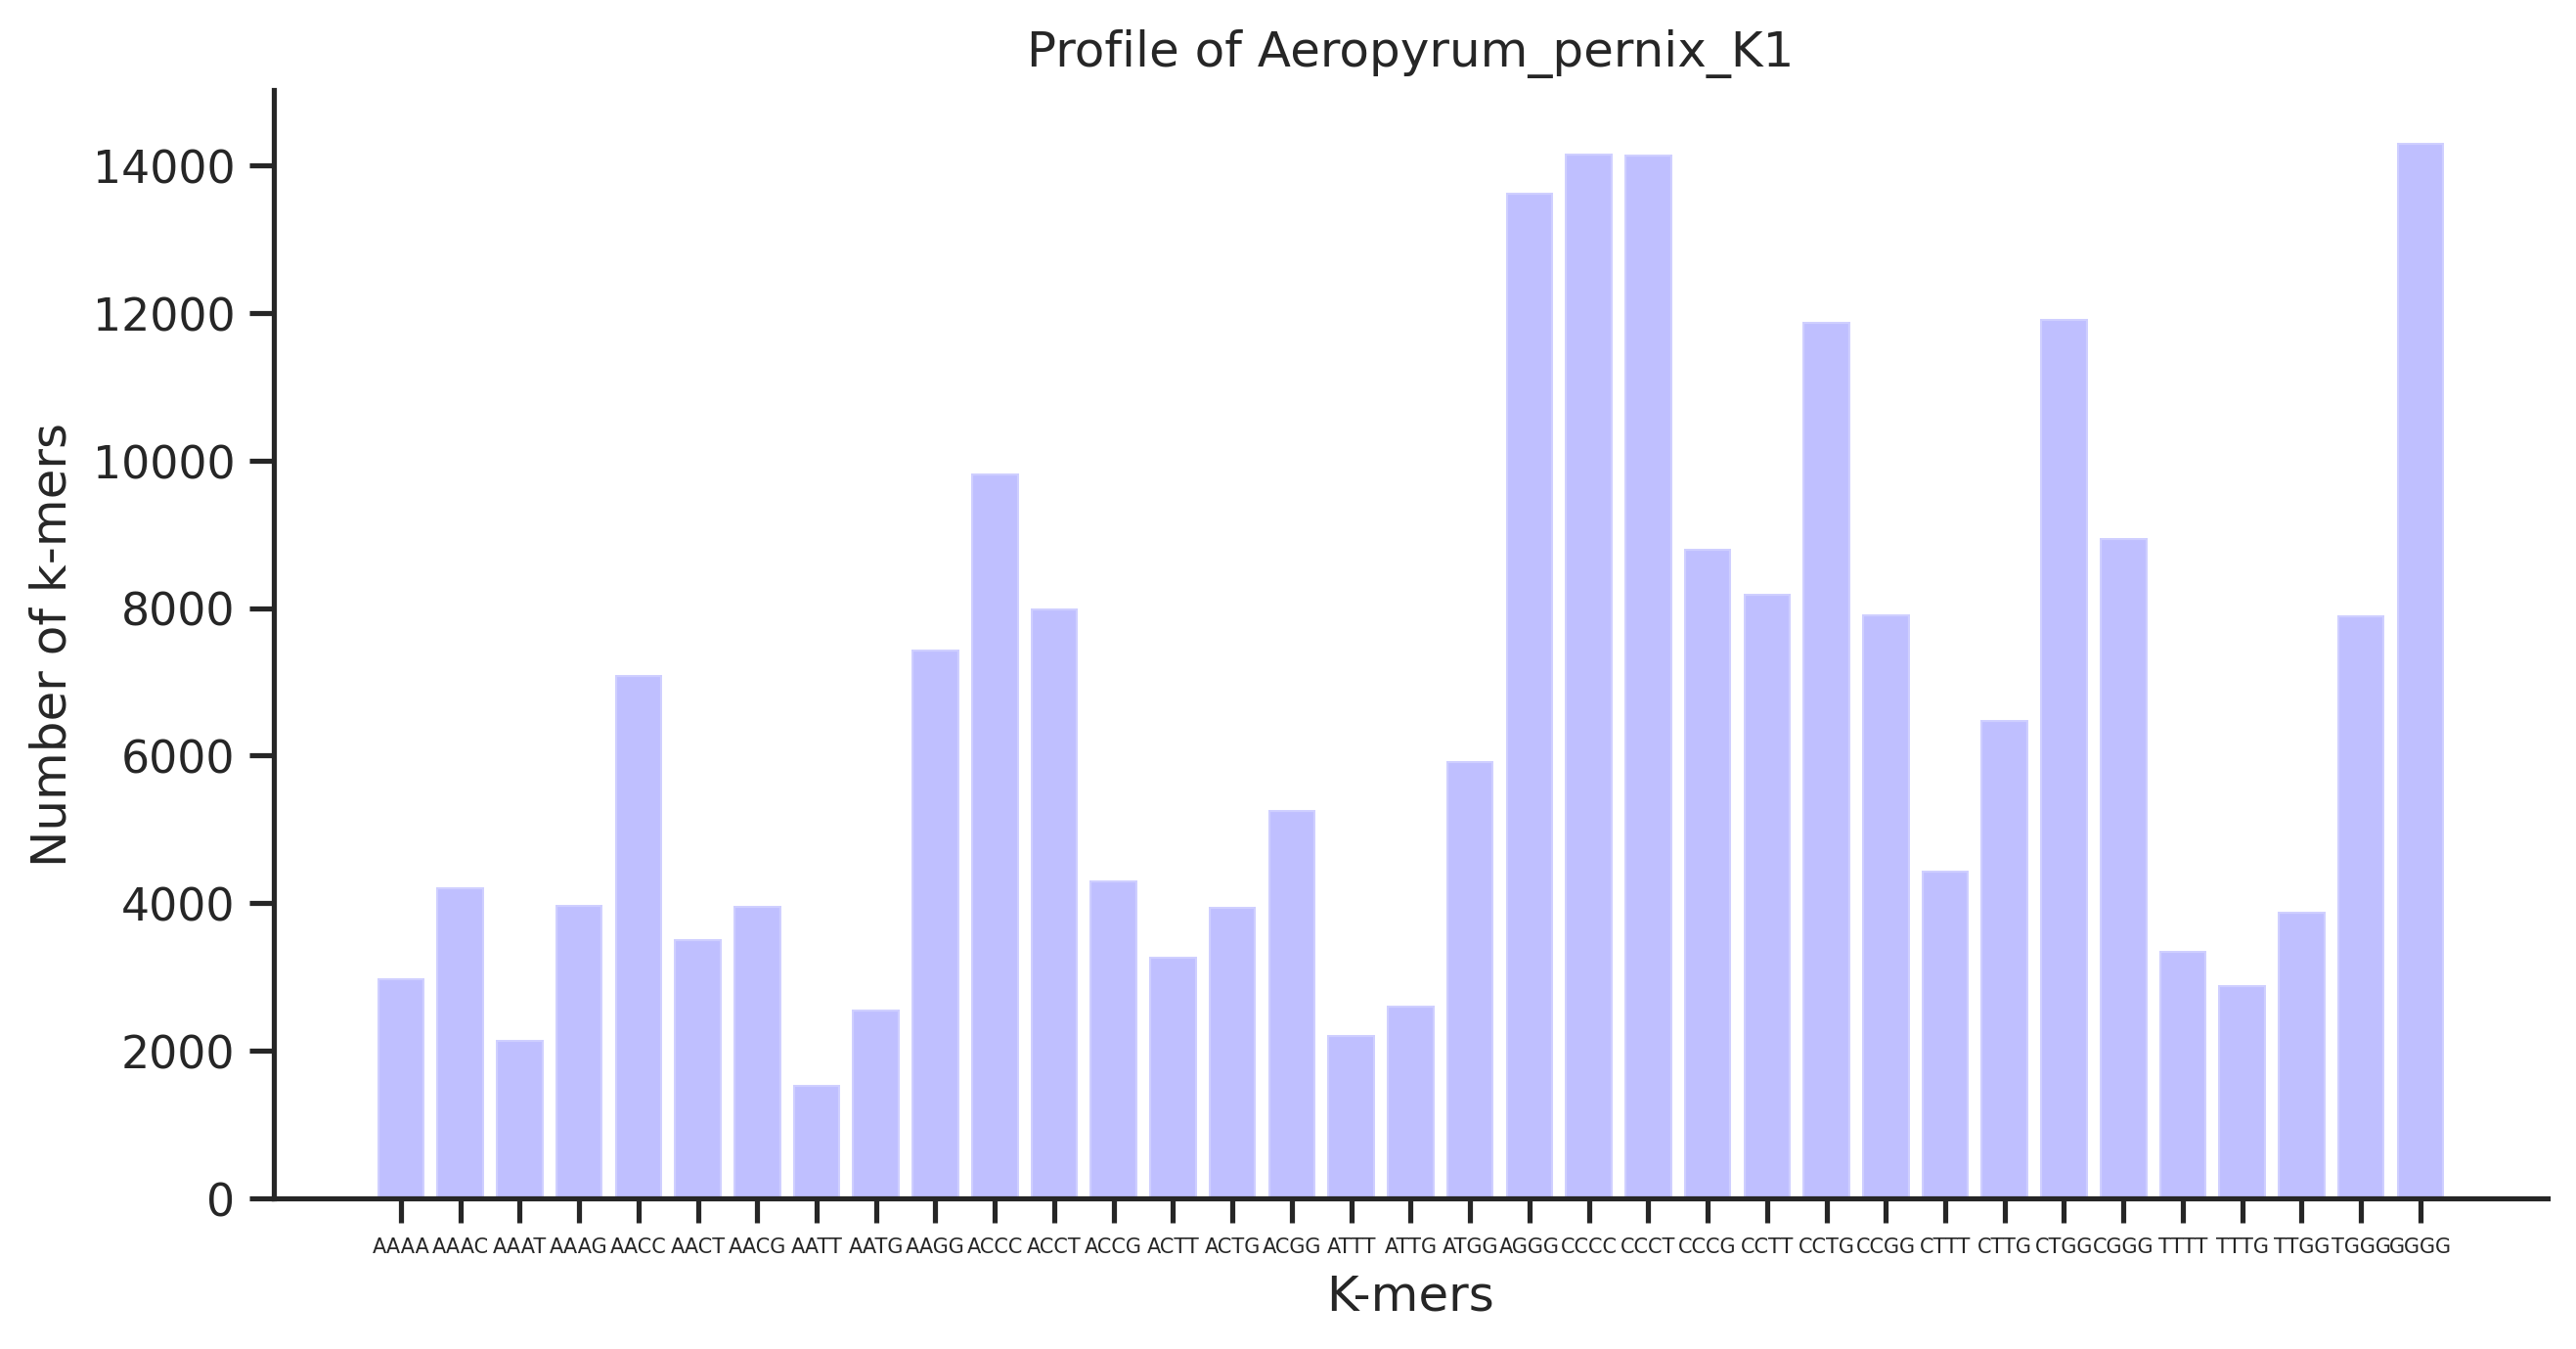

<Figure size 432x288 with 0 Axes>

In [11]:
labels, scores = kmers_count(archaeaGenoms[0][1], 4)
labels, scores = cleaned_profile(labels, scores)
profile_plot(labels, 
             scores, 
             "Profile of "+archaeaGenoms[0][0], 
             "K-mers", 
             "Number of k-mers")

------------------------------------------------------------------

# Partie 3 : Exploitation des profils

## Piste d'exploitation 1 : Comparaison des profils

1. La signature génomique est-elle vraiment constante le long d’un génome, comme prétendu ?
2. Comment quantifier cette variation ? Si c’est le cas, les transferts horizontaux récents dans un génome devraient avoir une composition très différente de la signature moyenne. 
3. Peut-on détecter des gènes candidats à un transfert récent par cette approche ?

On étudie les 5 premières bactéries et les 5 premiers archées de nos données.

On implémente une fonction `kmers_sweep` découpant le génome en morceaux de la taille `window = 100000` et calculant les profils de tous les morceaux du génome.

In [10]:
def kmers_sweep(genomTuple, k=2, window=100000, printer=True):
    scoresList = []
    if printer:
        bar = tqdm(range(len(genomTuple[1])//window), ascii=True, desc="Sweeping k-mers.. ")
    else:
        bar = range(len(genomTuple[1])//window)
    for i in bar:
        labels, scores = kmers_count(genomTuple[1][i*window:(i+1)*window], 
                                     k, printer=False)
        scoresList.append(scores)
    return labels, scoresList

On implémente une fonction `distance_score` pour calculer un score de distance entre deux profils, ce score part de deux profiles normalisés sur lesquels on applique la `distance euclidienne` avec la méthode de `numpy` `linalg.norm`.

In [11]:
def distance_score(profile_1, profile_2):
    return np.linalg.norm((profile_1/np.sum(profile_1))-(profile_2/np.sum(profile_2)))

On implémente une fonction `distance_mean` qui calcule pour chaque morceau de génome, sa distance par rapport aux autres morceaux. On prend ensuite la moyenne de ces distances. Et on retourne l'ensemble des moyennes pour tous les morceaux.

In [12]:
def distance_mean(scoresList):
    results = []
    for i in range(len(scoresList)):
        for j in range(len(scoresList)):
            results.append([distance_score(scoresList[i], scoresList[j]), i, j])
    
    data_raw = pd.DataFrame(results, columns=["Distance", "First genom", "Second genom"])
    data = data_raw[(data_raw != 0).all(1)]

    meanDistances = []
    for i in range(1, len(scoresList)):
        meanDistances.append(data.loc[data["First genom"]== i].mean()[0])
    return meanDistances

On implémente une fonction `distance_plot` pour faciliter l'affichage des courbes représentant les variations de profils au sein d'un génome. La valeur `fontsize` doit être modifié par rapport au nombre de combinaisons lorsqu'on modifie `k`.

In [13]:
def distance_plot(labels, scores, namefig, xlabel, ylabel, fontsize=5):
    custom_params = {"axes.spines.right": False, 
                     "axes.spines.top": False}
    sns.set_theme(style="ticks", rc=custom_params)
    plt.figure(figsize=(10,5))
    plt.bar(labels, scores, color="blue", alpha=0.25)
    plt.xticks(fontsize=fontsize)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(namefig)
    plt.gcf().set_dpi(300)
    plt.show()
    plt.clf()

### Etude sur les 4 bactéries

Bacterias studied : 

Akkermansia_muciniphila_ATCC_BAA-835


Sweeping k-mers.. : 100%|#######################| 26/26 [00:09<00:00,  2.87it/s]


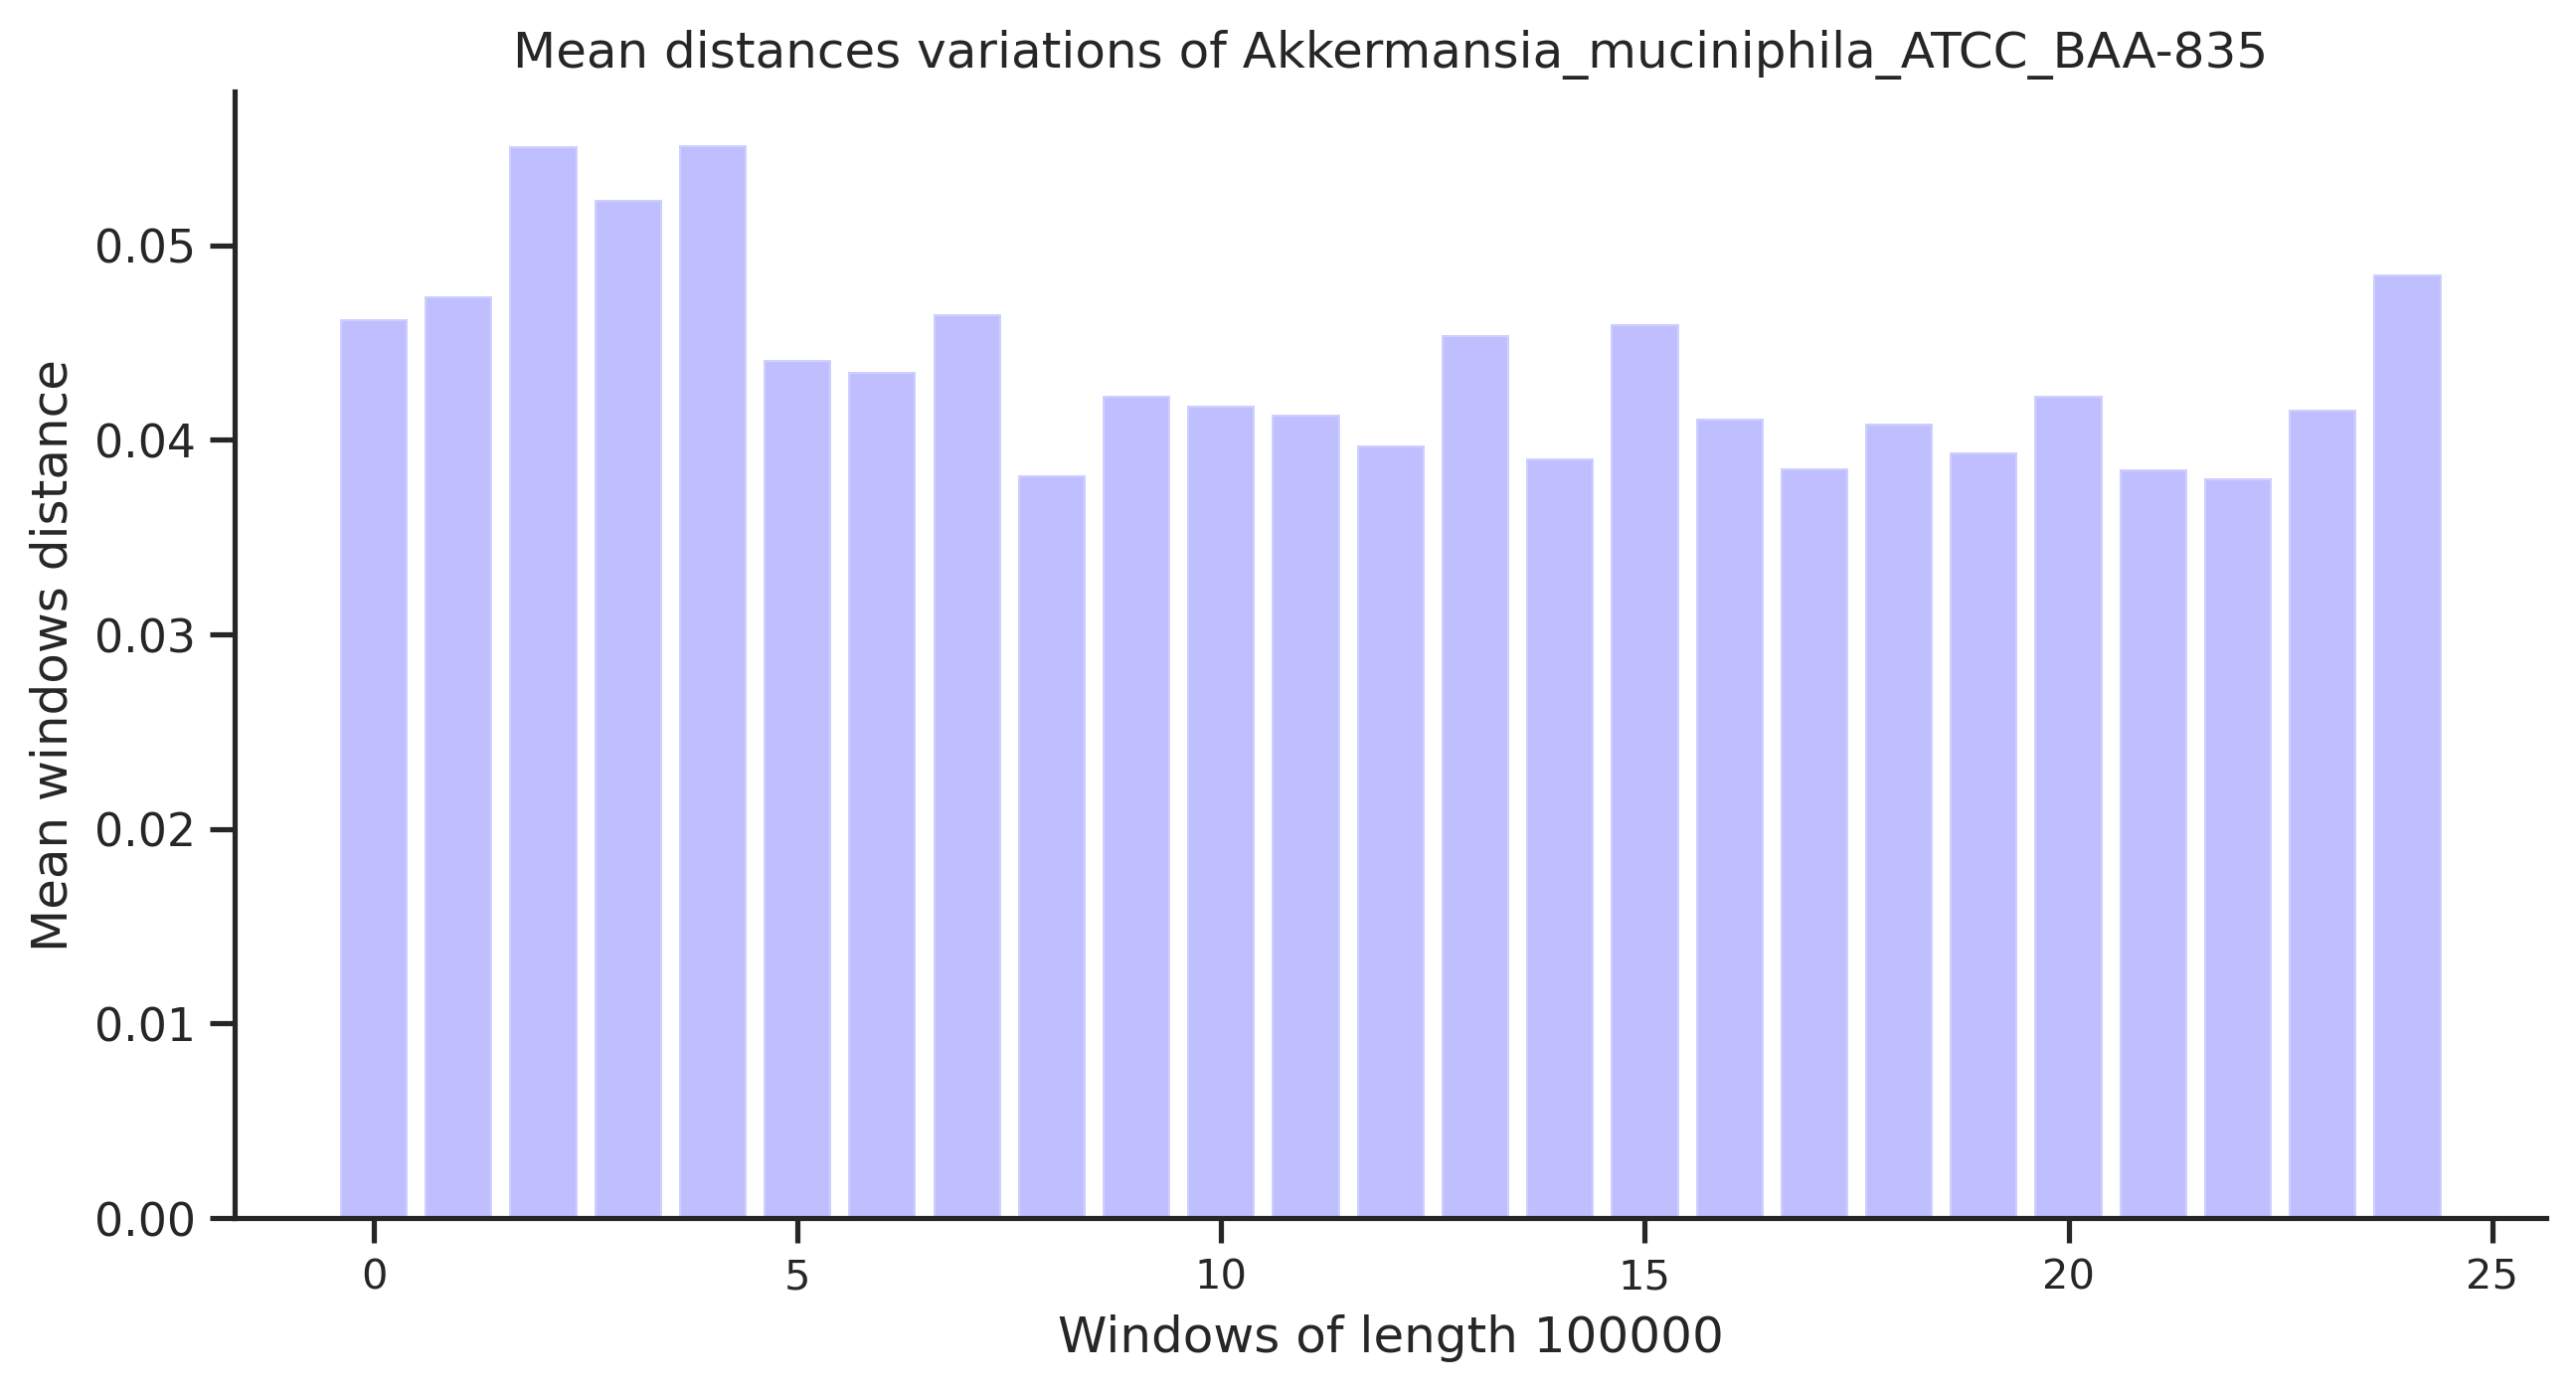

Corynebacterium_glutamicum_ATCC_13032


Sweeping k-mers.. : 100%|#######################| 32/32 [00:11<00:00,  2.81it/s]


<Figure size 432x288 with 0 Axes>

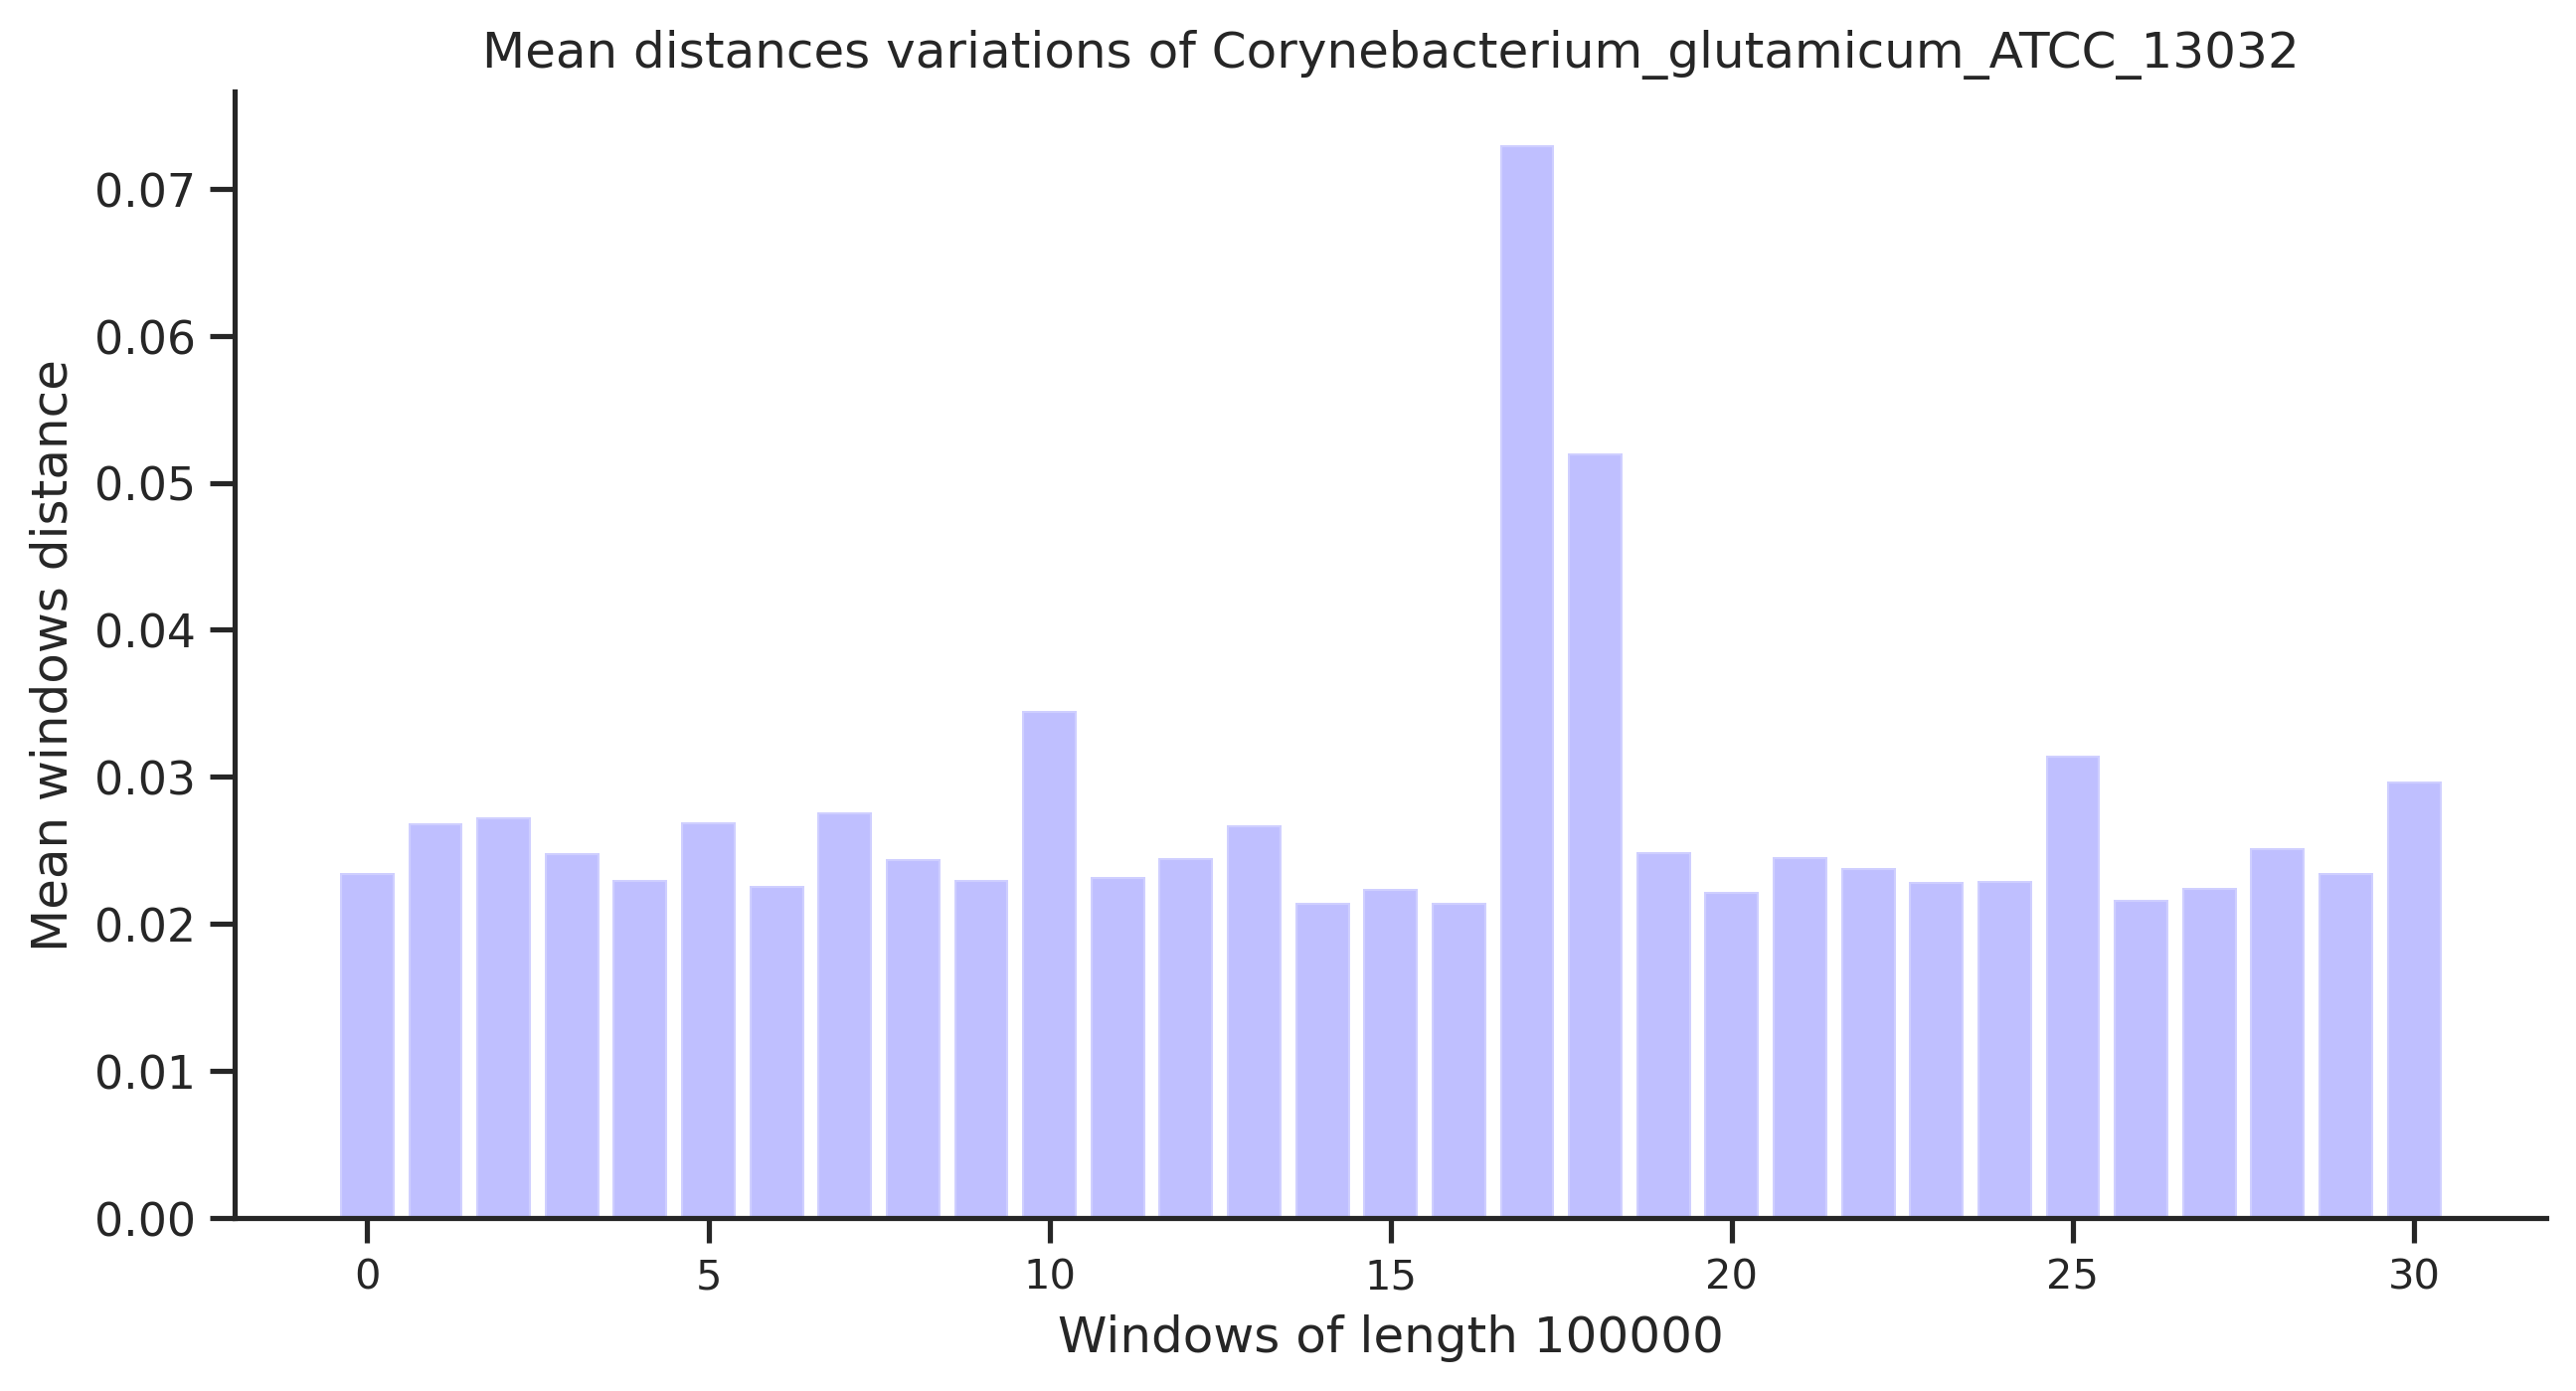

Cupriavidus_taiwanensis_isolate_Cupriavidus_taiwanensis_STM_6041_plasmid_I


Sweeping k-mers.. : 100%|#######################| 68/68 [00:24<00:00,  2.81it/s]


<Figure size 432x288 with 0 Axes>

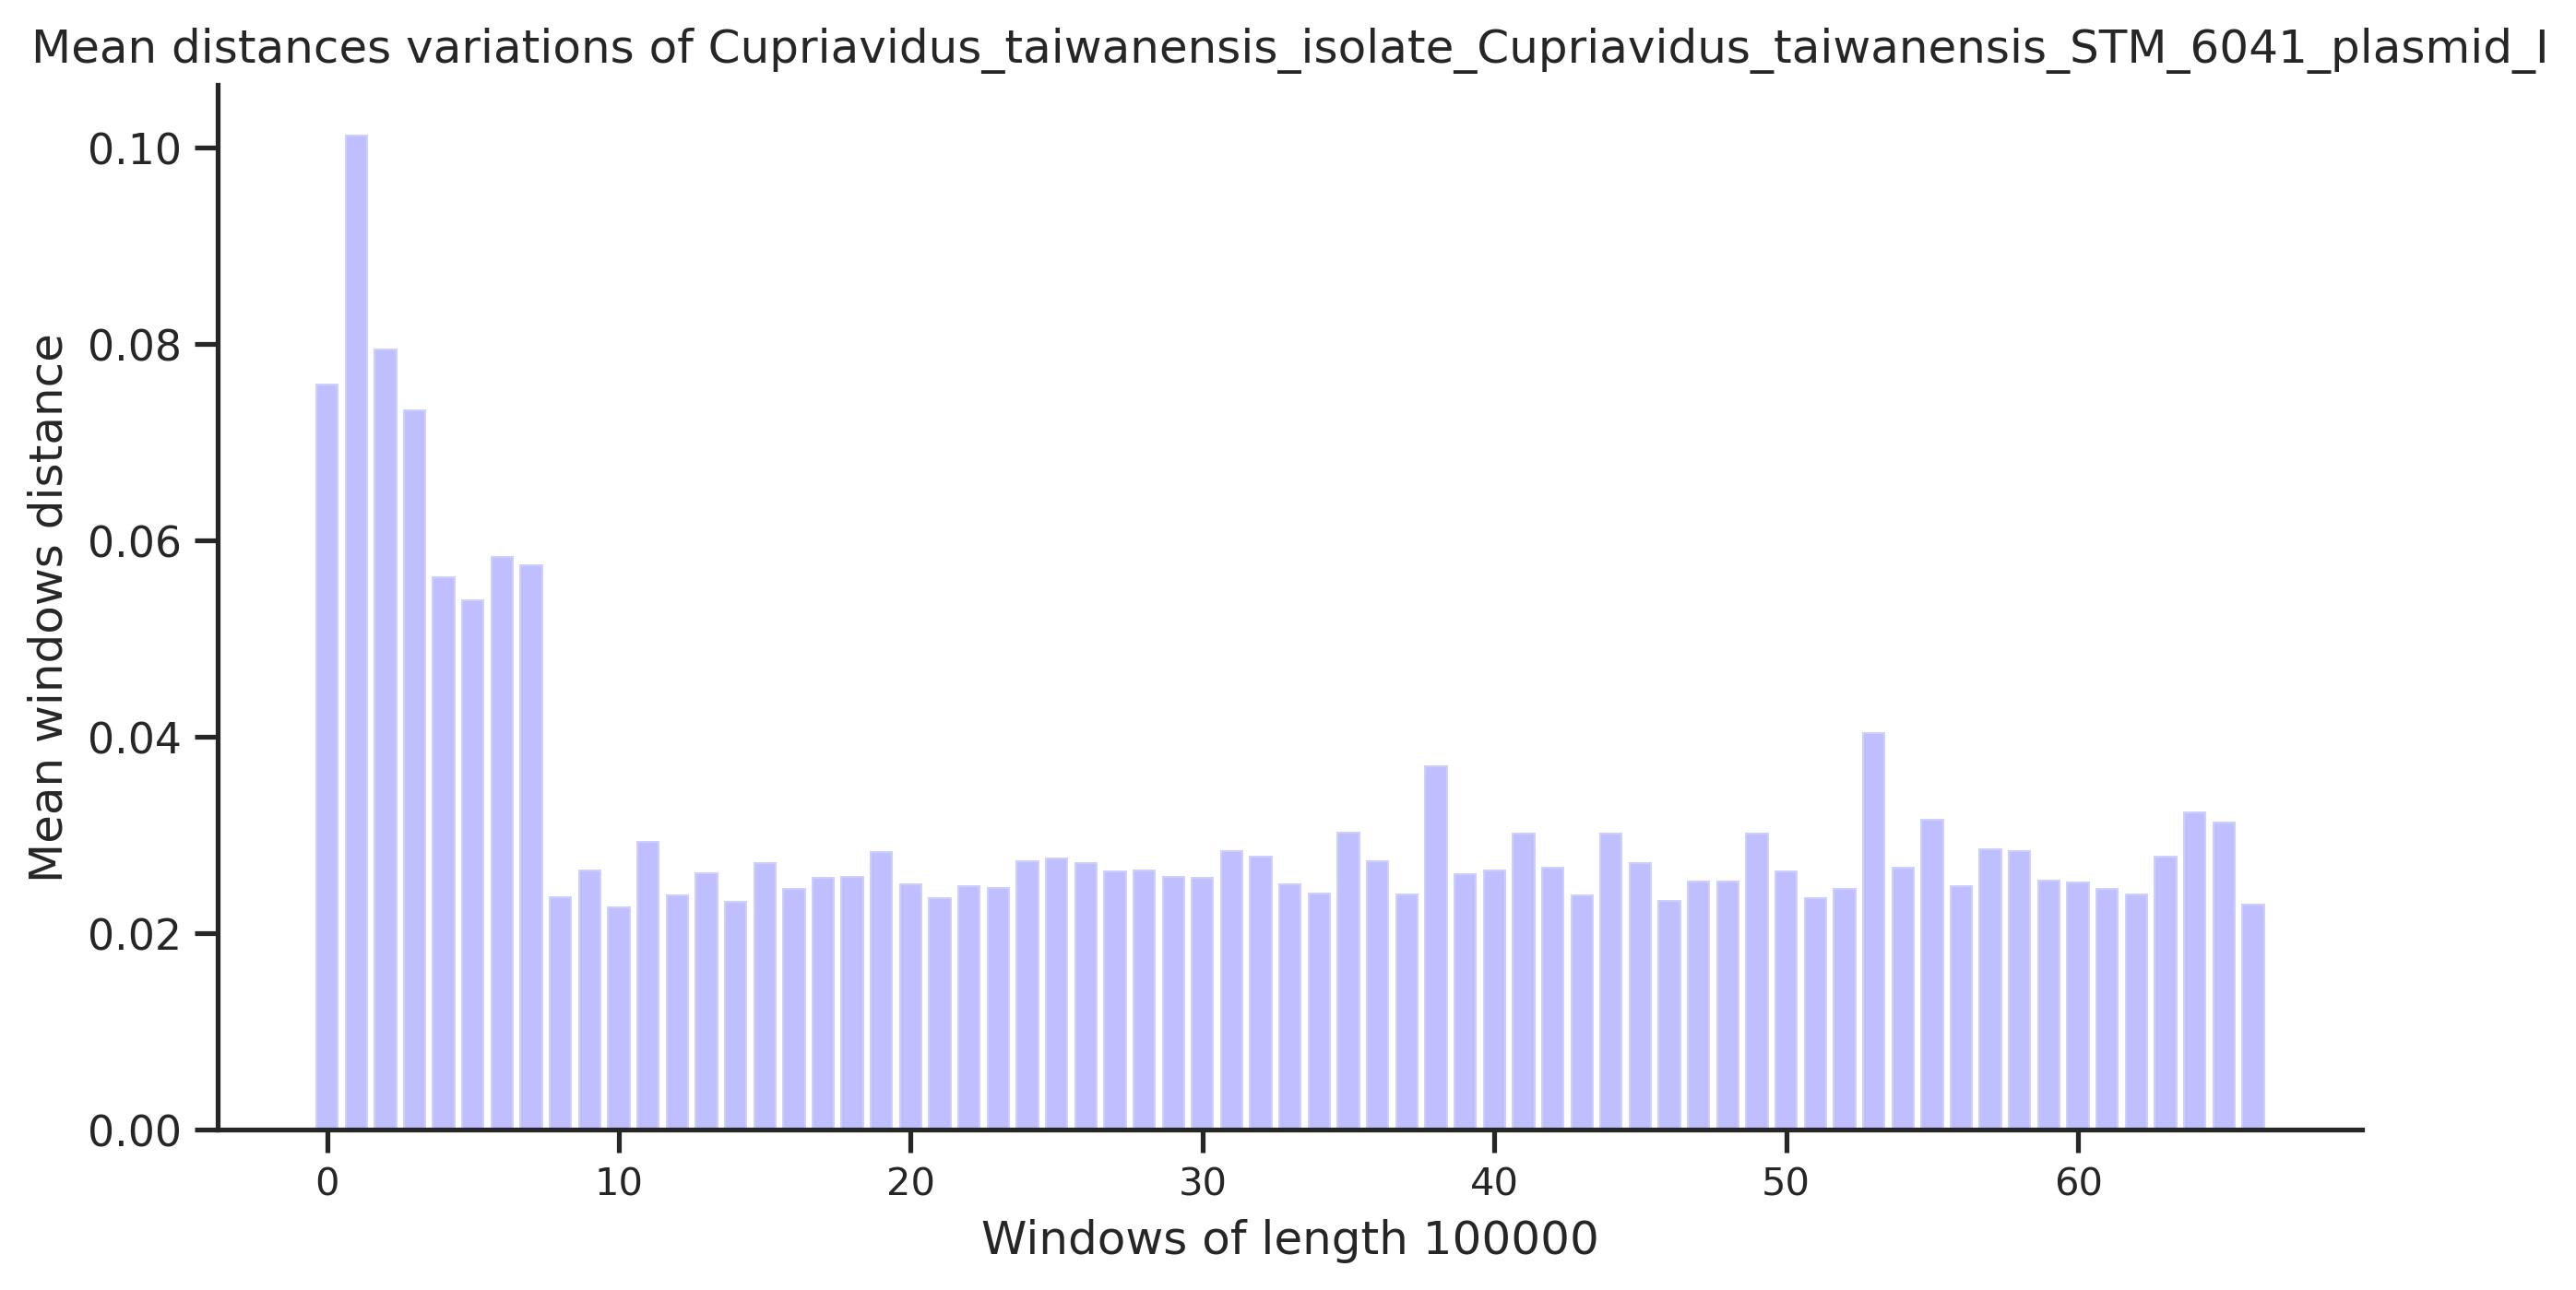

Cupriavidus_taiwanensis_isolate_Cupriavidus_taiwanensis_STM_6083_


Sweeping k-mers.. : 100%|#######################| 73/73 [00:26<00:00,  2.80it/s]


<Figure size 432x288 with 0 Axes>

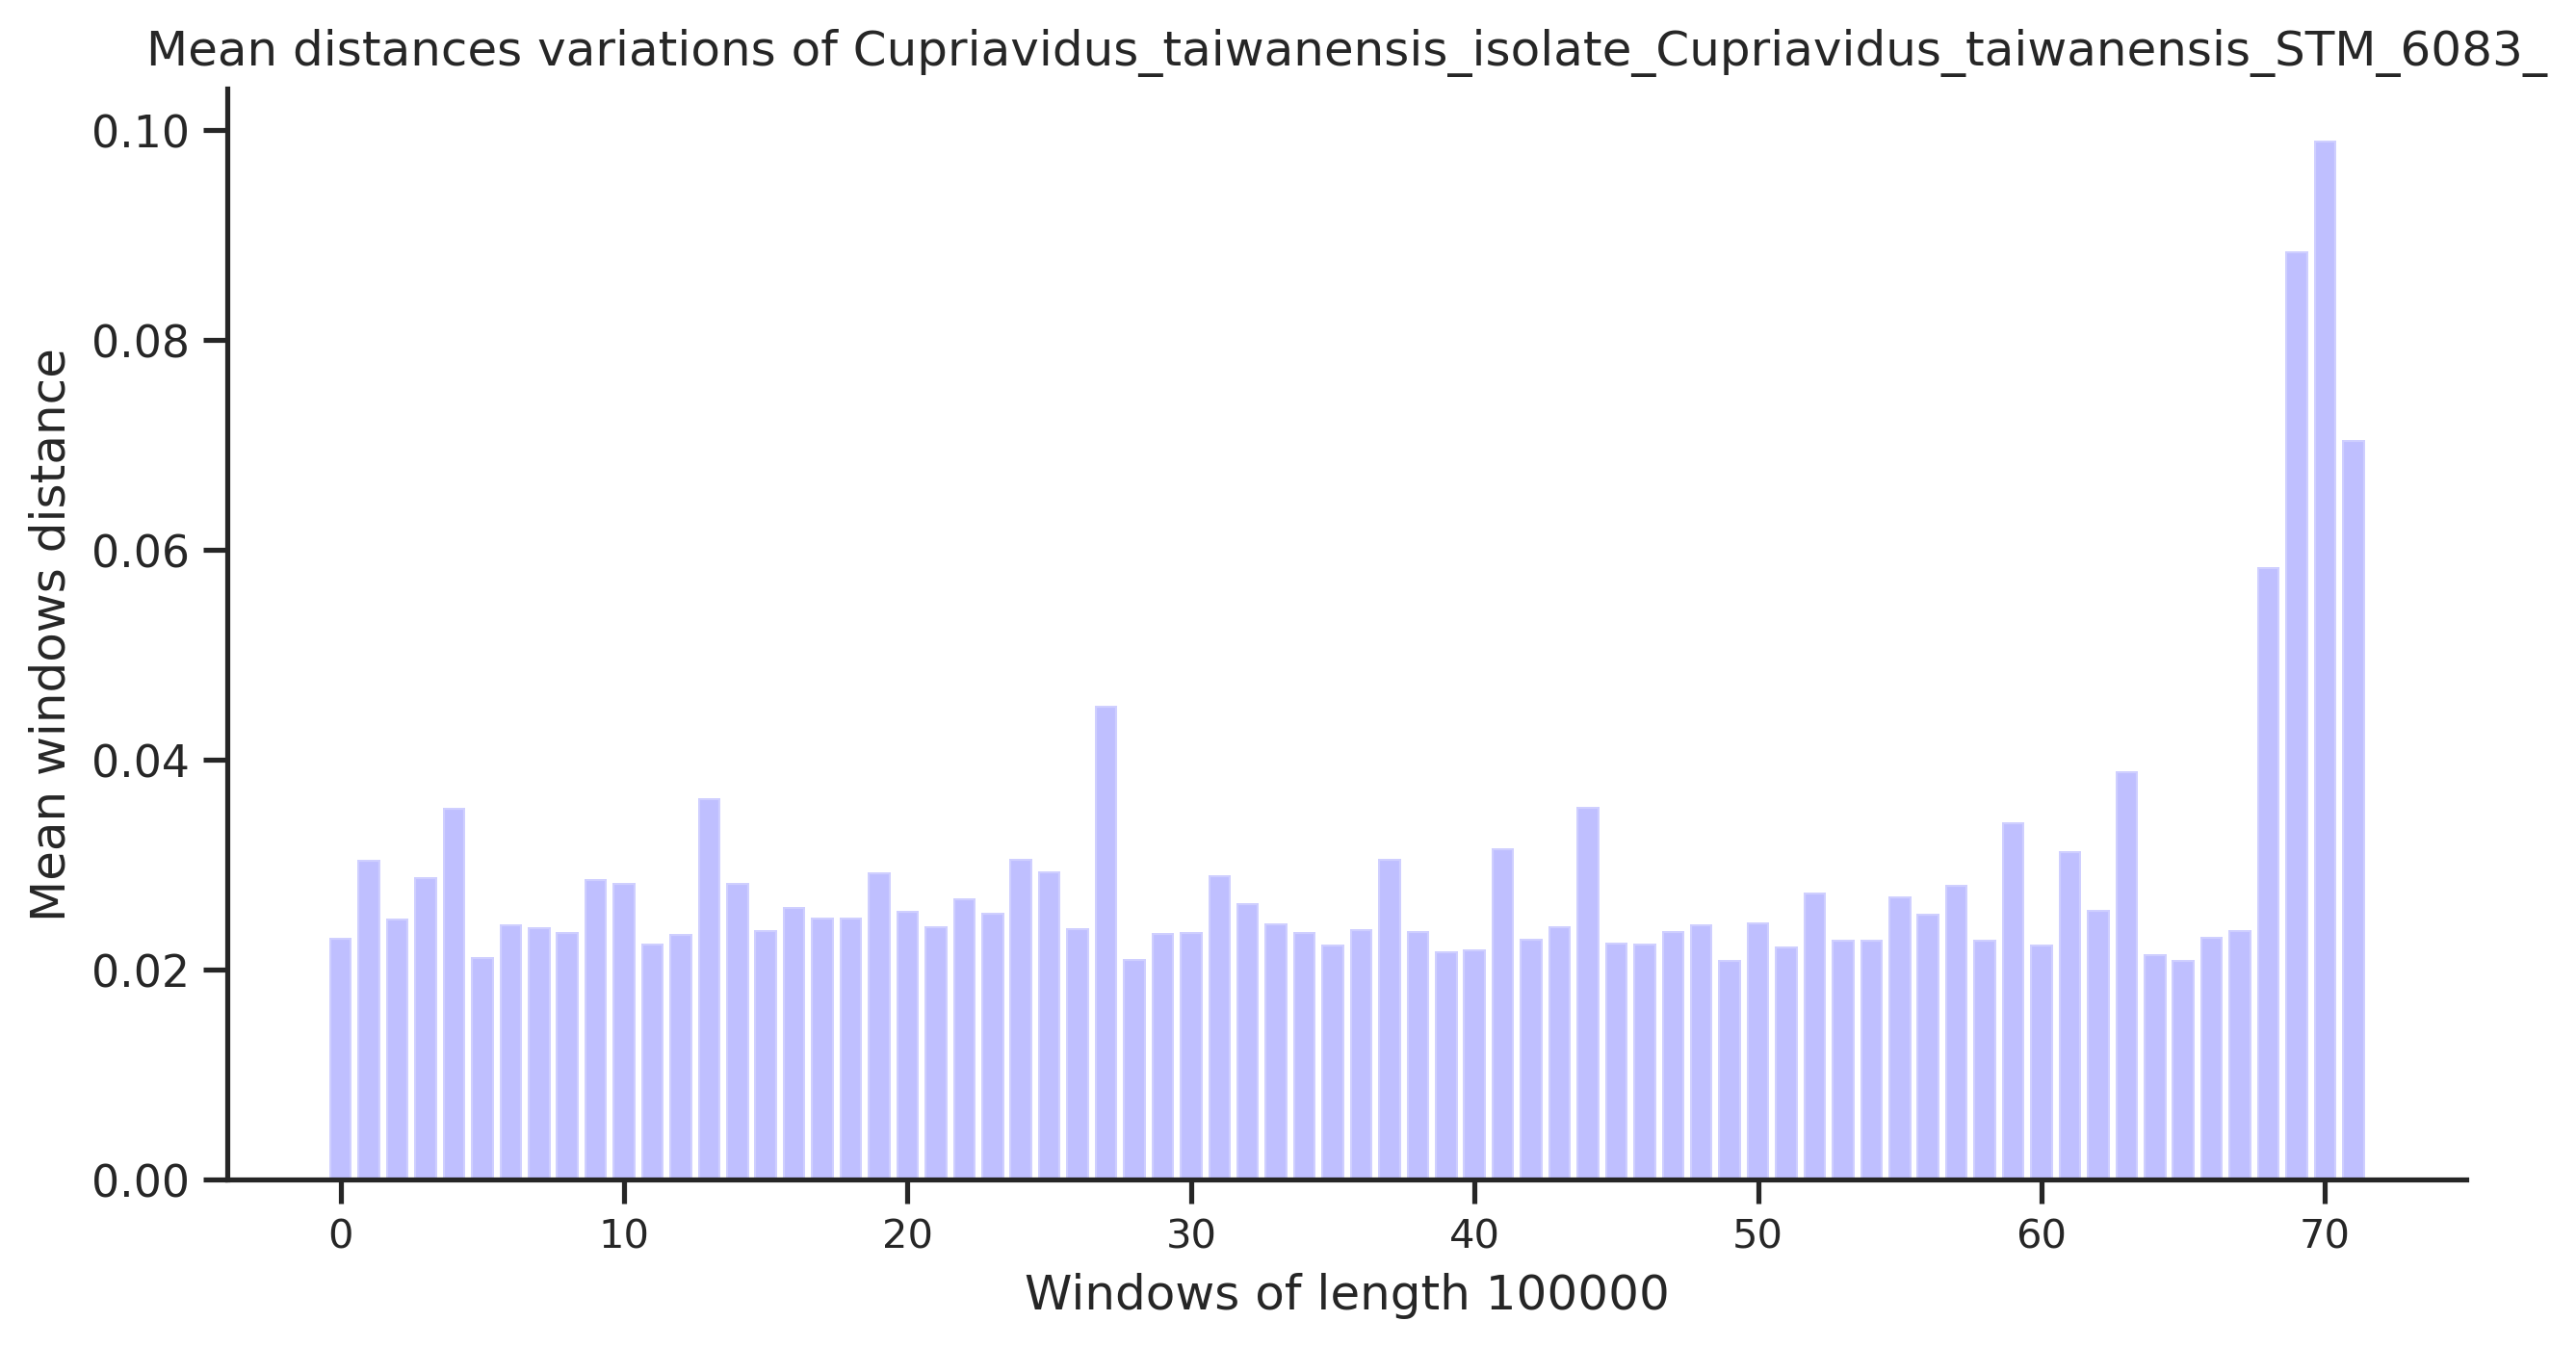

<Figure size 432x288 with 0 Axes>

In [94]:
bacteriaMeans = []
print("Bacterias studied : \n")
for index in [2, 20, 38, 42]:
    bacteria = bacteriaGenoms[index]
    print(bacteria[0])
    labels, scores = kmers_sweep(bacteria)
    distance_plot(range(len(distance_mean(scores))), 
                  distance_mean(scores), 
                  "Mean distances variations of "+bacteria[0], 
                  "Windows of length 100000", 
                  "Mean windows distance", 
                  10)
    i += 1

### Etude sur les 4 archées

Archaeas studied : 

Haloterrigena_turkmenica_DSM_55110


Sweeping k-mers.. : 100%|#######################| 54/54 [00:18<00:00,  2.87it/s]


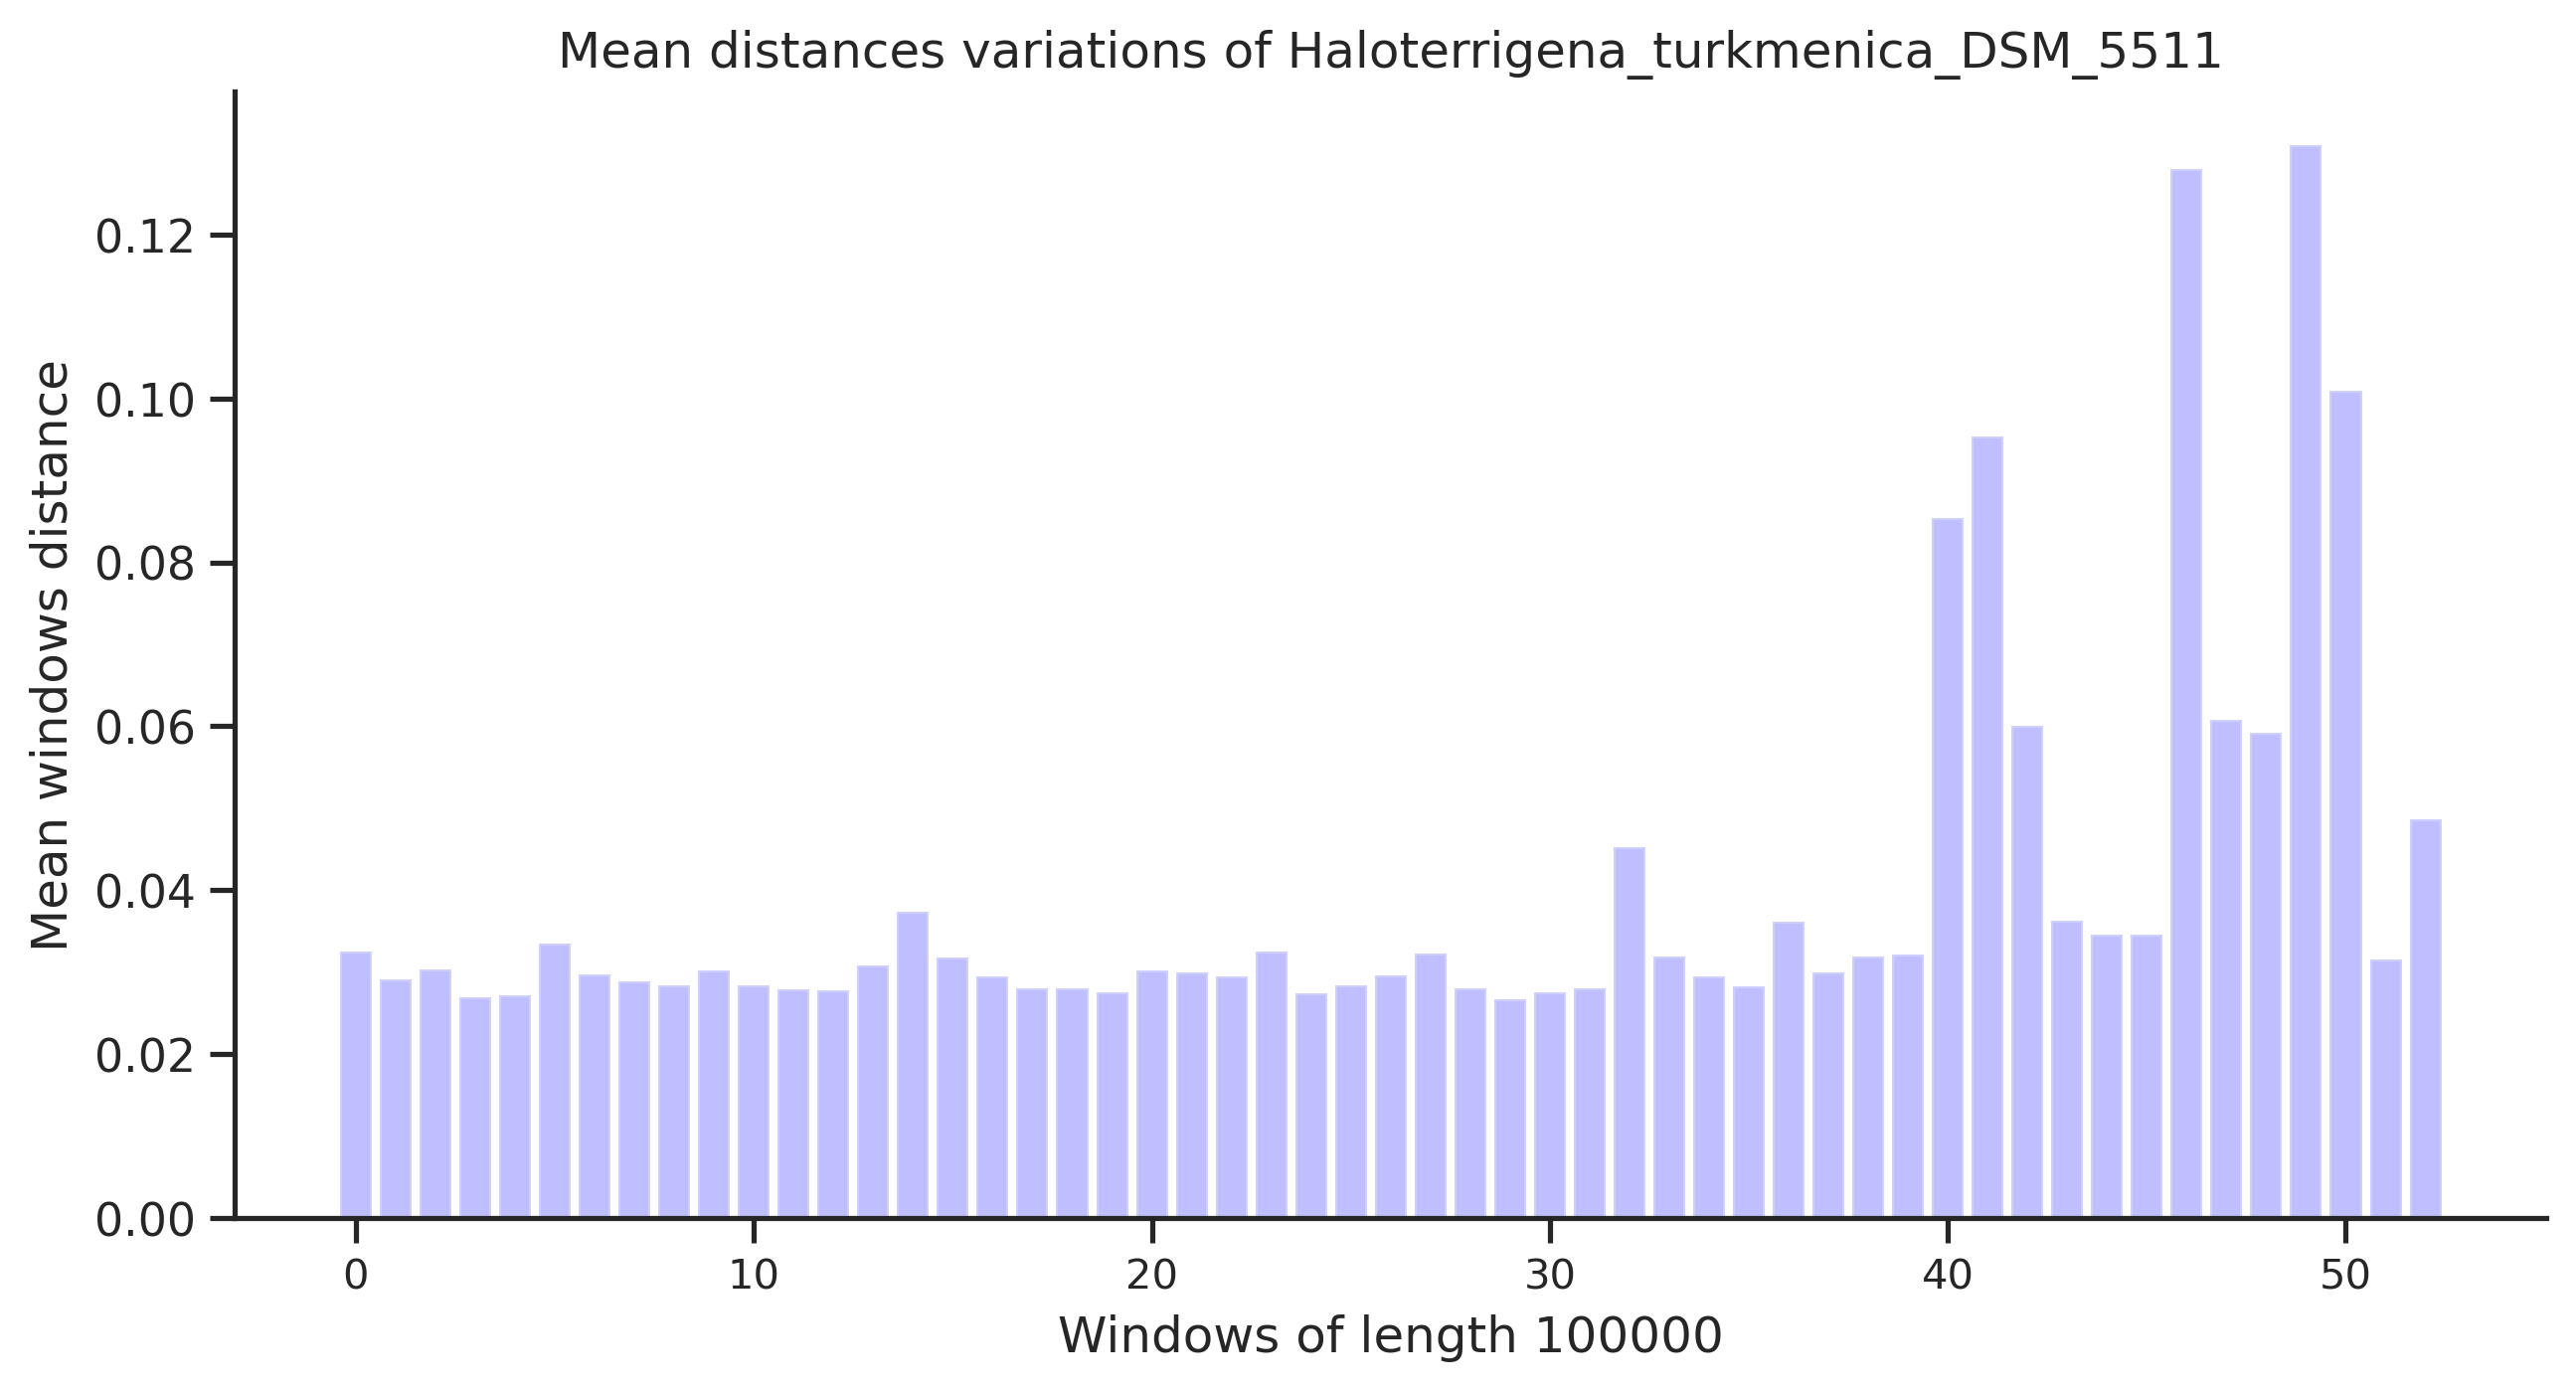

Metallosphaera_sedula_DSM_53481


Sweeping k-mers.. : 100%|#######################| 21/21 [00:07<00:00,  2.89it/s]


<Figure size 432x288 with 0 Axes>

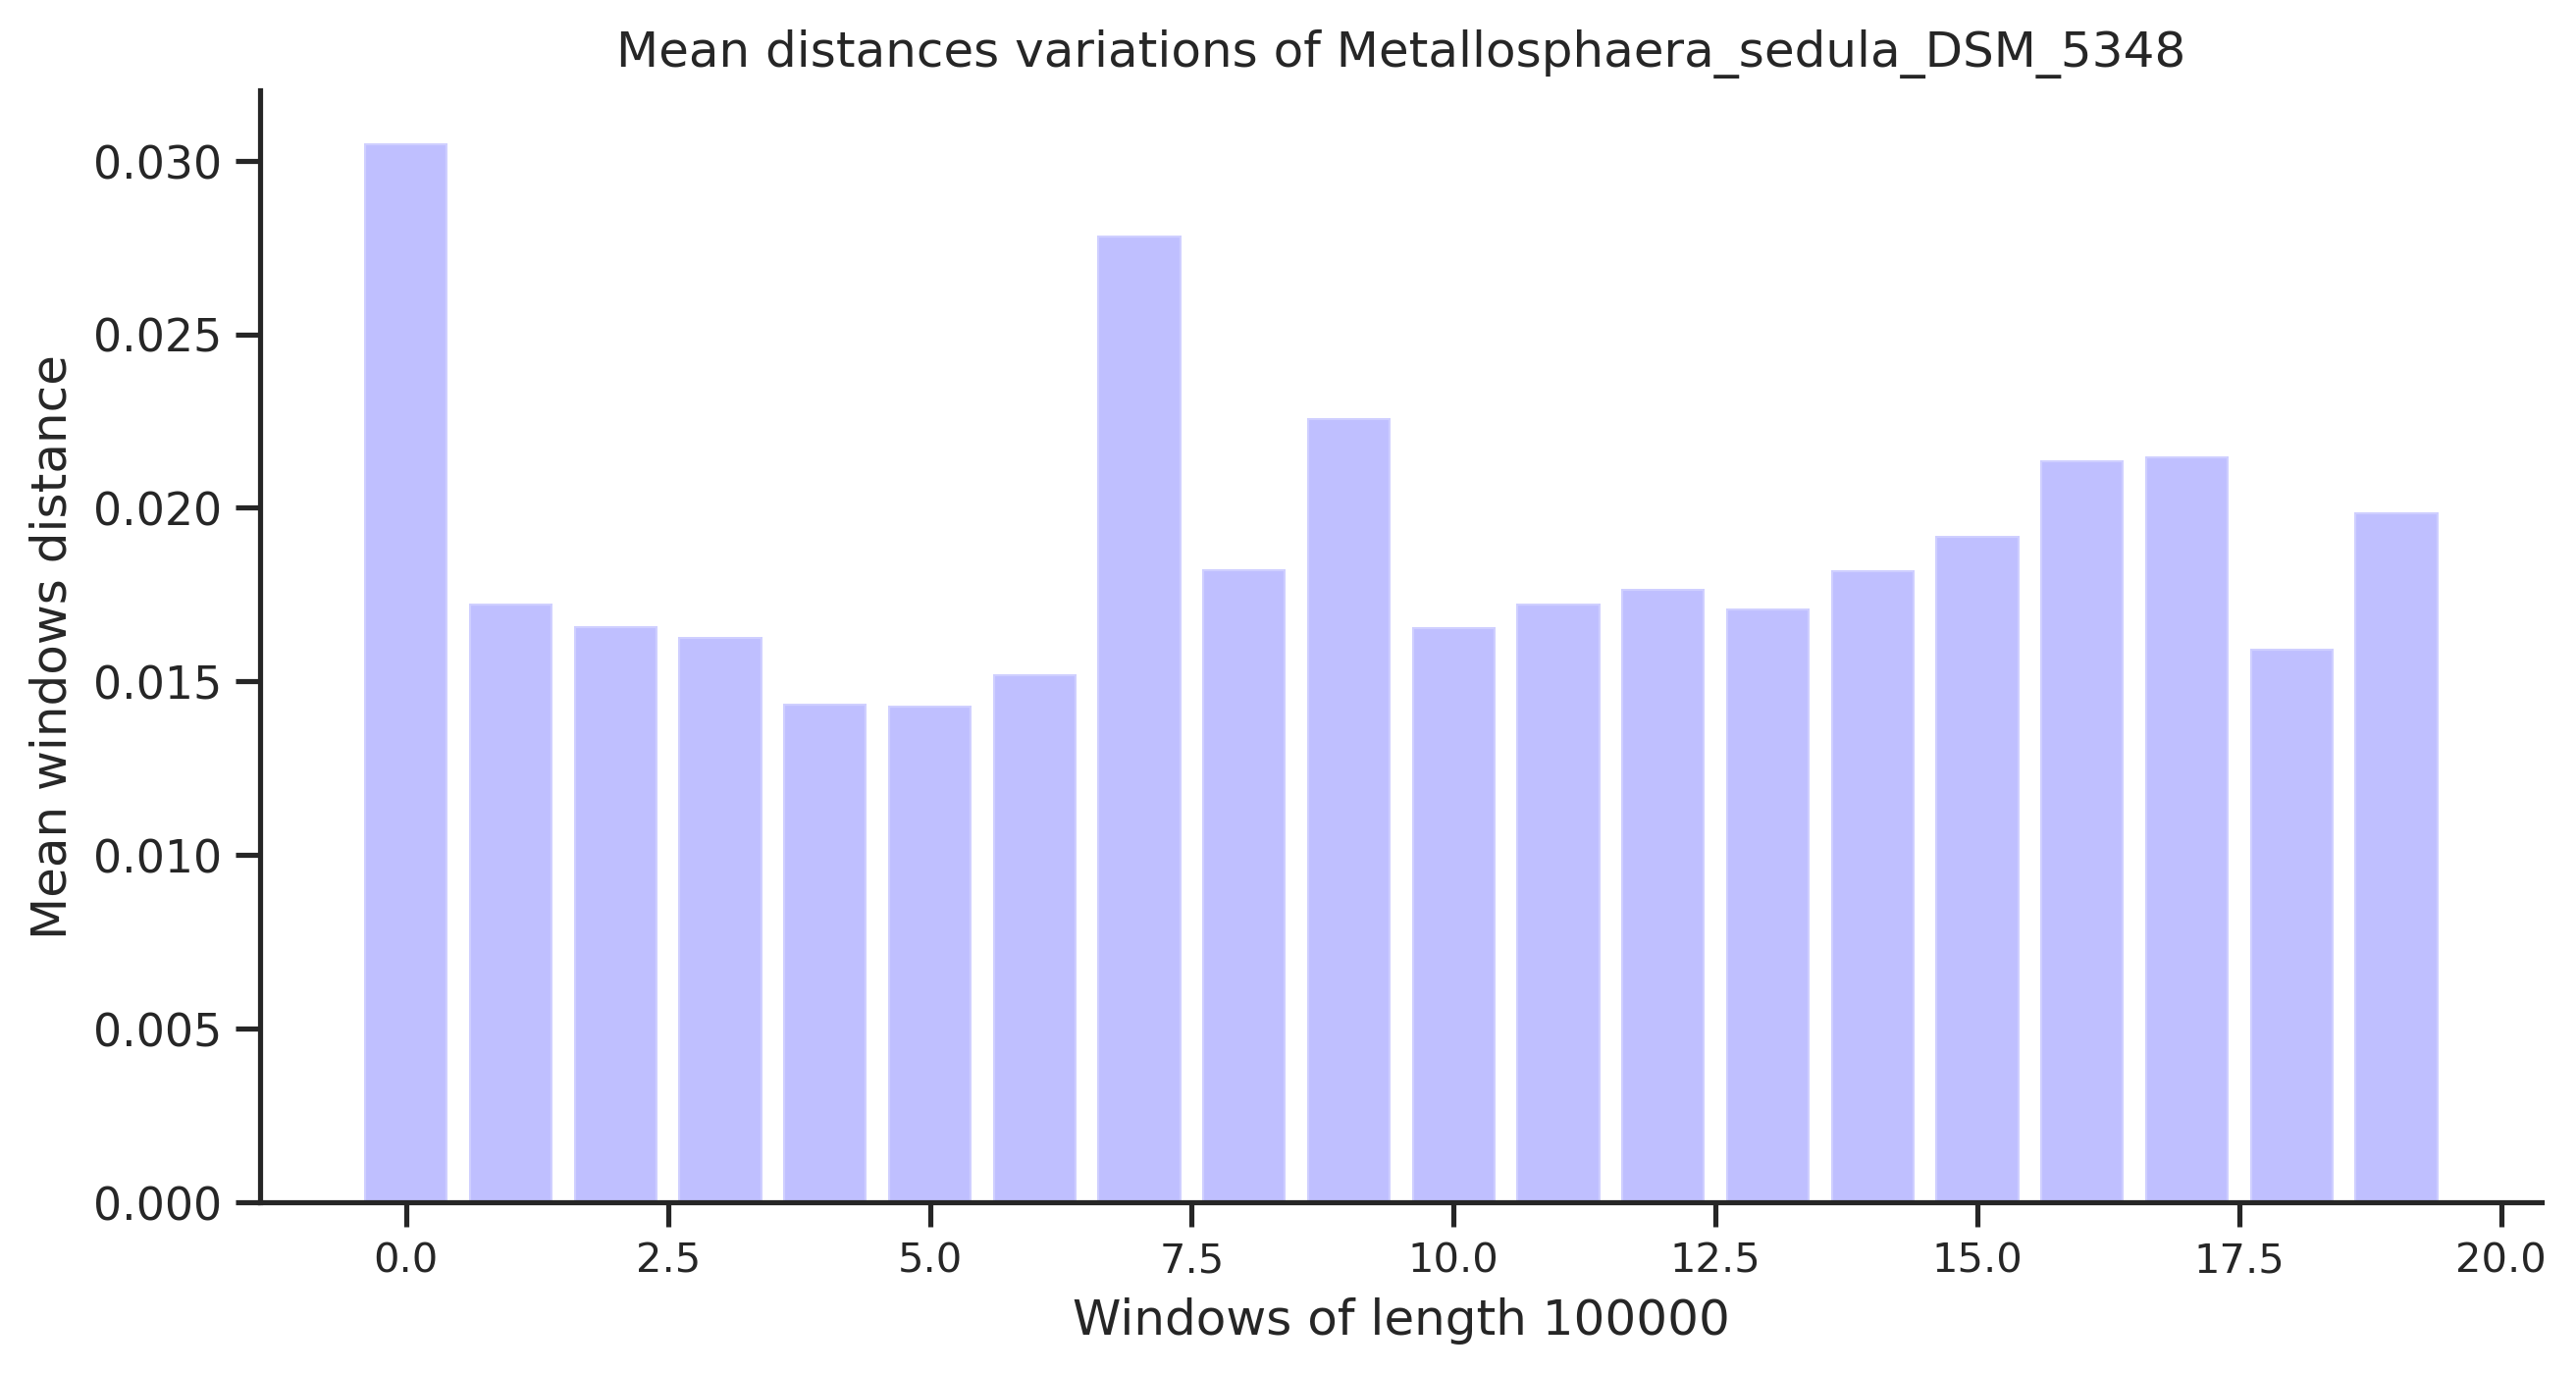

Methanocorpusculum_labreanum_Z2


Sweeping k-mers.. : 100%|#######################| 18/18 [00:06<00:00,  2.99it/s]


<Figure size 432x288 with 0 Axes>

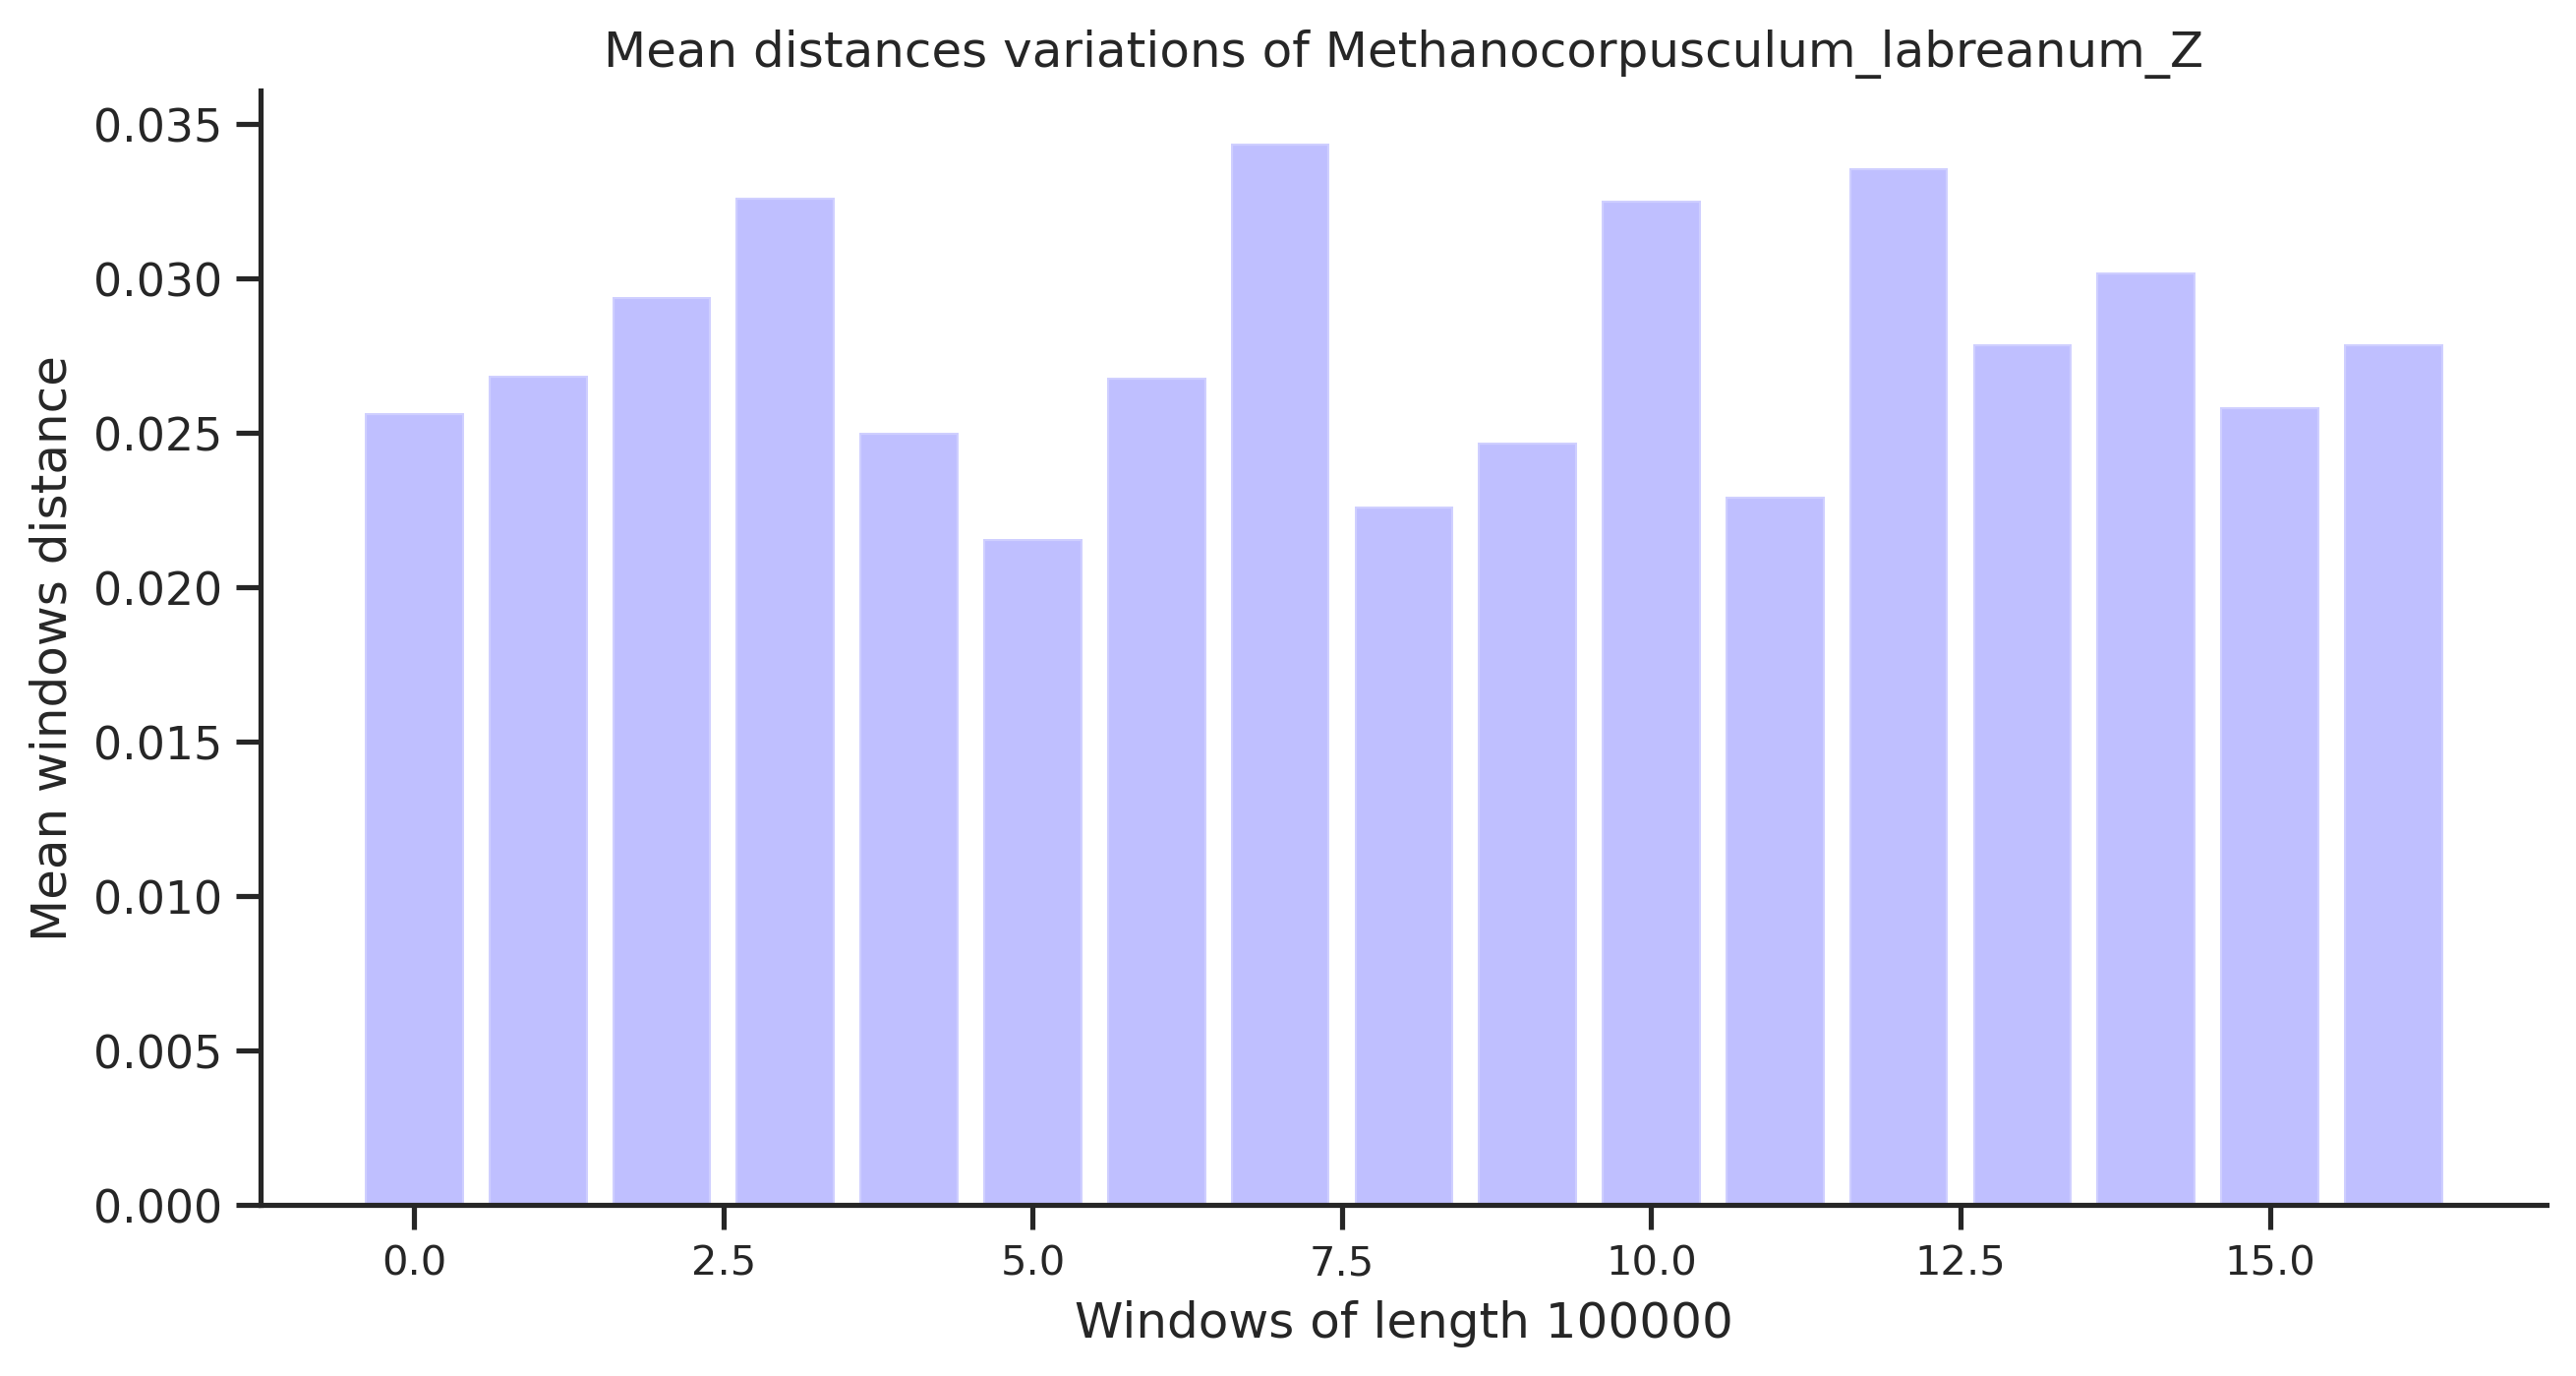

Thermoplasma_acidophilum_DSM_17283


Sweeping k-mers.. : 100%|#######################| 15/15 [00:05<00:00,  2.84it/s]


<Figure size 432x288 with 0 Axes>

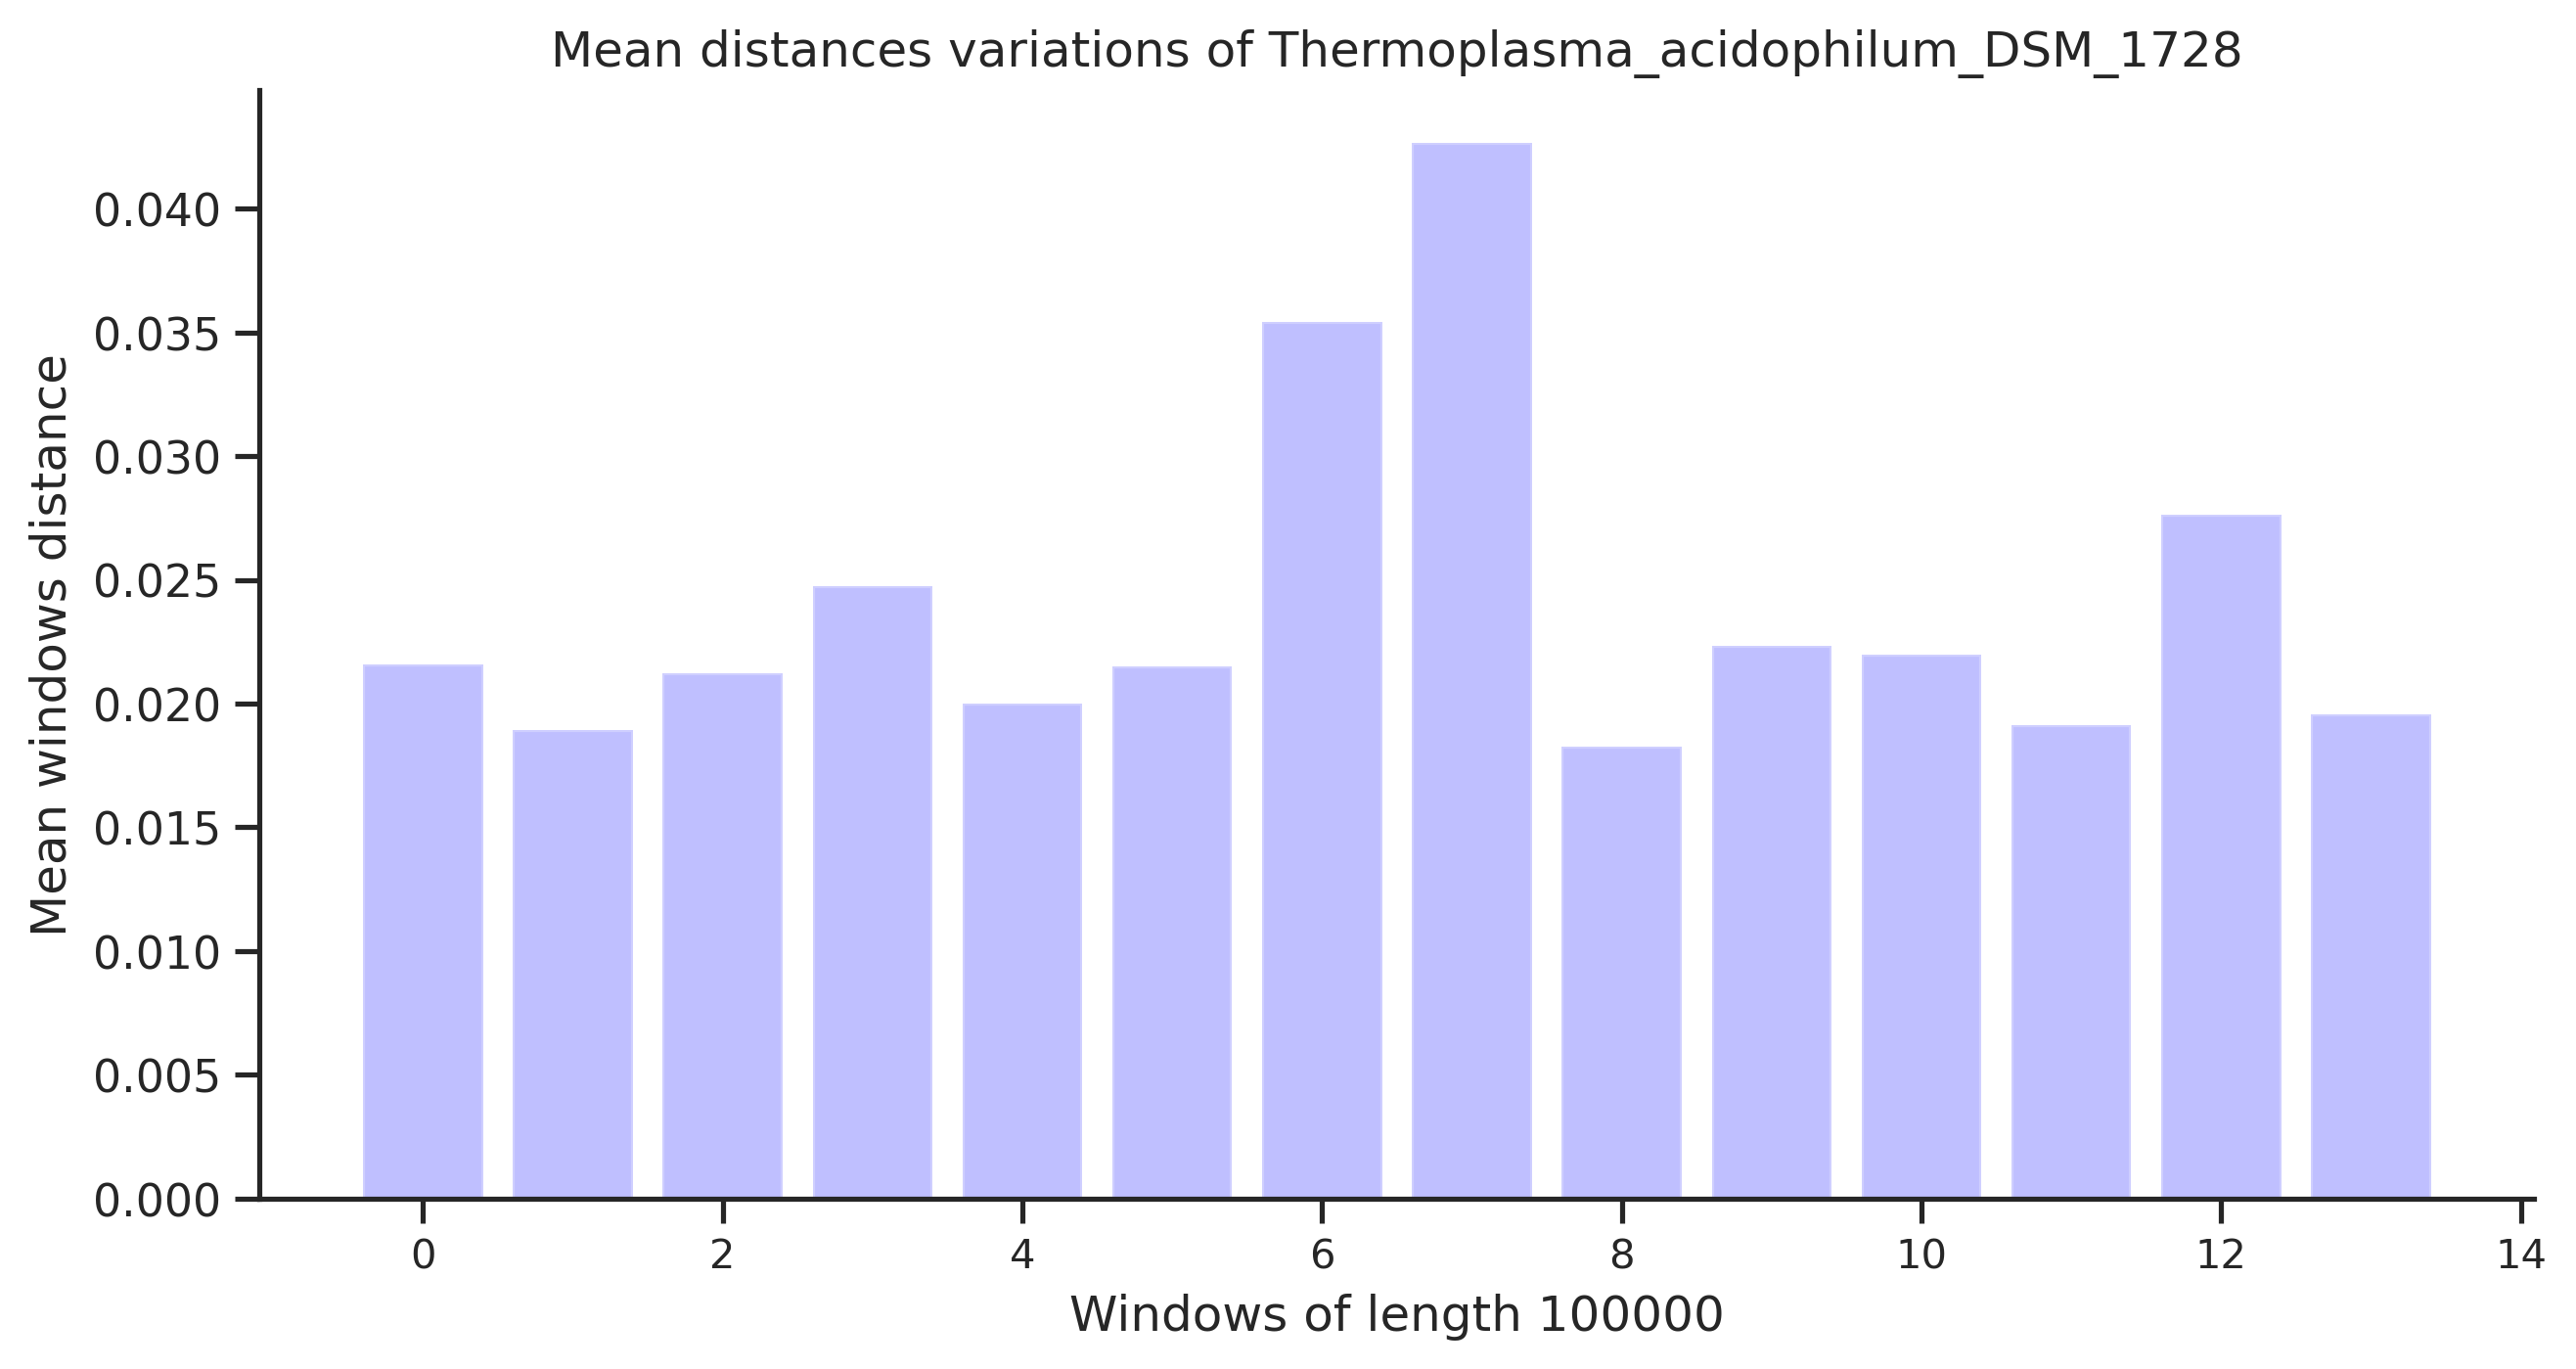

<Figure size 432x288 with 0 Axes>

In [95]:
archaeaMeans = []
print("Archaeas studied : \n")
i = 0
for index in [10, 13, 21, 41]:
    archaea = archaeaGenoms[index]
    print(archaea[0] + str(i))
    labels, scores = kmers_sweep(archaea)
    distance_plot(range(len(distance_mean(scores))), 
                  distance_mean(scores), 
                  "Mean distances variations of "+archaea[0], 
                  "Windows of length 100000", 
                  "Mean windows distance", 
                  10)
    i += 1

### Intérpretations


**1)** Après avoir afficher la signature de plusieurs archées et bactéries, on observe que en général la signature génomique a une variation constante le long du génome comme dans le cas de `Akkermansia_muciniphila_ATCC_BAA-835` et `Methanocorpusculum_labreanum_Z2`. Il y a toute fois certaines parties qui ont des variations beaucoup plus grandes que les autres parties :
- Pour `Corynebacterium_glutamicum_ATCC_13032` et `Thermoplasma_acidophilum_DSM_17283` on peut visualiser des variations plus fortes au centre du génome.
- Pour `Metallosphaera_sedula_DSM_53481` et `Cupriavidus_taiwanensis_isolate_Cupriavidus_taiwanensis_STM_6041_plasmid_I` on peut visualiser des variations plus fortes au début du génome.
- Pour `Haloterrigena_turkmenica_DSM_55110` et `Cupriavidus_taiwanensis_isolate_Cupriavidus_taiwanensis_STM_6083_` on peut visualiser des variations plus fortes à la fin du génome.

**2)** Ces variations correspondent à des transferts horizontaux récents. En effet ils montrent de grandes différences de signature génomique avec le reste des morceaux du génome.

**3)** On arrive donc bien à détécter les gènes des transferts récents car ils correspondent aux morceaux de génomes avec le plus de différence de distance avec les autres morceaux du génome.

------------------------------------------------------------------

## Piste d'exploitation 2 : Classification des profils

Si les signatures génomiques des différents génomes sont très différentes, on peut utiliser cette propriété pour assigner un gène inconnu à un génome, en choisissant le génome dont la signature est la plus proche de celle du gène. Plusieurs méthodes statistiques permettent
de faire ce genre d’analyse. 
1. La plus rudimentaire consiste à choisir le génome dont la signature est la plus proche. 
2. Une approche plus complexe (mais plus intéressante) serait d’employer des réseaux de neurones, pour prédire un génome à partir d’une composition.

## Isolation d'un morceau de génome avec une forte différence de distances par rapport au génome
On implémente une fonction `get_window_transfer` pour récuperer le morceau du génome provenant d'un transfert horizontal récent. Pour cela on récupère le morceau du génome avec la plus forte distance moyenne et on la retourne.

In [14]:
def get_window_transfer(genomTuple, k=2, window=100000):
    labels, scores = kmers_sweep(genomTuple, k, window)
    max_value = np.max(distance_mean(scores))
    index = distance_mean(scores).index(max_value)
    locus = genomTuple[1][index*window:(index+1)*window]
    _, scores_locus = kmers_count(locus)
    return locus, scores_locus

## Recherche du génome le plus proche du morceau étudié
On implémente une fonction `find_associated_genom` pour trouver le génome le plus proche du morceau passé en entrée de la fonction.

In [15]:
def find_associated_genom(score, printer=True):
    distance_min = 1
    associated_genom = ''
    if printer:
        bar = tqdm(bacteriaGenoms, ascii=True, desc="Searching nearest genom.. ")
    else:
        bar = bacteriaGenoms
    for bacteria in bar:
        _,score_bacteria = kmers_count(bacteria[1], printer=False)
        score_bacteria = score_bacteria/np.sum(score_bacteria)
        if distance_score(score,score_bacteria)< distance_min:
            distance_min = distance_score(score,score_bacteria)
            associated_genom = bacteria[0]
    return associated_genom

### Etude du morceau de génome le plus différent de l'archée `Thermoplasma_acidophilum_DSM_17283`
On recherche le génome le plus proche du morceau le plus différent du génome provenant de l'archée `Thermoplasma_acidophilum_DSM_17283`.

Sweeping k-mers.. : 100%|#######################| 15/15 [00:05<00:00,  2.66it/s]


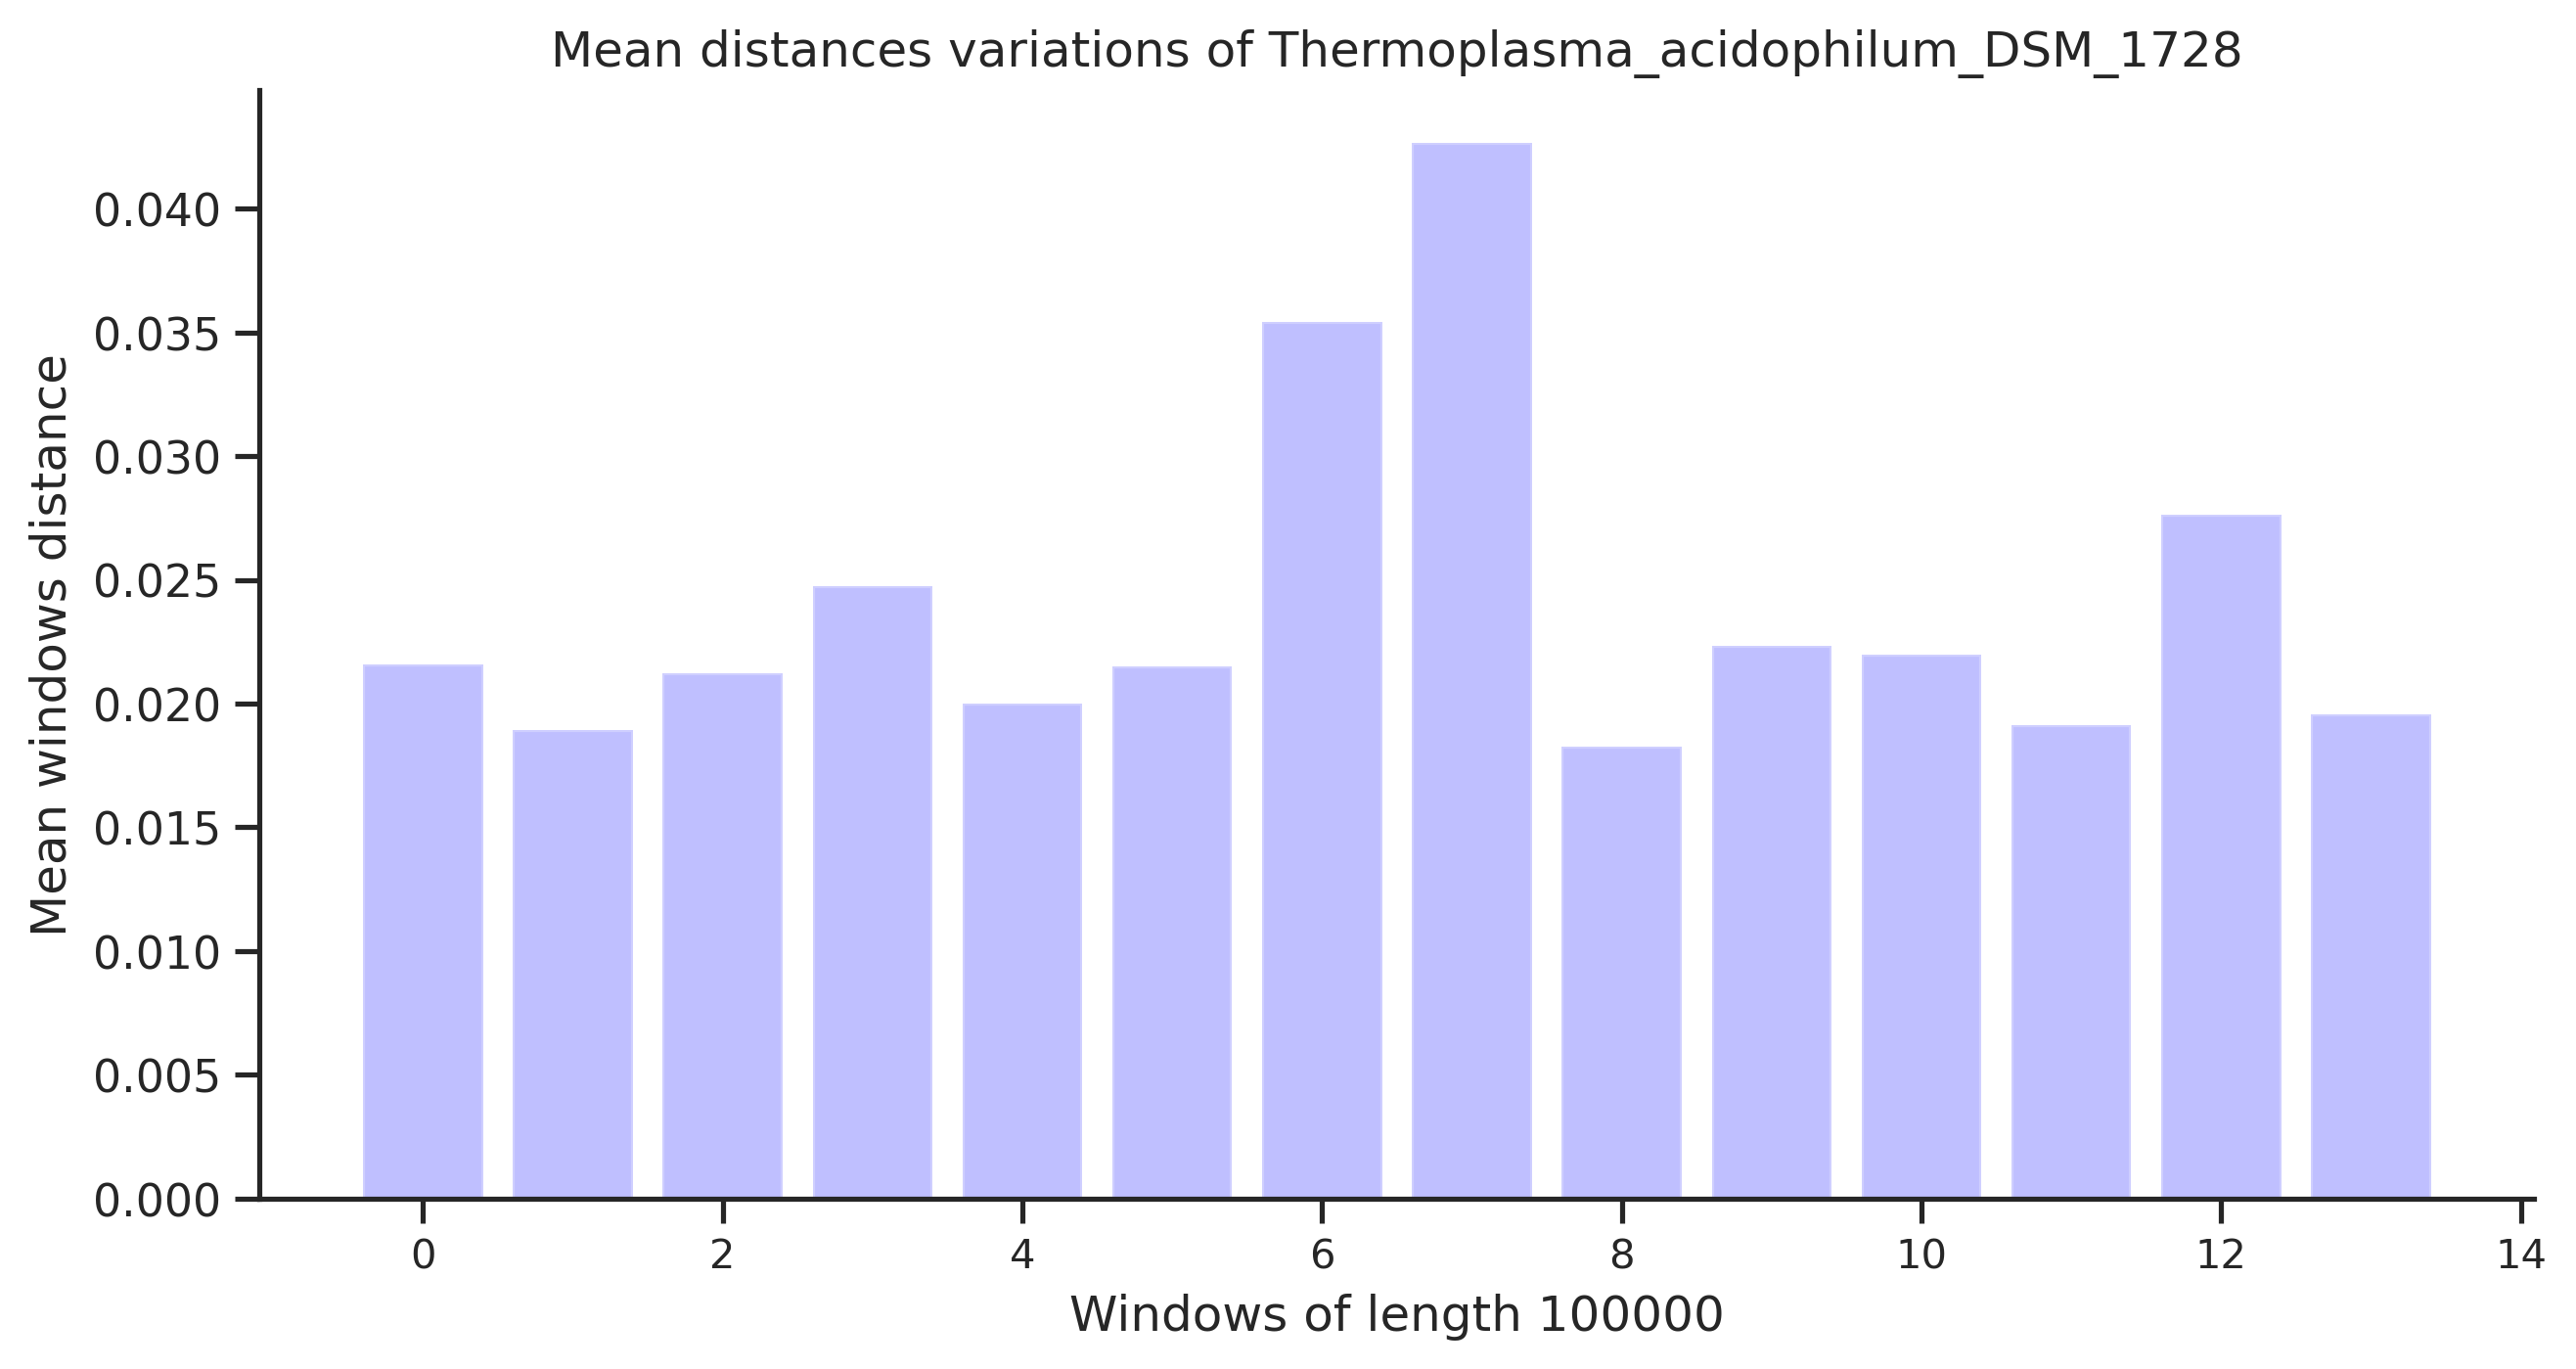

<Figure size 432x288 with 0 Axes>

In [17]:
labels, scores = kmers_sweep(archaeaGenoms[41])
distance_plot(range(len(distance_mean(scores))), 
        distance_mean(scores), 
        "Mean distances variations of "+archaeaGenoms[41][0], 
        "Windows of length 100000", 
        "Mean windows distance", 
        10)

In [18]:
locus, score_locus = get_window_transfer(archaeaGenoms[41])
nearest_genom = find_associated_genom(score_locus)
print("Le génome le plus proche du plus récent transfert sur l'archée "
      + archaeaGenoms[41][0] + " provient de la bactérie " + nearest_genom)

Searching nearest genom.. : 100%|###############| 98/98 [31:08<00:00, 19.07s/it]

Le génome le plus proche du plus récent transfert sur l'archée Thermoplasma_acidophilum_DSM_1728 provient de la bactérie Bacteroides_fragilis_YCH46


On affiche la signature du morceau du transfer de l'archée et la signature de la bactérie.

Counting k-mers.. : 100%|#########| 5311063/5311063 [00:21<00:00, 243157.86it/s]


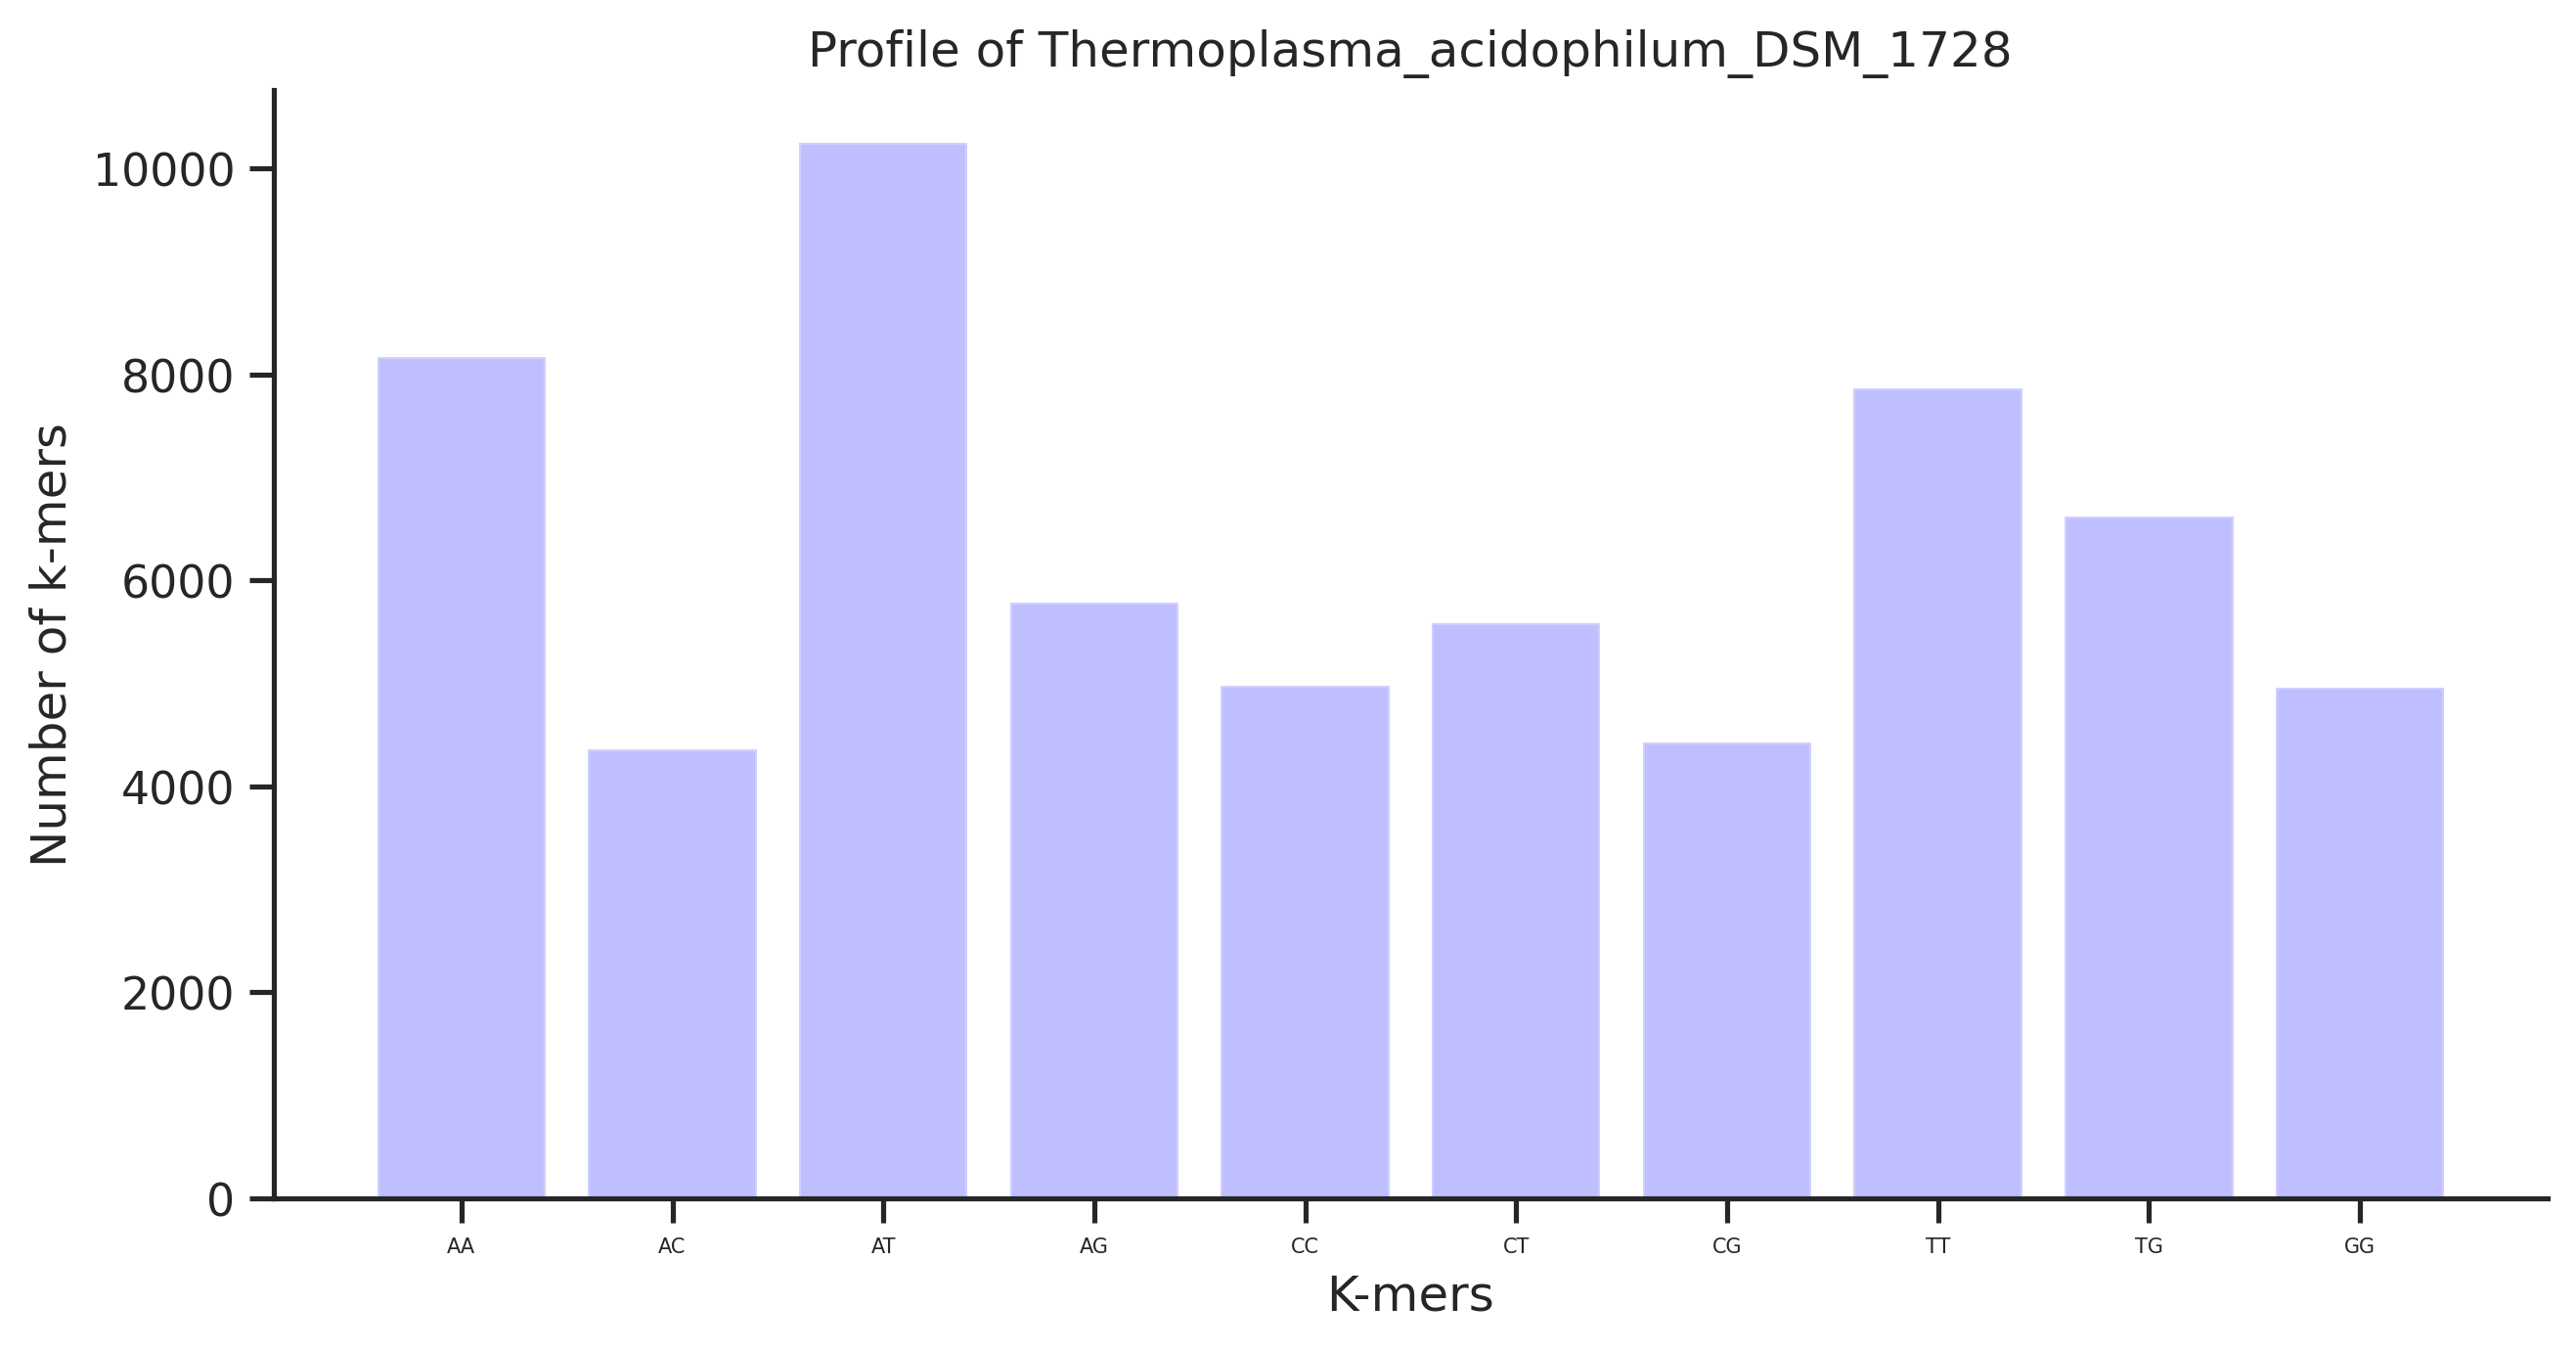

<Figure size 432x288 with 0 Axes>

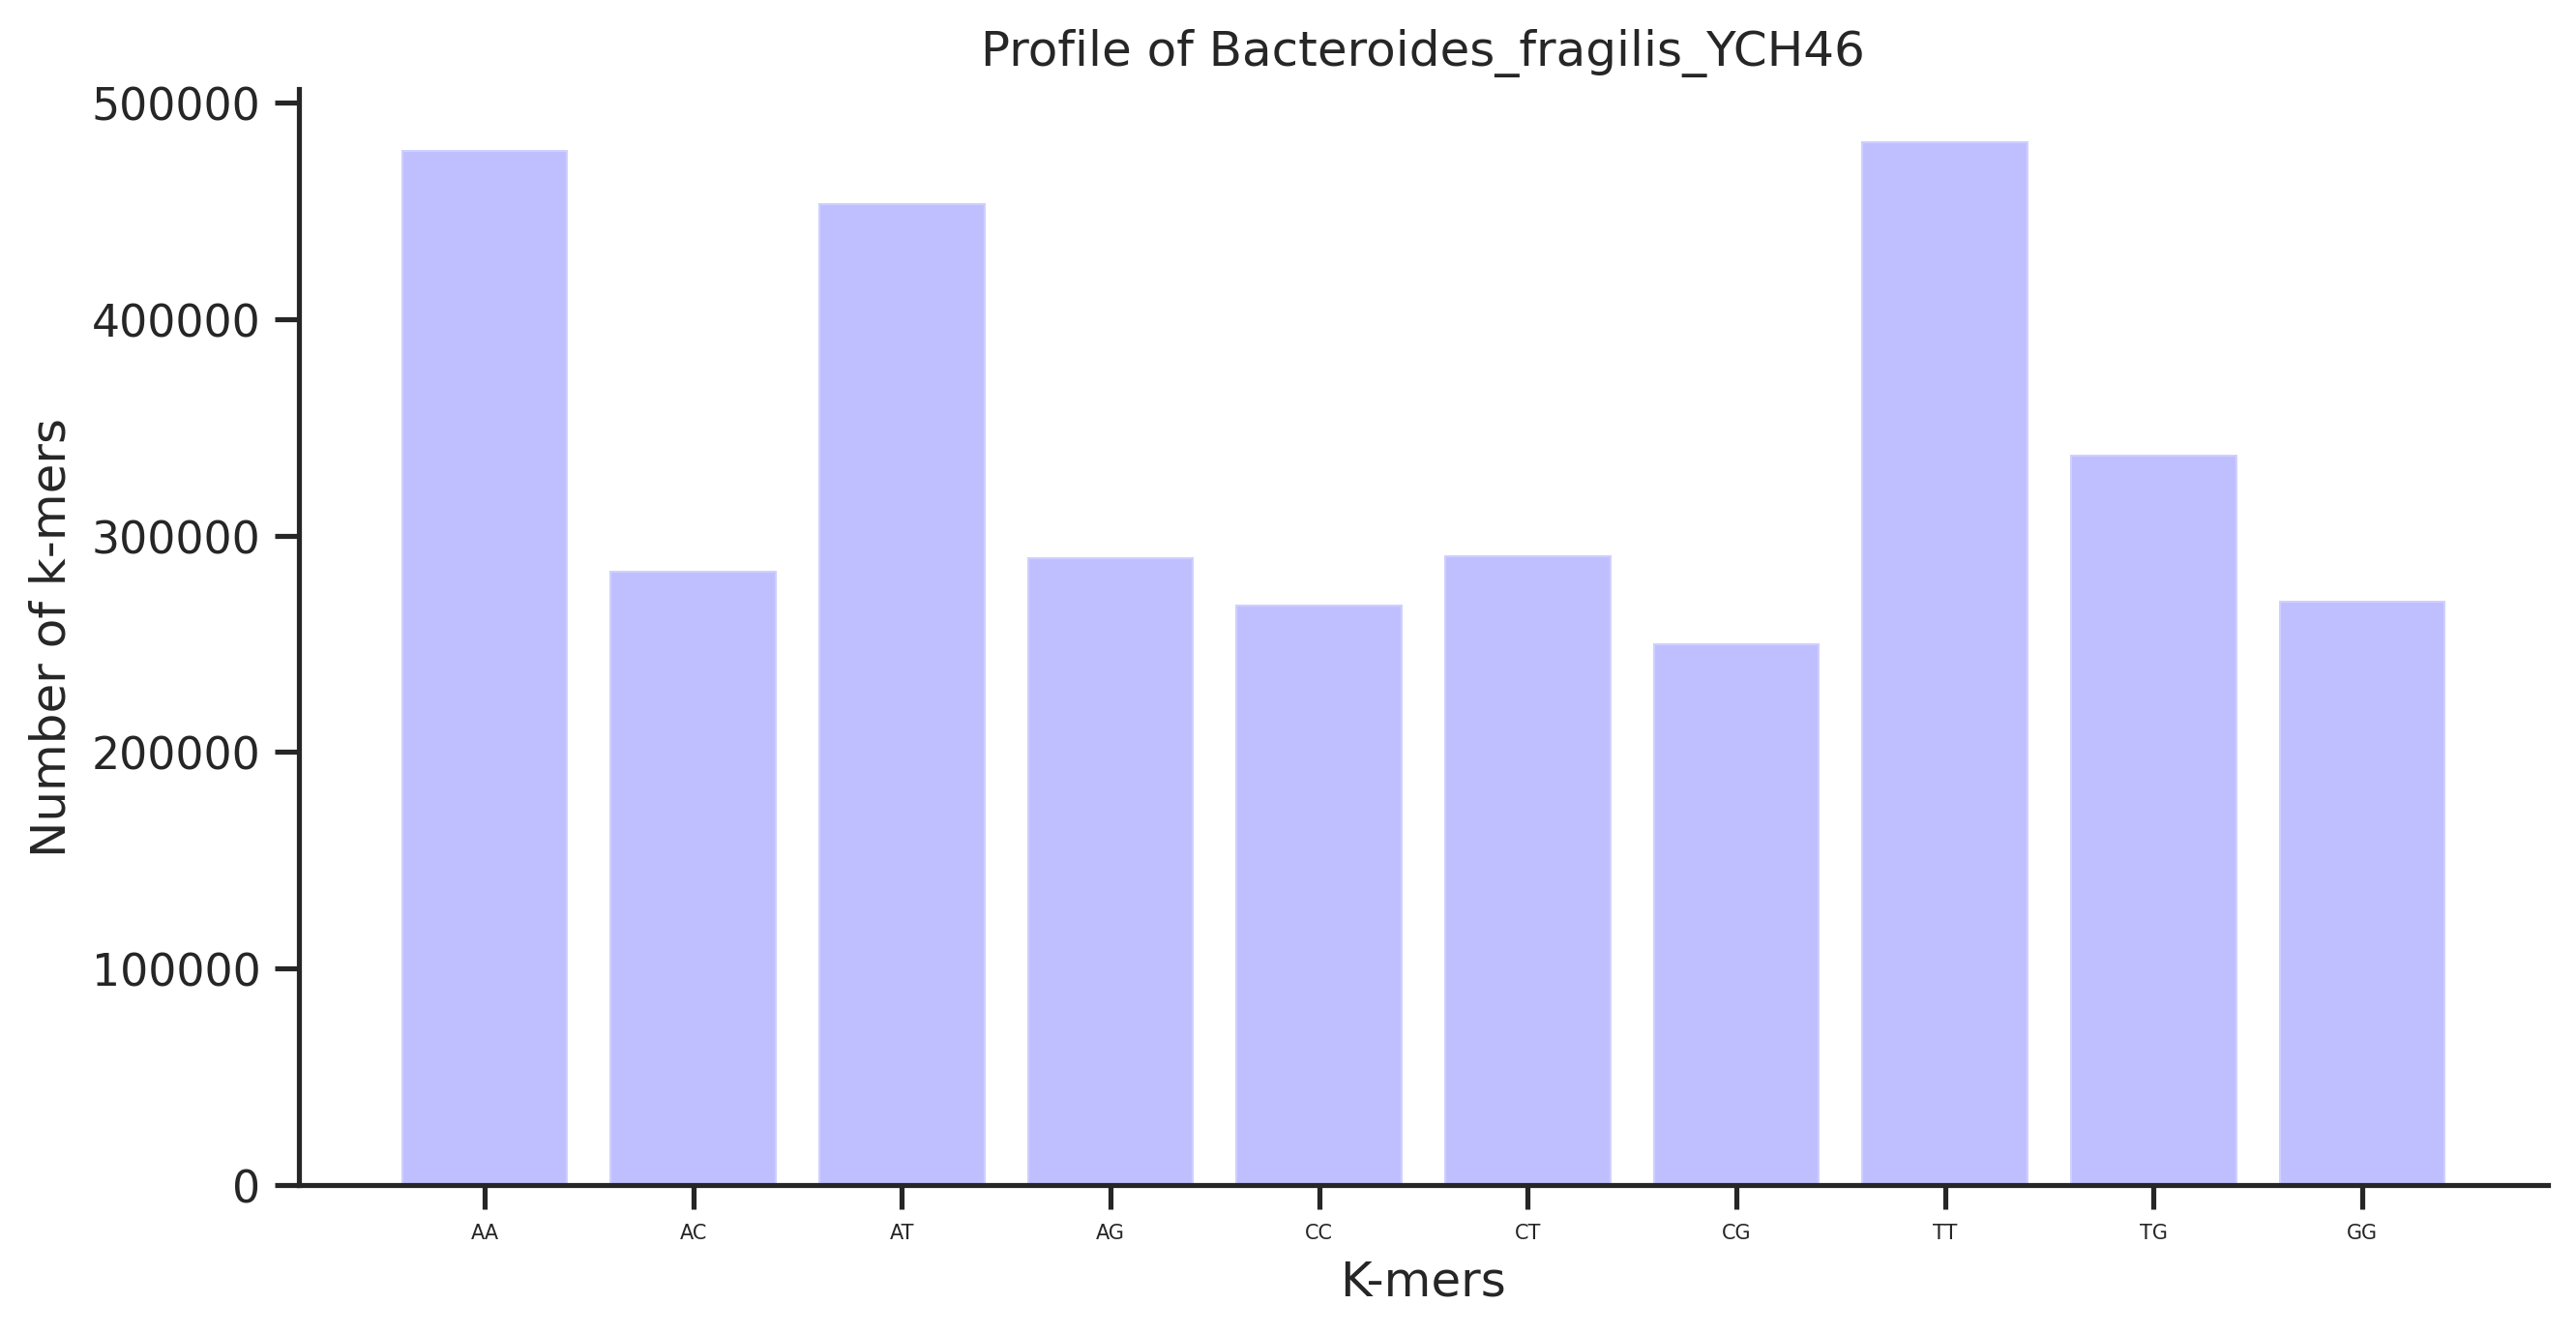

<Figure size 432x288 with 0 Axes>

In [22]:
labels, scores = kmers_count(bacteriaGenoms[7][1])
profile_plot(labels, 
             score_locus, 
             "Profile of the newest transfer of "+archaeaGenoms[41][0], 
             "K-mers", 
             "Number of k-mers")

profile_plot(labels, 
             scores, 
             "Profile of "+bacteriaGenoms[7][0], 
             "K-mers", 
             "Number of k-mers")

### Etude du morceau de génome le plus différent de l'archée `Metallosphaera_sedula_DSM_53481`
On recherche le génome le plus proche du morceau le plus différent du génome provenant de l'archée `Metallosphaera_sedula_DSM_53481`.

Sweeping k-mers.. : 100%|#######################| 21/21 [00:07<00:00,  2.71it/s]


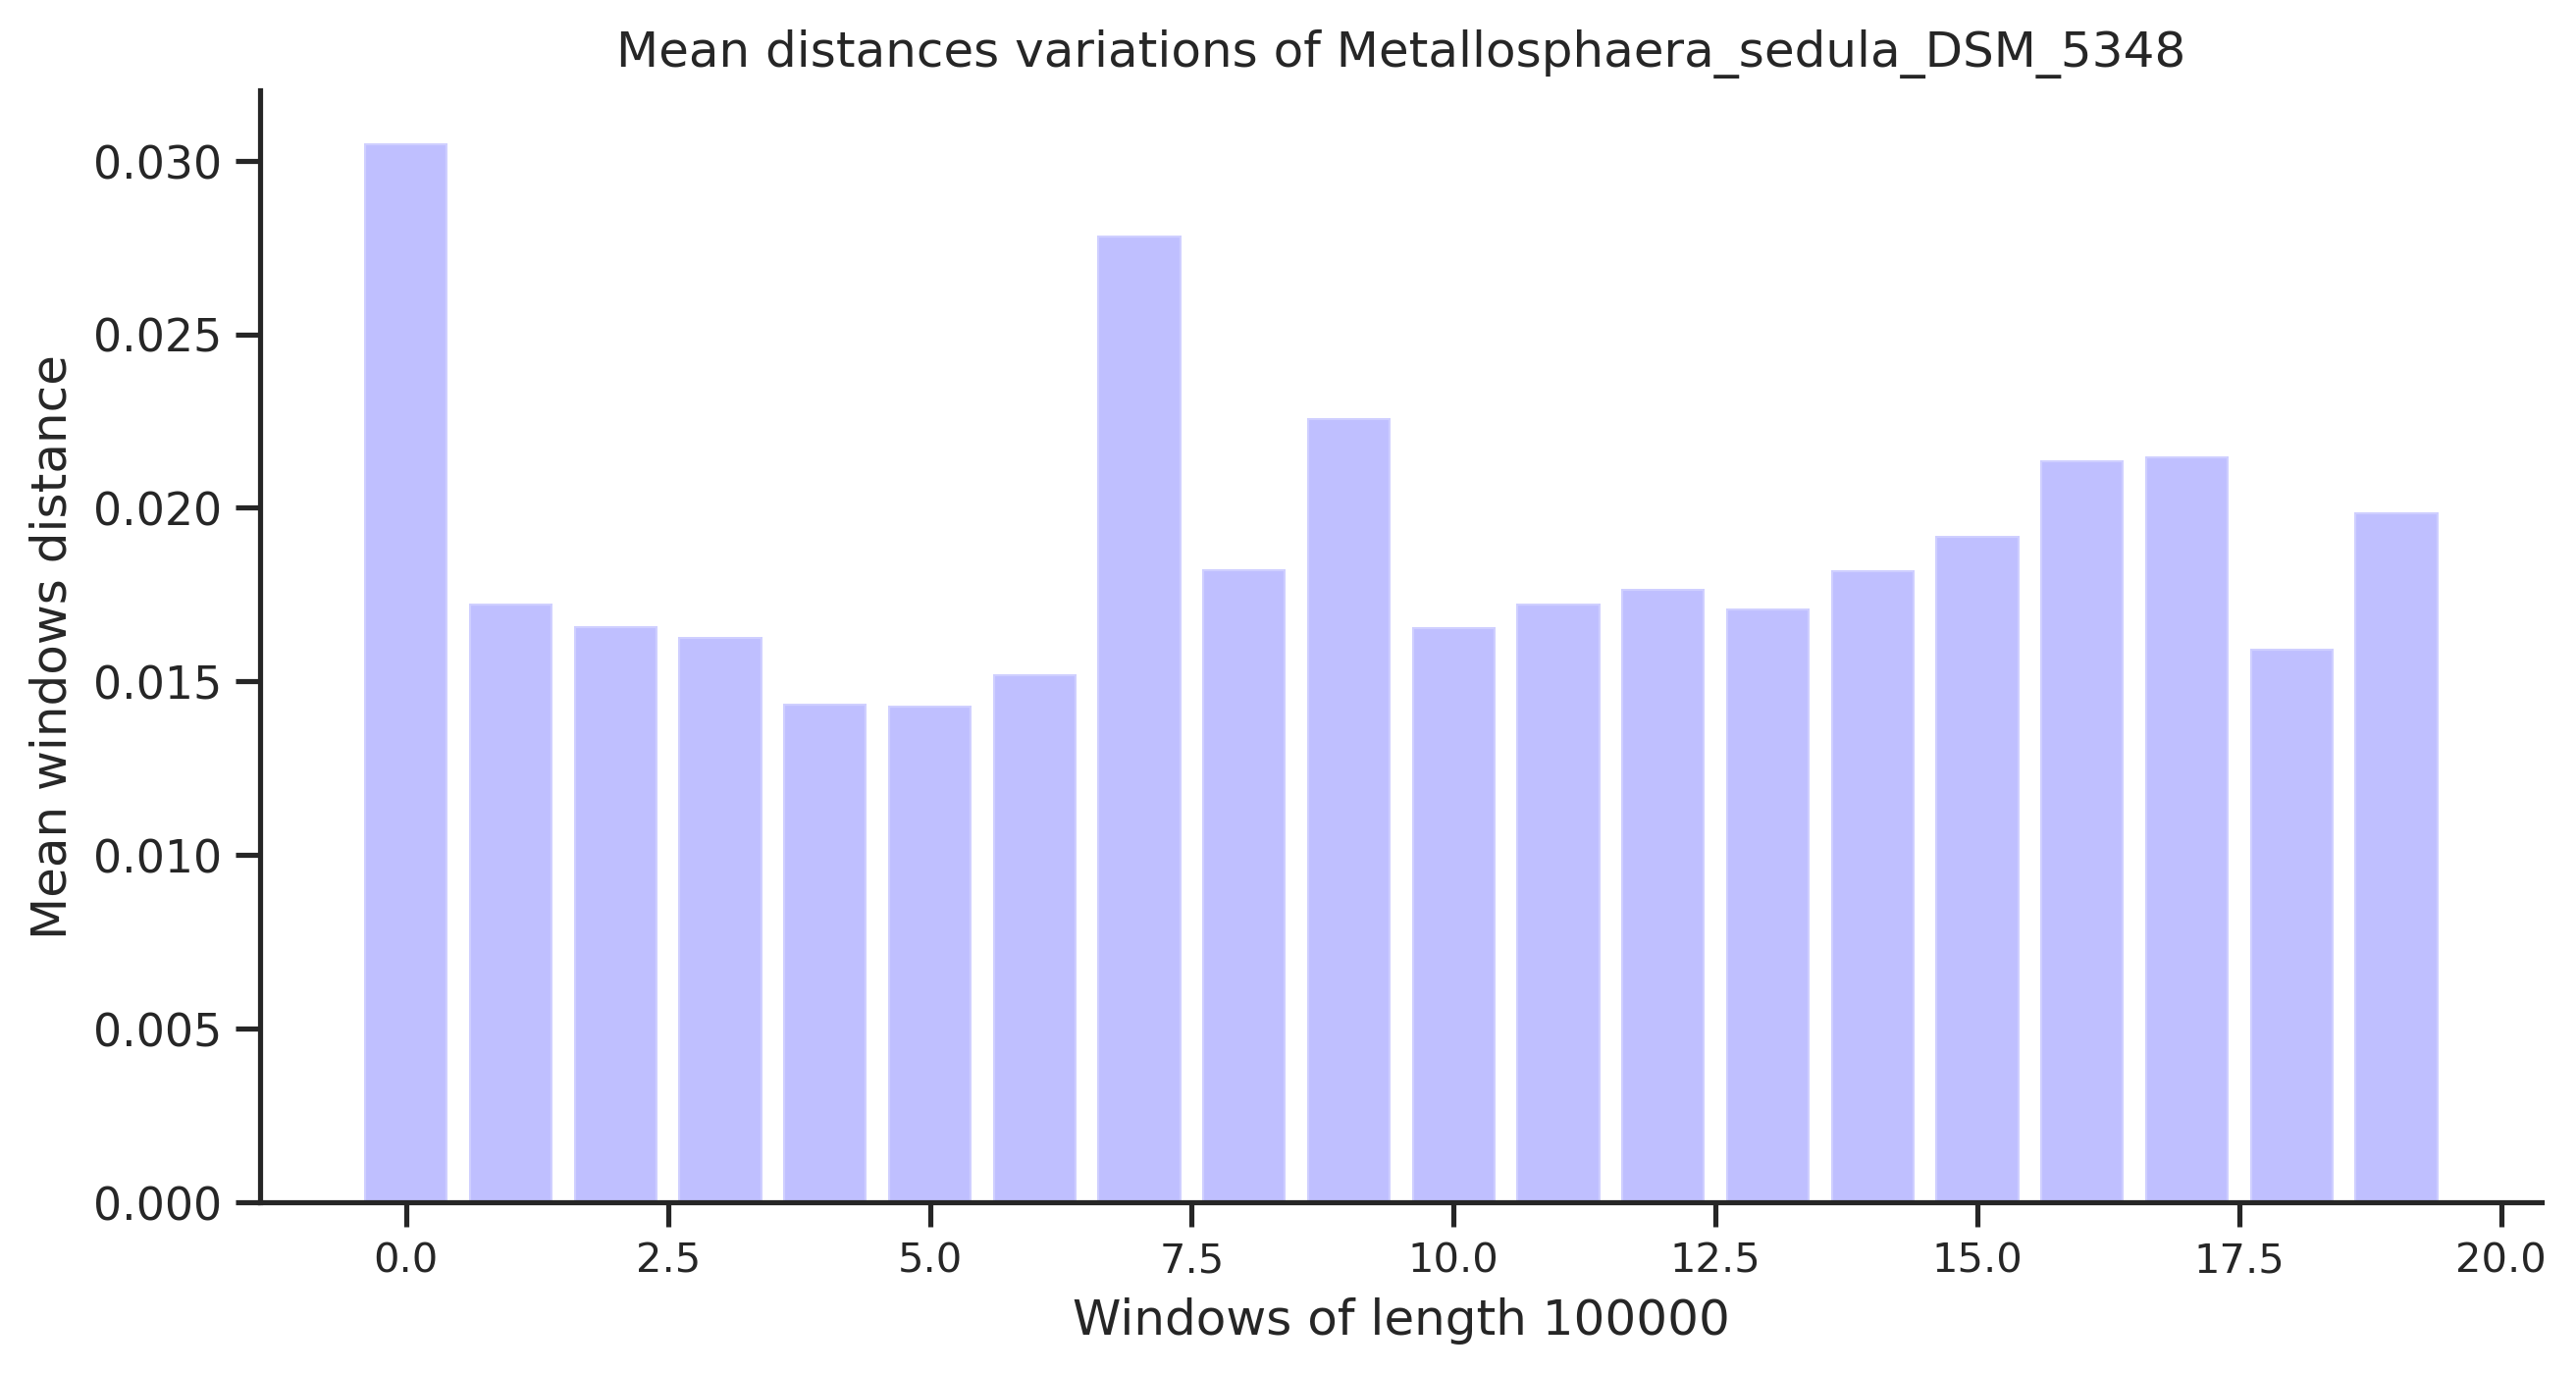

<Figure size 432x288 with 0 Axes>

In [23]:
labels, scores = kmers_sweep(archaeaGenoms[13])
distance_plot(range(len(distance_mean(scores))), 
        distance_mean(scores), 
        "Mean distances variations of "+archaeaGenoms[13][0], 
        "Windows of length 100000", 
        "Mean windows distance", 
        10)

In [24]:
locus, score_locus = get_window_transfer(archaeaGenoms[13])
nearest_genom = find_associated_genom(score_locus)
print("Le génome le plus proche du plus récent transfert sur l'archée "
      + archaeaGenoms[13][0] + " provient de la bactérie " + nearest_genom)

Searching nearest genom.. : 100%|###############| 98/98 [30:57<00:00, 18.95s/it]

Le génome le plus proche du plus récent transfert sur l'archée Metallosphaera_sedula_DSM_5348 provient de la bactérie Thermotoga_maritima_MSB8


On affiche la signature du morceau du transfer de l'archée et la signature de la bactérie.

Counting k-mers.. : 100%|#########| 1860725/1860725 [00:07<00:00, 250827.78it/s]


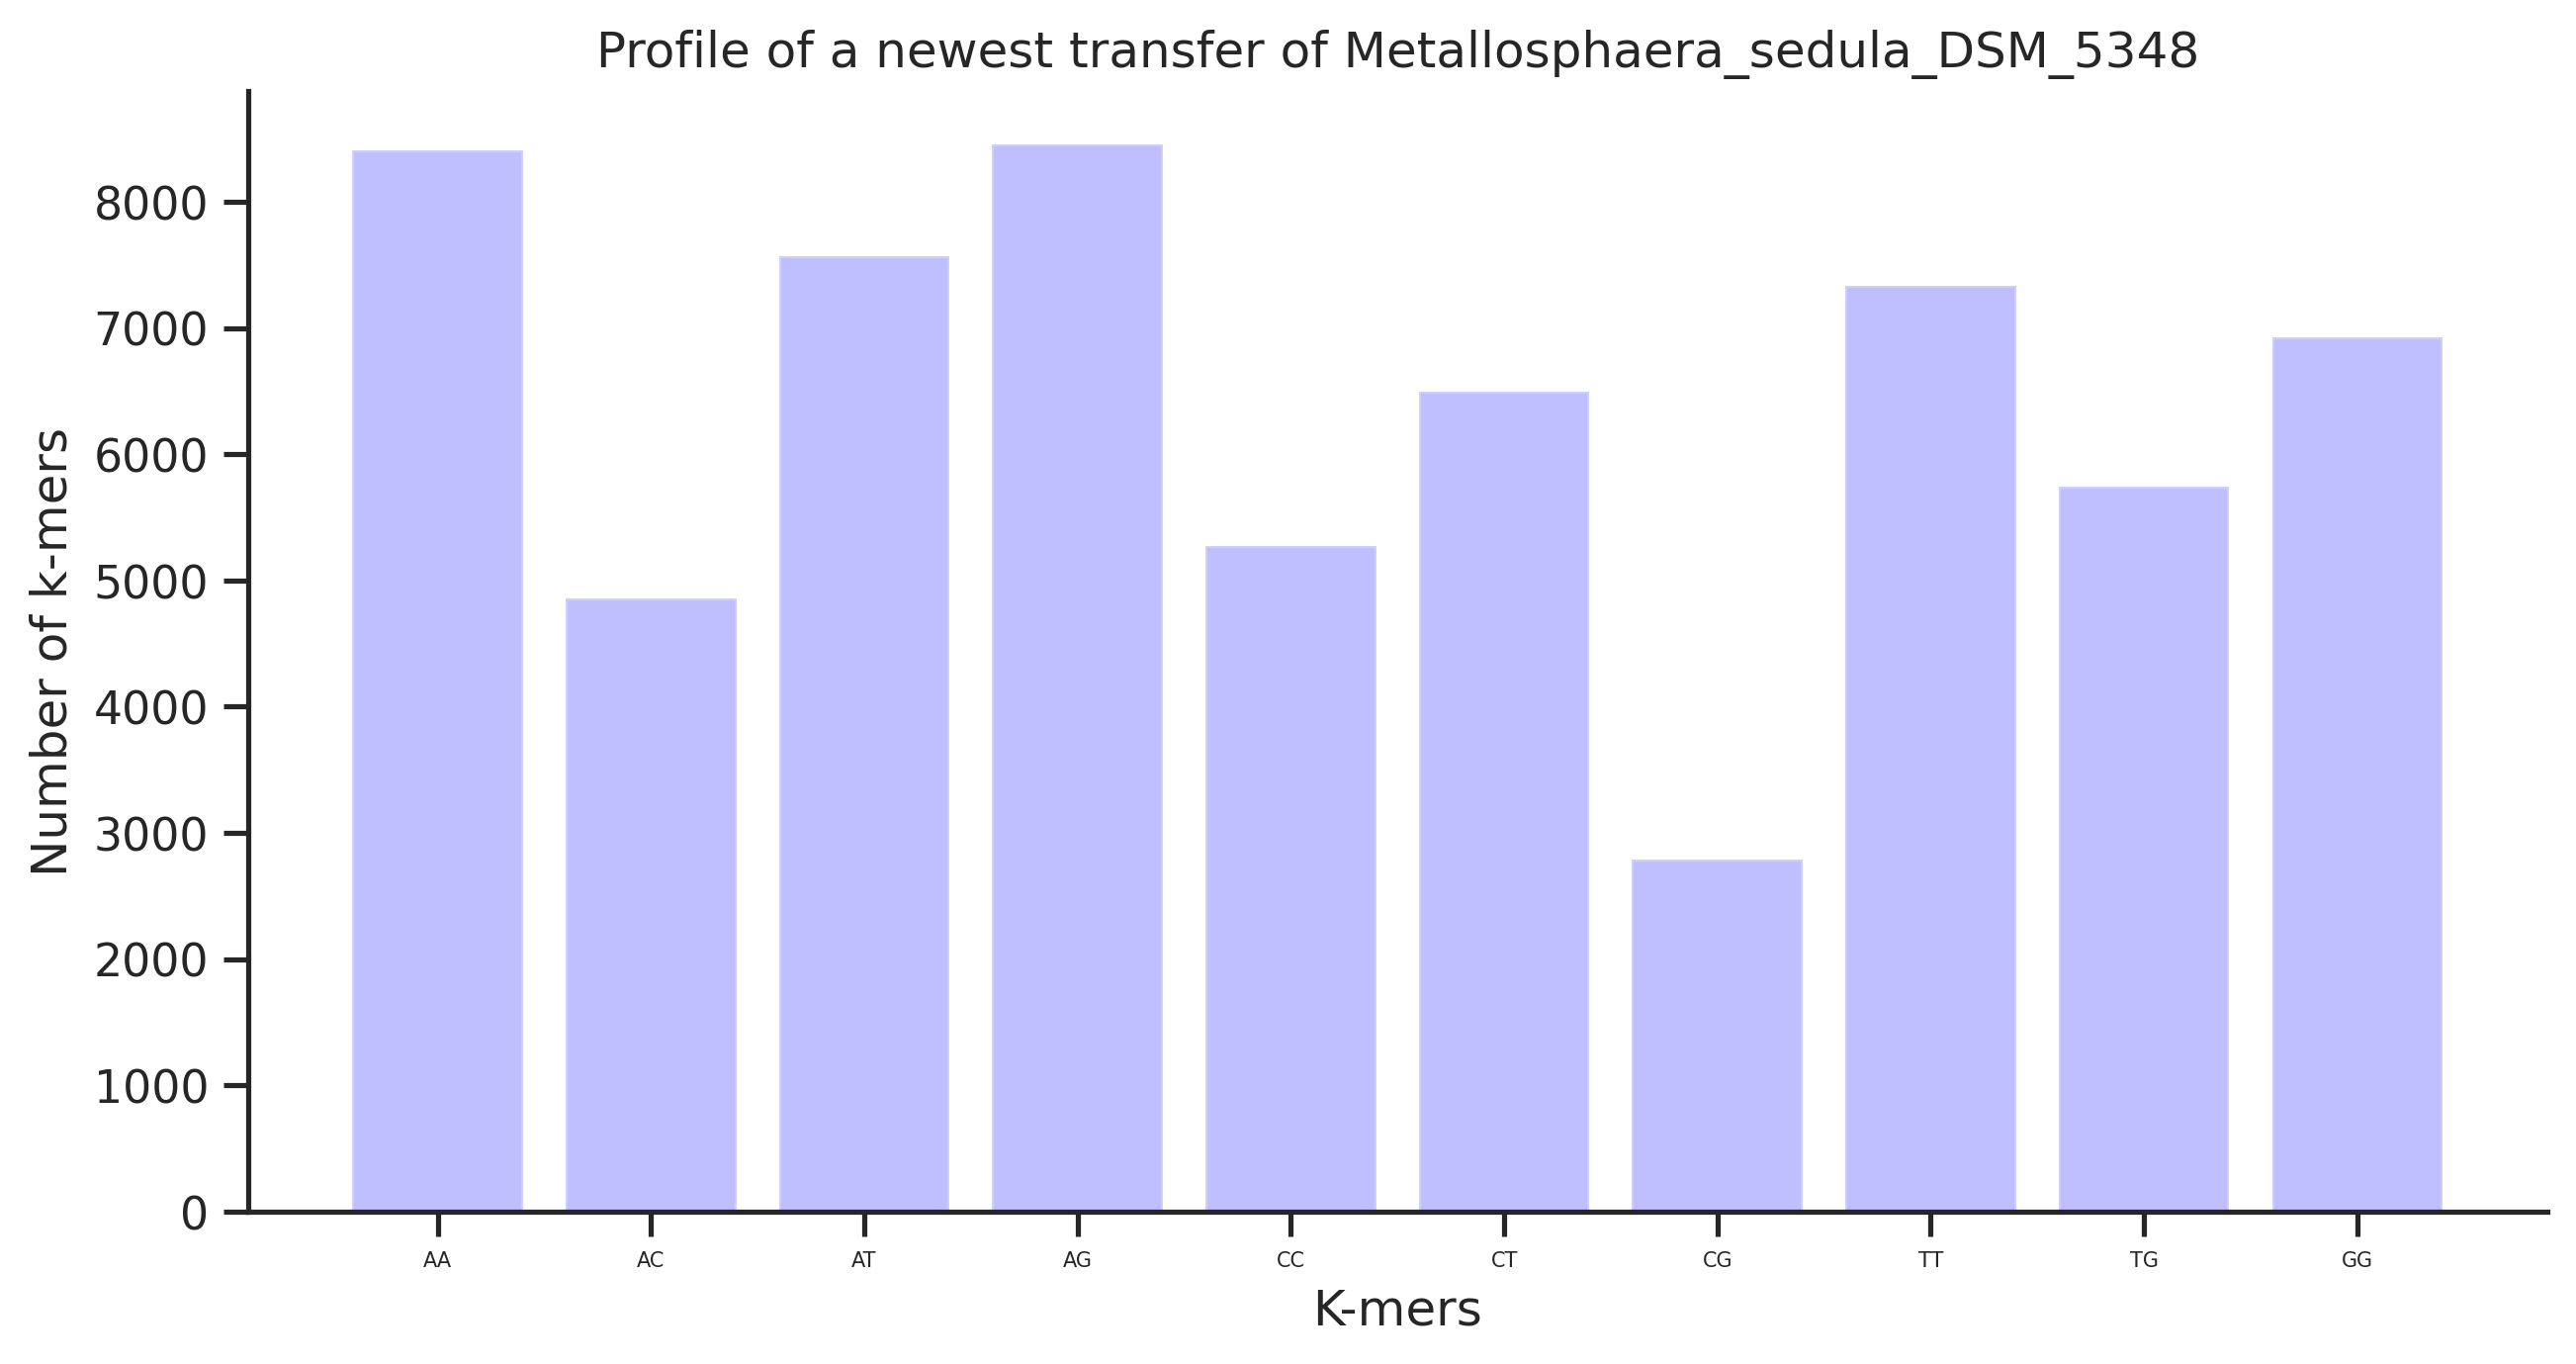

<Figure size 432x288 with 0 Axes>

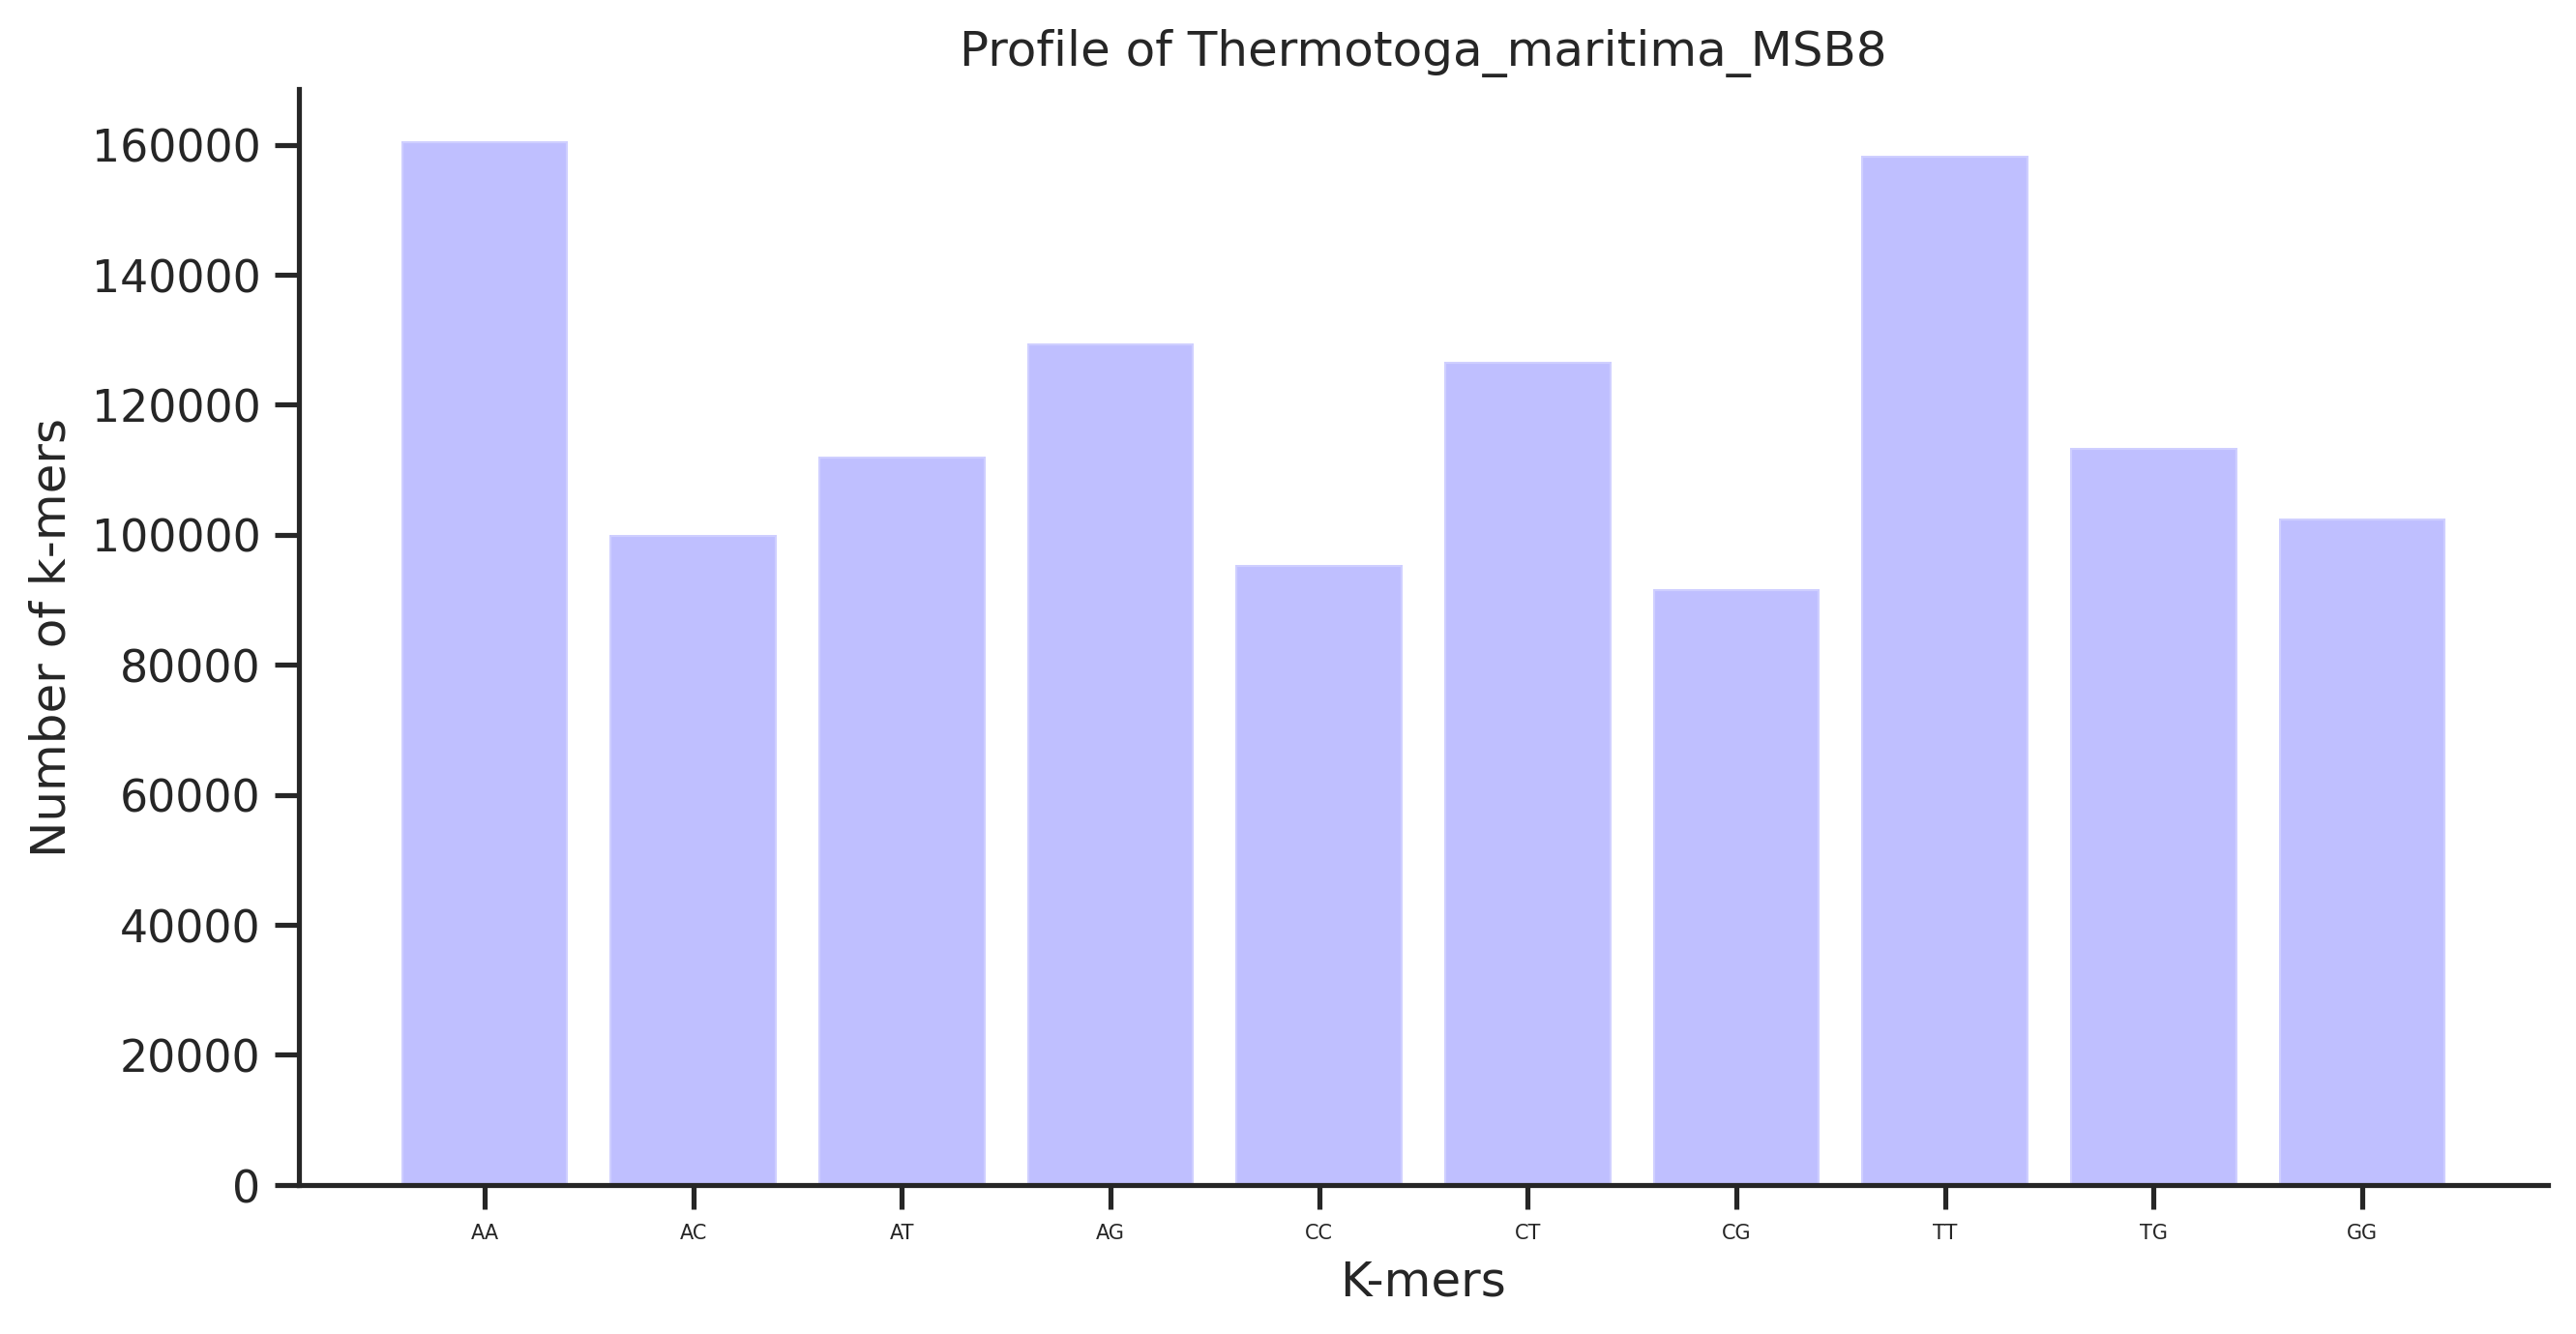

<Figure size 432x288 with 0 Axes>

In [25]:
labels, scores = kmers_count(bacteriaGenoms[96][1])
profile_plot(labels, 
             score_locus, 
             "Profile of a newest transfer of "+archaeaGenoms[13][0], 
             "K-mers", 
             "Number of k-mers")

profile_plot(labels, 
             scores, 
             "Profile of "+bacteriaGenoms[96][0], 
             "K-mers", 
             "Number of k-mers")

## Construction du classifieur
On implémente un classifieur

Tout d'abord on defini les données d'entrainement

In [25]:
def create_data(window = 400000, printer=True):
    Xlearn = []
    Ylearn = []
    if printer:
        bar1 = tqdm(archaeaGenoms, ascii=True, desc="Creating archaea data.. ")
        bar2 = tqdm(bacteriaGenoms, ascii=True, desc="Creating bacteria data.. ")
    else:
        bar1 = archaeaGenoms
        bar2 = bacteriaGenoms
    
    for archaea in archaeaGenoms:
        for i in range(len(archaea[1])//window):
            labels, scores = kmers_count(archaea[1][i*window:(i+1)*window], 
                                         printer=False)
            Xlearn.append(scores)
            Ylearn.append(archaea[0])
    for bacteria in bacteriaGenoms:
        for i in range(len(bacteria[1])//window):
            labels, scores = kmers_count(bacteria[1][i*window:(i+1)*window], 
                                         printer=False)
            Xlearn.append(scores)
            Ylearn.append(bacteria[0])
    
    data = {'Xlearn':Xlearn, 'Ylearn':Ylearn} 
    data = pd.DataFrame(data)
    
    return data

data = create_data()
data.to_csv('data.csv', header=False, index=False)
print("Data size : " + str(len(data)))

Counting k-mers.. : 100%|###########| 400000/400000 [00:01<00:00, 255346.48it/s]


Counting k-mers.. : 100%|###########| 400000/400000 [00:01<00:00, 263429.49it/s]


In [26]:
print(len(data))

240


On fait une démonstration notre classifieur en récupérant les signatures des premiers génomes de nos bactéries n'ayant pas le temps d'utiliser la fonction create_data() et de faire tourner les données récupérées avec sur notre réseau de neurone.

In [17]:
Xtrain = []
Ytrain = []
for i in range(4):
    _,genomic_signature = kmers_count(bacteriaGenoms[i][1],printer=False)
    Xtrain.append(genomic_signature)
    Ytrain.append(i)

data = {'Xtrain':Xtrain, 'Ytrain':Ytrain } 
data = pd.DataFrame(data) 
data.head()

Xtrain  Ytrain
0  [181982.0, 80590.0, 166817.0, 80686.0, 40756.0...       0
1  [186522.0, 192892.0, 200201.0, 238158.0, 31731...       1
2  [176868.0, 122202.0, 152518.0, 139686.0, 23540...       2
3  [130954.0, 172349.0, 146272.0, 162068.0, 24364...       3

In [18]:
# Network
model = Sequential() # Création d'un réseau de neurones vide 
Xtrain = np.array(Xtrain)
Ytrain = np.array(Ytrain)

model.add(Dense(500, activation='relu', input_shape=(10,)))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               5500      
                                                                 
 dense_1 (Dense)             (None, 100)               50100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 60,701
Trainable params: 60,701
Non-trainable params: 0
_________________________________________________________________


In [19]:
# train the network
model.fit(Xtrain,Ytrain, epochs=450,batch_size=10)

Epoch 1/450
1/1 [==============================] - 1s 991ms/step - loss: 0.0000e+00 - accuracy: 0.2500
Epoch 2/450
1/1 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.2500
Epoch 3/450
1/1 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - accuracy: 0.2500
Epoch 4/450
1/1 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - accuracy: 0.2500
Epoch 5/450
1/1 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - accuracy: 0.2500
Epoch 6/450
1/1 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.2500
Epoch 7/450
1/1 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - accuracy: 0.2500
Epoch 8/450
1/1 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - accuracy: 0.2500
Epoch 9/450
1/1 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.2500
Epoch 10/450
1/1 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - accu

1/1 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - accuracy: 0.2500
Epoch 161/450
1/1 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - accuracy: 0.2500
Epoch 162/450
1/1 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.2500
Epoch 163/450
1/1 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.2500
Epoch 164/450
1/1 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 0.2500
Epoch 165/450
1/1 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 0.2500
Epoch 166/450
1/1 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.2500
Epoch 167/450
1/1 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.2500
Epoch 168/450
1/1 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.2500
Epoch 169/450
1/1 [==============================] - 0s 7ms/step - loss: 0.0000e+00 

1/1 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.2500
Epoch 319/450
1/1 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.2500
Epoch 320/450
1/1 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.2500
Epoch 321/450
1/1 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.2500
Epoch 322/450
1/1 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.2500
Epoch 323/450
1/1 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.2500
Epoch 324/450
1/1 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.2500
Epoch 325/450
1/1 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 0.2500
Epoch 326/450
1/1 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.2500
Epoch 327/450
1/1 [==============================] - 0s 10ms/step - loss: 0.0000e+00 -

In [20]:
pred_train= model.predict(Xtrain)
scores = model.evaluate(Xtrain, Ytrain, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))  

Accuracy on training data: 0.25% 
 Error on training data: 0.75


On constate donc bien qu'il faudrait beaucoup plus de données car l'apprentissage est ici clairement insuffisant pour obtenir des prédictions valables.

------------------------------------------------------------------

## Piste d'exploitation 3 : Arbres des profils

A partir de la signature de deux génomes, on peut concevoir une distance qui quantifie à quel point ces signatures se ressemblent. 
1. Peut-on réaliser une classification hiérarchique des génomes à partir de ces distances entre paires de génomes ?
2. L’arbre obtenu est-il très différent d’un arbre phylogénétique obtenu à partir de l’ARNr 16 des organismes correspondant ? Que peut-on en conclure ?

## Construction de la matrice de distance

On implémente une fonction `make_distance_matrix` pour créer la matrice de distance que l'on utilisera par la suite. Cette fonction compte les k-mères des organismes qui seront comparés et rempli la matrice de distance avec le score de `distance_score`. On passe l'index de génomes que l'on souhaite étudier dans la liste `genoms_indexes`.

In [42]:
def make_distance_matrix(genomsListTuple,nb_kmers,genoms_indexes,printer=True):
    nbGenoms = len(genoms_indexes)
    if printer:
        bar = tqdm(range(nbGenoms), ascii=True, desc="Making distance matrix.. ")
    else:
        bar = range(nbGenoms)
        
    scoresList = []
    for i in bar:
        index = genoms_indexes[i]
        labels, scores = kmers_count(genomsListTuple[index][1],k=nb_kmers,printer=False)
        scoresList.append(scores)
        
    distanceMatrix = np.zeros((nbGenoms, nbGenoms))
    for i in range(nbGenoms):
        for j in range(nbGenoms):
            distanceMatrix[i,j] = distance_score(scoresList[i], scoresList[j])
    
    return distanceMatrix

## Algorithme Neighbor-Joining

On implémente l'algorithme `Neighbor-Joining` dans une fonction `neighborJoining`. On implémente aussi une sous-fonction `findNewDistancesNJ` pour trouver les distances entre les clusters.

In [43]:
def findNewDistancesNJ(Matrix, f, g):
    """ Calculate the distance between two cluster """
    n, m = np.shape(Matrix)
    newDistances = np.zeros(n, dtype=float)
    for x in np.arange(n):
        if x == f:
            newDistances[x] = 0
        else :
            newDistances[x] = ((Matrix[f, x]+Matrix[g, x]-Matrix[f, g]))/2
    return newDistances

In [54]:
def neighborJoining(Matrix_Dist, Names):
    #To work, we need the dimension of names 
    #equal to both dimensions of the distanceMatrix
    
    Matrix = copy.deepcopy(Matrix_Dist)
    names = copy.deepcopy(Names)
    
    n, m = np.shape(Matrix)
    print("\n")
    print("distanceMatrix size "+str(n)+" and clusters")
    print(names)
    print(Matrix)
    while len(Matrix)>2:
        
        #STEP 1 : Calculate the Q matrix
        n, m = np.shape(Matrix)
        qMatrix = np.zeros((n, m))
        for x in np.arange(n):
            for y in np.arange(m):
                if x == y:
                    qMatrix[x, y] = 0
                else :
                    qMatrix[x, y] = ((n-2)*Matrix[x, y])-np.sum(Matrix[x, :])-np.sum(Matrix[y, :])
        print("qMatrix size "+str(n))
        print(qMatrix)
        #STEP 2 : Find the minimum distance
        matrix = qMatrix+(999999999*np.identity(n))
        index = np.argmin(matrix)
        f = int(index/n)
        g = np.mod(index, m)
        minimum = qMatrix[f, g]
        
        newDistances = findNewDistancesNJ(Matrix, f, g)
    
        #STEP 3 : Update the nodes
        #linkDistance = minimum/2
        names[f] = "("+names[f]+","+names[g]+")"
        names.pop(g)
        
        #STEP 4 : Update the distanceMatrix
        Matrix[f, :] = newDistances
        Matrix[:, f] = newDistances
        Matrix = np.delete(Matrix, np.s_[g], 1)
        Matrix = np.delete(Matrix, np.s_[g], 0)
        print("\n")
        print("distanceMatrix size "+str(n-1)+" and clusters")
        print(names)
        print(Matrix)
        
    newick = "("+names[0]+","+names[1]+")"+";"
        
    return newick

## Algorithme UPGMA

On implémente l'algorithme `UPGMA` dans une fonction `upgma`. On implémente aussi une sous-fonction `findNewDistancesUPGMA` pour trouver les distances entre les clusters et une sous-fonction `splited` pour récuperer le cardinal de chaque cluster.

In [45]:
def splited(s):
    #To find the cardinal of a cluster
    s = s.replace(',(', ',')
    s = s.replace('),', ',')
    s = s.replace('(', ',')
    s = s.replace(')', ',')
    s = s.split(',')
    if s[0] == '':
        s.pop(0)
    if s[-1] == '':
        s.pop(-1)
    return s

In [46]:
def findNewDistancesUPGMA(distanceMatrix, tags, i, j):
    """ Calculate the distance between two cluster """
    n, m = np.shape(distanceMatrix)
    newDistances = np.zeros(n, dtype=float)
    iCard = np.size(splited(tags[i]))
    jCard = np.size(splited(tags[j]))
    for x in np.arange(n):
        if x == i:
            newDistances[x] = 0
        else :
            newDistances[x] = ((iCard*distanceMatrix[i, x])+(jCard*distanceMatrix[j, x]))/(iCard+jCard)
    return newDistances

In [52]:
def upgma(Matrix_Dist, Names):
    #To work, we need the dimension of names 
    #equal to both dimensions of the distanceMatrix
    distanceMatrix = copy.deepcopy(Matrix_Dist)
    names = copy.deepcopy(Names)
    
    n, m = np.shape(distanceMatrix)
    print("\n")
    print("distanceMatrix size "+str(n)+" and clusters")
    print(names)
    print(distanceMatrix)
    while len(distanceMatrix)>2:

        #STEP 1 : Find the minimum distance
        n, m = np.shape(distanceMatrix)
        matrix = distanceMatrix.flatten()
        matrix[matrix == 0] = 999999999
        index = np.argmin(matrix)
        i = int(index/n)
        j = np.mod(index, m)
        minimum = distanceMatrix[i, j]
        
        newDistances = findNewDistancesUPGMA(distanceMatrix, names, i, j)
    
        #STEP 2 : Update the nodes
        #linkDistance = minimum/2
        names[i] = "("+names[i]+","+names[j]+")"
        names.pop(j)
        
        #STEP 3 : Update the distanceMatrix
        distanceMatrix[i, :] = newDistances
        distanceMatrix[:, i] = newDistances
        distanceMatrix = np.delete(distanceMatrix, np.s_[j], 1)
        distanceMatrix = np.delete(distanceMatrix, np.s_[j], 0)
        print("\n")
        print("distanceMatrix size "+str(n-1)+" and clusters")
        print(names)
        print(distanceMatrix)
        
    newick = "("+names[0]+","+names[1]+")"+";"
        
    return newick


### Etude sur l'ensemble des archées

On calcule la matrice de distance sur des k-mères de 2 sur l'ensemble des archées.

In [48]:
distMatrix_k2 = make_distance_matrix(archaeaGenoms, 2, range(len(archaeaGenoms)))
print(distMatrix_k2)

Making distance matrix.. : 100%|################| 43/43 [05:57<00:00,  8.32s/it]

[[0.         0.11143061 0.16480446 ... 0.05752365 0.1358434  0.18263663]
 [0.11143061 0.         0.05779324 ... 0.11708858 0.06645234 0.08503788]
 [0.16480446 0.05779324 0.         ... 0.16901818 0.07193534 0.04242977]
 ...
 [0.05752365 0.11708858 0.16901818 ... 0.         0.14708932 0.19136661]
 [0.1358434  0.06645234 0.07193534 ... 0.14708932 0.         0.06184803]
 [0.18263663 0.08503788 0.04242977 ... 0.19136661 0.06184803 0.        ]]


On récupère l'ensemble des noms des archées.

In [55]:
archaeaNames = []
for archaea in archaeaGenoms:
    archaeaNames.append(archaea[0])

On calcule l'arbre des archées avec l'algorithme de `Neighbor-Joining`.

In [56]:
archaea_newickNJ_k2 = Tree(neighborJoining(distMatrix_k2, archaeaNames))



distanceMatrix size 43 and clusters
['Aeropyrum_pernix_K1', 'Archaeoglobus_fulgidus_DSM_4304', 'Archaeoglobus_profundus_DSM_5631', 'Caldivirga_maquilingensis_IC-167', 'Candidatus_Korarchaeum_cryptofilum_OPF8', 'Haloarcula_marismortui_ATCC_43049', 'Halomicrobium_mukohataei_DSM_12286', 'Haloquadratum_walsbyi_DSM_16790', 'Halorhabdus_utahensis_DSM_12940', 'Halorubrum_lacusprofundi_ATCC_49239', 'Haloterrigena_turkmenica_DSM_5511', 'Hyperthermus_butylicus_DSM_5456', 'Ignicoccus_hospitalis_KIN4/I', 'Metallosphaera_sedula_DSM_5348', 'Methanobrevibacter_ruminantium_M1', 'Methanocaldococcus_fervens_AG86', 'Methanocella_paludicola_SANAE', 'Methanococcoides_burtonii_DSM_6242', 'Methanococcus_aeolicus_Nankai-3', 'Methanococcus_maripaludis_C6', 'Methanococcus_vannielii_SB', 'Methanocorpusculum_labreanum_Z', 'Methanoculleus_marisnigri_JR1', 'Methanopyrus_kandleri_AV19', 'Methanosarcina_acetivorans_C2A', 'Methanosarcina_barkeri_str._Fusaro', 'Methanosarcina_mazei_Go1', 'Methanosphaera_stadtmanae_DS

[[0.         0.05689261 0.10456239 0.08409754 0.05758264 0.06613653
  0.06042321 0.19661454 0.19814049 0.12020373 0.20487851 0.19343365
  0.03871801 0.10233415 0.13370392 0.11468447 0.07851356 0.19204432
  0.16654965 0.01866515 0.07619915 0.11905112 0.10186345 0.15100712
  0.14025177 0.07046262 0.11845097]
 [0.05689261 0.         0.05779324 0.05978977 0.07557459 0.0833232
  0.03411754 0.15768852 0.15789026 0.08806647 0.17281086 0.15767357
  0.07075194 0.06051777 0.09064977 0.07053846 0.06678179 0.15069078
  0.14044172 0.04868345 0.03226077 0.06955524 0.05740735 0.11670061
  0.09811753 0.06645234 0.08503788]
 [0.10456239 0.05779324 0.         0.06442926 0.10970255 0.09425817
  0.06693891 0.10593299 0.10709316 0.05261309 0.12268659 0.10878148
  0.09661136 0.03114959 0.04124253 0.03088254 0.06911011 0.09933329
  0.09809014 0.09834173 0.04338428 0.03114833 0.03366024 0.06779051
  0.04554593 0.07193534 0.04242977]
 [0.08409754 0.05978977 0.06442926 0.         0.07840594 0.08403866
  0.03683

On calcule l'arbre des archées avec l'algorithme de `UPGMA`.

In [57]:
newickUPGMA_k2 = Tree(upgma(distMatrix_k2, archaeaNames))



distanceMatrix size 43 and clusters
['Aeropyrum_pernix_K1', 'Archaeoglobus_fulgidus_DSM_4304', 'Archaeoglobus_profundus_DSM_5631', 'Caldivirga_maquilingensis_IC-167', 'Candidatus_Korarchaeum_cryptofilum_OPF8', 'Haloarcula_marismortui_ATCC_43049', 'Halomicrobium_mukohataei_DSM_12286', 'Haloquadratum_walsbyi_DSM_16790', 'Halorhabdus_utahensis_DSM_12940', 'Halorubrum_lacusprofundi_ATCC_49239', 'Haloterrigena_turkmenica_DSM_5511', 'Hyperthermus_butylicus_DSM_5456', 'Ignicoccus_hospitalis_KIN4/I', 'Metallosphaera_sedula_DSM_5348', 'Methanobrevibacter_ruminantium_M1', 'Methanocaldococcus_fervens_AG86', 'Methanocella_paludicola_SANAE', 'Methanococcoides_burtonii_DSM_6242', 'Methanococcus_aeolicus_Nankai-3', 'Methanococcus_maripaludis_C6', 'Methanococcus_vannielii_SB', 'Methanocorpusculum_labreanum_Z', 'Methanoculleus_marisnigri_JR1', 'Methanopyrus_kandleri_AV19', 'Methanosarcina_acetivorans_C2A', 'Methanosarcina_barkeri_str._Fusaro', 'Methanosarcina_mazei_Go1', 'Methanosphaera_stadtmanae_DS

On affiche l'arbre obtenu avec l'algorithme `Neighbor-Joining` de l'ensemble des archées.

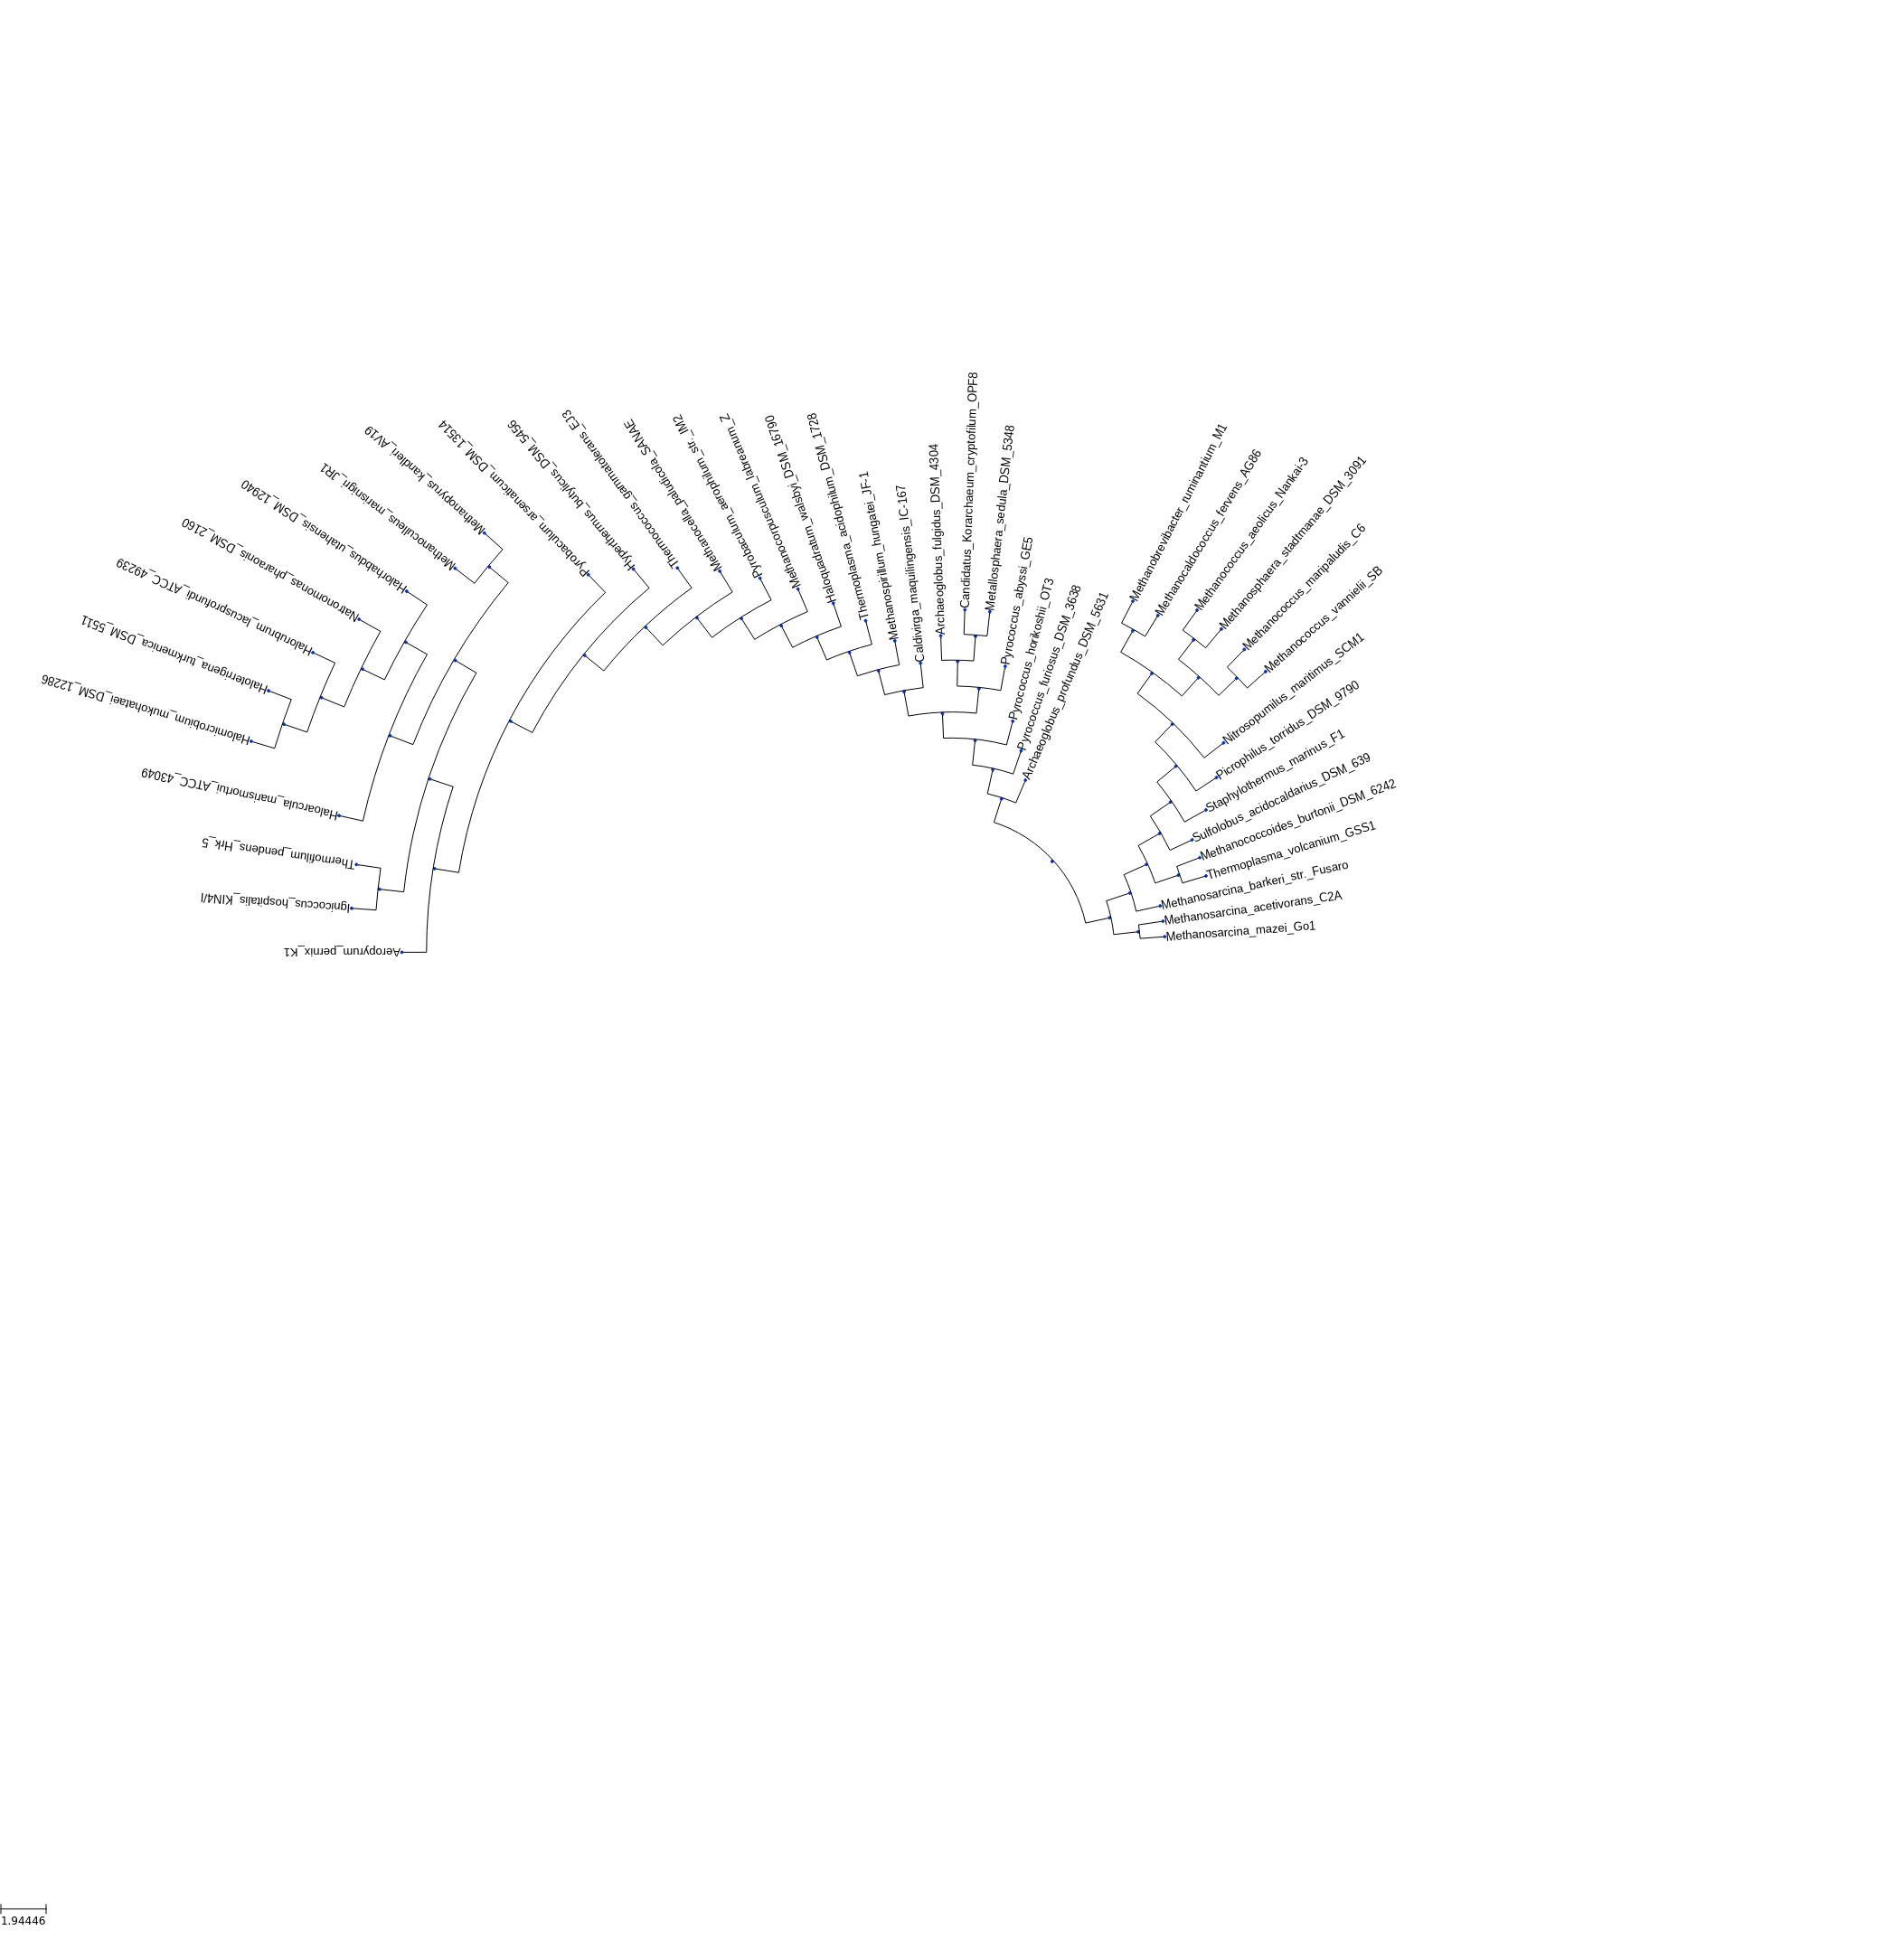

In [71]:
t = archaea_newickNJ_k2
ts = TreeStyle()
ts.show_leaf_name = True
ts.mode = "c"
ts.arc_start = -180 # 0 degrees = 3 o'clock
ts.arc_span = 180
t.render("%%inline", tree_style=ts)

On affiche l'arbre obtenu avec l'algorithme `UPGMA` de l'ensemble des archées.

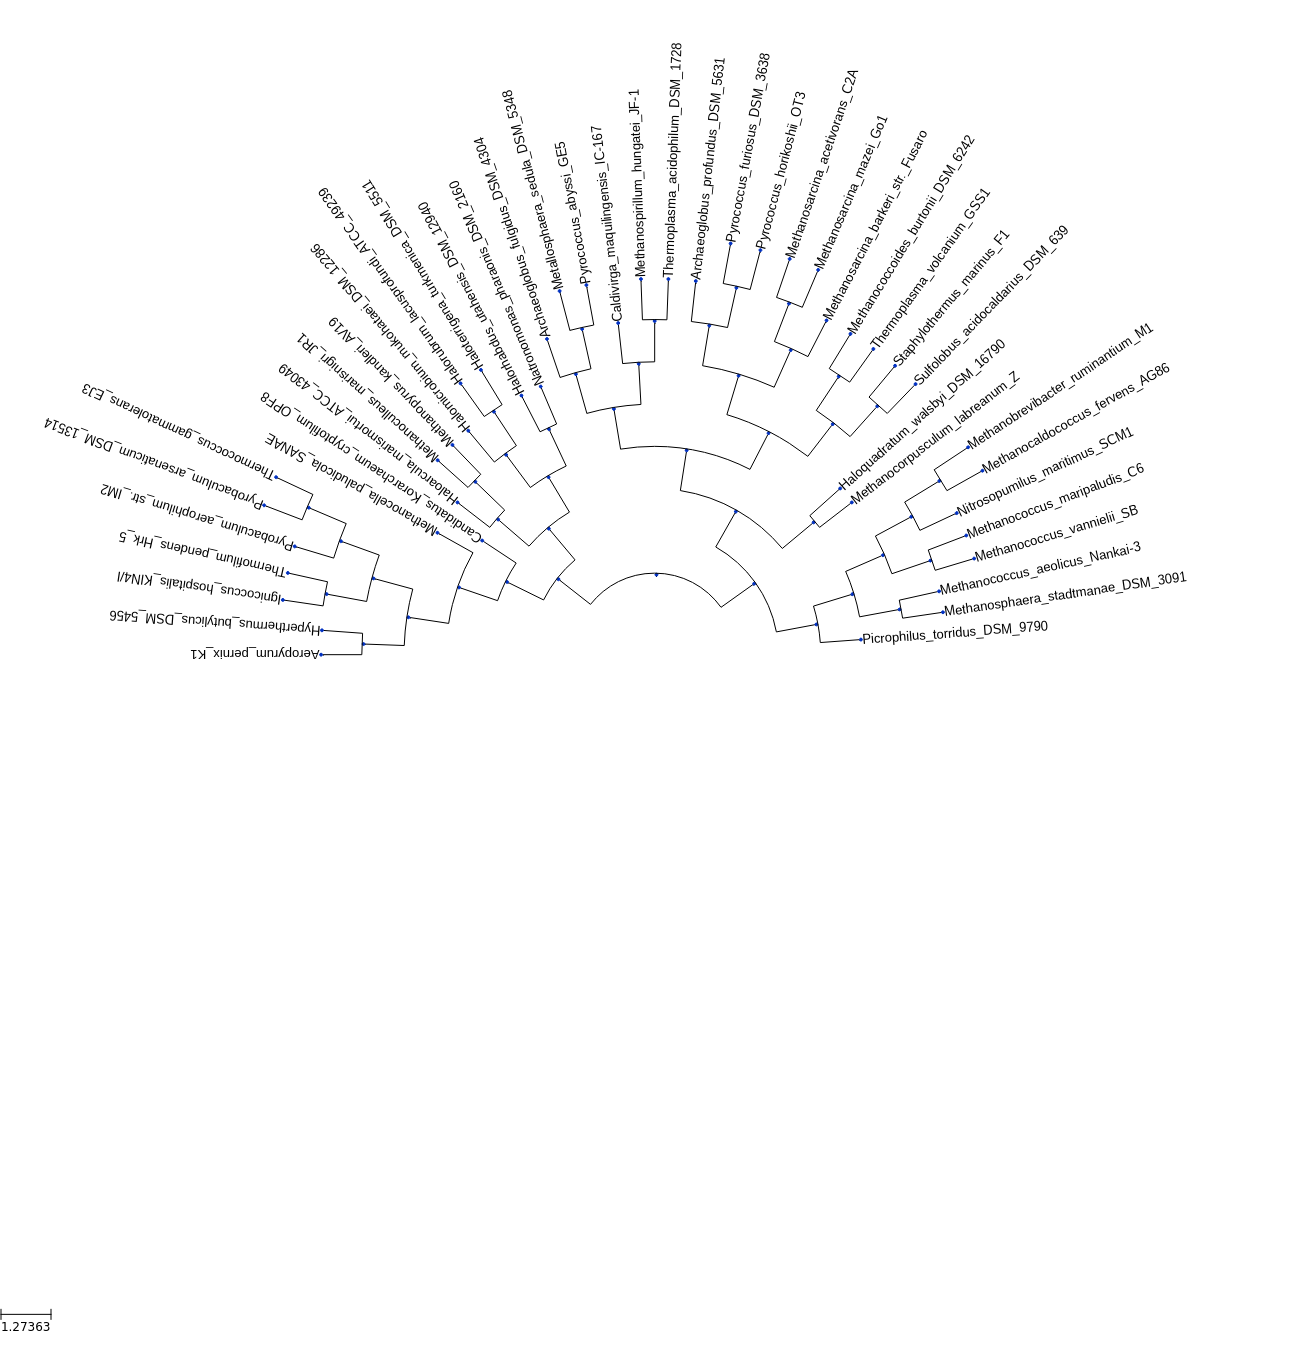

In [72]:
t = newickUPGMA_k2
ts = TreeStyle()
ts.show_leaf_name = True
ts.mode = "c"
ts.arc_start = -180 # 0 degrees = 3 o'clock
ts.arc_span = 180
t.render("%%inline", tree_style=ts)

### Etude sur l'ensemble des bactéries

On calcule la matrice de distance sur des k-mères de 2 sur l'ensemble des bactéries.

In [60]:
distMatrix_k2 = make_distance_matrix(bacteriaGenoms, 2, range(len(bacteriaGenoms)))
print(distMatrix_k2)

Making distance matrix.. : 100%|################| 98/98 [27:37<00:00, 16.91s/it]

[[0.         0.25923359 0.21772202 ... 0.3177063  0.1381828  0.37392475]
 [0.25923359 0.         0.07110654 ... 0.06472067 0.13699312 0.16694625]
 [0.21772202 0.07110654 0.         ... 0.12579308 0.10354412 0.16580774]
 ...
 [0.3177063  0.06472067 0.12579308 ... 0.         0.1950546  0.15772701]
 [0.1381828  0.13699312 0.10354412 ... 0.1950546  0.         0.25197084]
 [0.37392475 0.16694625 0.16580774 ... 0.15772701 0.25197084 0.        ]]


On récupère l'ensemble des noms des bactéries.

In [61]:
bacteriaNames = []
for bacteria in bacteriaGenoms:
    bacteriaNames.append(bacteria[0])

On calcule l'arbre des bactéries avec l'algorithme de `Neighbor-Joining`.

In [62]:
bacteria_newickNJ_k2 = Tree(neighborJoining(distMatrix_k2, bacteriaNames))



distanceMatrix size 98 and clusters
['Acholeplasma_laidlawii_PG-8A', 'Acidobacterium_capsulatum_ATCC_51196', 'Akkermansia_muciniphila_ATCC_BAA-835', 'Alicyclobacillus_acidocaldarius_subsp._acidocaldarius_DSM_446', 'Aquifex_aeolicus_VF5', 'Bacillus_cereus_Q1', 'Bacillus_pseudofirmus_OF4', 'Bacteroides_fragilis_YCH46', 'Bacteroides_fragilis_YCH46_isolate_Bacteroides_fragilis_82A12', 'Bdellovibrio_bacteriovorus_HD100', 'Bordetella_pertussis_Tohama_I', 'Bordetella_pertussis_Tohama_I_', 'Campylobacter_jejuni_subsp._jejuni_81-176', 'Campylobacter_jejuni_subsp._jejuni_81-176-UMCW7_plasmid_pVir', 'Candidatus_Amoebophilus_asiaticus_5a2', 'Carboxydothermus_hydrogenoformans_Z-2901', 'Chlamydia_trachomatis_434/Bu', 'Chlorobium_chlorochromatii_CaD3', 'Chloroflexus_aurantiacus_J-10-fl', 'Clostridium_acetobutylicum_ATCC_824', 'Corynebacterium_glutamicum_ATCC_13032', 'Coxiella_burnetii_RSA_493', 'Coxiella_burnetii_RSA_493_strain_Cb171_QLYMPHOMA', 'Cupriavidus_taiwanensis_LMG_19424', 'Cupriavidus_tai



distanceMatrix size 95 and clusters
['Acholeplasma_laidlawii_PG-8A', 'Acidobacterium_capsulatum_ATCC_51196', 'Akkermansia_muciniphila_ATCC_BAA-835', 'Alicyclobacillus_acidocaldarius_subsp._acidocaldarius_DSM_446', 'Aquifex_aeolicus_VF5', 'Bacillus_cereus_Q1', 'Bacillus_pseudofirmus_OF4', 'Bacteroides_fragilis_YCH46', 'Bacteroides_fragilis_YCH46_isolate_Bacteroides_fragilis_82A12', 'Bdellovibrio_bacteriovorus_HD100', 'Bordetella_pertussis_Tohama_I', 'Bordetella_pertussis_Tohama_I_', '((Campylobacter_jejuni_subsp._jejuni_81-176,Campylobacter_jejuni_subsp._jejuni_81-176-UMCW7_plasmid_pVir),Prochlorococcus_marinus_str._AS9601)', 'Candidatus_Amoebophilus_asiaticus_5a2', 'Carboxydothermus_hydrogenoformans_Z-2901', 'Chlamydia_trachomatis_434/Bu', 'Chlorobium_chlorochromatii_CaD3', 'Chloroflexus_aurantiacus_J-10-fl', 'Clostridium_acetobutylicum_ATCC_824', 'Corynebacterium_glutamicum_ATCC_13032', 'Coxiella_burnetii_RSA_493', 'Coxiella_burnetii_RSA_493_strain_Cb171_QLYMPHOMA', 'Cupriavidus_tai



distanceMatrix size 90 and clusters
['(((Acholeplasma_laidlawii_PG-8A,Clostridium_acetobutylicum_ATCC_824),Rickettsia_rickettsii_str._Iowa),((((Campylobacter_jejuni_subsp._jejuni_81-176,Campylobacter_jejuni_subsp._jejuni_81-176-UMCW7_plasmid_pVir),Prochlorococcus_marinus_str._AS9601),(Mycoplasma_genitalium_G37,Mycoplasma_genitalium_G37_strain_G-37_unique_20)),Flavobacterium_psychrophilum_JIP02/86))', 'Acidobacterium_capsulatum_ATCC_51196', 'Akkermansia_muciniphila_ATCC_BAA-835', 'Alicyclobacillus_acidocaldarius_subsp._acidocaldarius_DSM_446', 'Aquifex_aeolicus_VF5', 'Bacillus_cereus_Q1', 'Bacillus_pseudofirmus_OF4', 'Bacteroides_fragilis_YCH46', 'Bacteroides_fragilis_YCH46_isolate_Bacteroides_fragilis_82A12', 'Bdellovibrio_bacteriovorus_HD100', 'Bordetella_pertussis_Tohama_I', 'Bordetella_pertussis_Tohama_I_', 'Candidatus_Amoebophilus_asiaticus_5a2', 'Carboxydothermus_hydrogenoformans_Z-2901', 'Chlamydia_trachomatis_434/Bu', 'Chlorobium_chlorochromatii_CaD3', 'Chloroflexus_aurantiacu



distanceMatrix size 85 and clusters
['(((((((Acholeplasma_laidlawii_PG-8A,Clostridium_acetobutylicum_ATCC_824),Rickettsia_rickettsii_str._Iowa),((((Campylobacter_jejuni_subsp._jejuni_81-176,Campylobacter_jejuni_subsp._jejuni_81-176-UMCW7_plasmid_pVir),Prochlorococcus_marinus_str._AS9601),(Mycoplasma_genitalium_G37,Mycoplasma_genitalium_G37_strain_G-37_unique_20)),Flavobacterium_psychrophilum_JIP02/86)),(Dictyoglomus_thermophilum_H-6-12,Thermodesulfovibrio_yellowstonii_DSM_11347)),Candidatus_Amoebophilus_asiaticus_5a2),Bacillus_cereus_Q1),Leptospira_interrogans_serovar_Lai_str._56601)', 'Acidobacterium_capsulatum_ATCC_51196', 'Akkermansia_muciniphila_ATCC_BAA-835', 'Alicyclobacillus_acidocaldarius_subsp._acidocaldarius_DSM_446', 'Aquifex_aeolicus_VF5', 'Bacillus_pseudofirmus_OF4', 'Bacteroides_fragilis_YCH46', 'Bacteroides_fragilis_YCH46_isolate_Bacteroides_fragilis_82A12', 'Bdellovibrio_bacteriovorus_HD100', 'Bordetella_pertussis_Tohama_I', 'Bordetella_pertussis_Tohama_I_', 'Carboxyd



distanceMatrix size 83 and clusters
['((((((((Acholeplasma_laidlawii_PG-8A,Clostridium_acetobutylicum_ATCC_824),Rickettsia_rickettsii_str._Iowa),((((Campylobacter_jejuni_subsp._jejuni_81-176,Campylobacter_jejuni_subsp._jejuni_81-176-UMCW7_plasmid_pVir),Prochlorococcus_marinus_str._AS9601),(Mycoplasma_genitalium_G37,Mycoplasma_genitalium_G37_strain_G-37_unique_20)),Flavobacterium_psychrophilum_JIP02/86)),(Dictyoglomus_thermophilum_H-6-12,Thermodesulfovibrio_yellowstonii_DSM_11347)),Candidatus_Amoebophilus_asiaticus_5a2),Bacillus_cereus_Q1),Leptospira_interrogans_serovar_Lai_str._56601),Elusimicrobium_minutum_Pei191)', 'Acidobacterium_capsulatum_ATCC_51196', 'Akkermansia_muciniphila_ATCC_BAA-835', 'Alicyclobacillus_acidocaldarius_subsp._acidocaldarius_DSM_446', 'Aquifex_aeolicus_VF5', '(Bacillus_pseudofirmus_OF4,Nostoc_punctiforme_PCC_73102)', 'Bacteroides_fragilis_YCH46', 'Bacteroides_fragilis_YCH46_isolate_Bacteroides_fragilis_82A12', 'Bdellovibrio_bacteriovorus_HD100', 'Bordetella_p



distanceMatrix size 79 and clusters
['(((((((((Acholeplasma_laidlawii_PG-8A,Clostridium_acetobutylicum_ATCC_824),Rickettsia_rickettsii_str._Iowa),((((Campylobacter_jejuni_subsp._jejuni_81-176,Campylobacter_jejuni_subsp._jejuni_81-176-UMCW7_plasmid_pVir),Prochlorococcus_marinus_str._AS9601),(Mycoplasma_genitalium_G37,Mycoplasma_genitalium_G37_strain_G-37_unique_20)),Flavobacterium_psychrophilum_JIP02/86)),(Dictyoglomus_thermophilum_H-6-12,Thermodesulfovibrio_yellowstonii_DSM_11347)),Candidatus_Amoebophilus_asiaticus_5a2),Bacillus_cereus_Q1),Leptospira_interrogans_serovar_Lai_str._56601),Elusimicrobium_minutum_Pei191),Carboxydothermus_hydrogenoformans_Z-2901)', 'Acidobacterium_capsulatum_ATCC_51196', 'Akkermansia_muciniphila_ATCC_BAA-835', 'Alicyclobacillus_acidocaldarius_subsp._acidocaldarius_DSM_446', 'Aquifex_aeolicus_VF5', '((Bacillus_pseudofirmus_OF4,Nostoc_punctiforme_PCC_73102),Chlamydia_trachomatis_434/Bu)', 'Bacteroides_fragilis_YCH46', 'Bacteroides_fragilis_YCH46_isolate_Bact



distanceMatrix size 77 and clusters
['((((((((((Acholeplasma_laidlawii_PG-8A,Clostridium_acetobutylicum_ATCC_824),Rickettsia_rickettsii_str._Iowa),((((Campylobacter_jejuni_subsp._jejuni_81-176,Campylobacter_jejuni_subsp._jejuni_81-176-UMCW7_plasmid_pVir),Prochlorococcus_marinus_str._AS9601),(Mycoplasma_genitalium_G37,Mycoplasma_genitalium_G37_strain_G-37_unique_20)),Flavobacterium_psychrophilum_JIP02/86)),(Dictyoglomus_thermophilum_H-6-12,Thermodesulfovibrio_yellowstonii_DSM_11347)),Candidatus_Amoebophilus_asiaticus_5a2),Bacillus_cereus_Q1),Leptospira_interrogans_serovar_Lai_str._56601),Elusimicrobium_minutum_Pei191),Carboxydothermus_hydrogenoformans_Z-2901),(Coxiella_burnetii_RSA_493,Coxiella_burnetii_RSA_493_strain_Cb171_QLYMPHOMA))', 'Acidobacterium_capsulatum_ATCC_51196', 'Akkermansia_muciniphila_ATCC_BAA-835', 'Alicyclobacillus_acidocaldarius_subsp._acidocaldarius_DSM_446', 'Aquifex_aeolicus_VF5', '(((Bacillus_pseudofirmus_OF4,Nostoc_punctiforme_PCC_73102),Chlamydia_trachomatis_

qMatrix size 74
[[  0.          -8.72258575 -14.41567521 ...  -3.20835857 -23.76690197
   -6.80722928]
 [ -8.72258575   0.          -9.62682978 ...  -6.09120345  -9.13431102
   -6.47472371]
 [-14.41567521  -9.62682978   0.         ...  -4.41947217 -14.26812024
   -9.28217857]
 ...
 [ -3.20835857  -6.09120345  -4.41947217 ...   0.          -3.68395785
   -5.86858276]
 [-23.76690197  -9.13431102 -14.26812024 ...  -3.68395785   0.
   -7.32975008]
 [ -6.80722928  -6.47472371  -9.28217857 ...  -5.86858276  -7.32975008
    0.        ]]


distanceMatrix size 73 and clusters
['((((((((((((Acholeplasma_laidlawii_PG-8A,Clostridium_acetobutylicum_ATCC_824),Rickettsia_rickettsii_str._Iowa),((((Campylobacter_jejuni_subsp._jejuni_81-176,Campylobacter_jejuni_subsp._jejuni_81-176-UMCW7_plasmid_pVir),Prochlorococcus_marinus_str._AS9601),(Mycoplasma_genitalium_G37,Mycoplasma_genitalium_G37_strain_G-37_unique_20)),Flavobacterium_psychrophilum_JIP02/86)),(Dictyoglomus_thermophilum_H-6-12,Thermodesulfovibr



distanceMatrix size 70 and clusters
['(((((((((((((Acholeplasma_laidlawii_PG-8A,Clostridium_acetobutylicum_ATCC_824),Rickettsia_rickettsii_str._Iowa),((((Campylobacter_jejuni_subsp._jejuni_81-176,Campylobacter_jejuni_subsp._jejuni_81-176-UMCW7_plasmid_pVir),Prochlorococcus_marinus_str._AS9601),(Mycoplasma_genitalium_G37,Mycoplasma_genitalium_G37_strain_G-37_unique_20)),Flavobacterium_psychrophilum_JIP02/86)),(Dictyoglomus_thermophilum_H-6-12,Thermodesulfovibrio_yellowstonii_DSM_11347)),Candidatus_Amoebophilus_asiaticus_5a2),Bacillus_cereus_Q1),Leptospira_interrogans_serovar_Lai_str._56601),Elusimicrobium_minutum_Pei191),Carboxydothermus_hydrogenoformans_Z-2901),(Coxiella_burnetii_RSA_493,Coxiella_burnetii_RSA_493_strain_Cb171_QLYMPHOMA)),(((Bacillus_pseudofirmus_OF4,Nostoc_punctiforme_PCC_73102),Chlamydia_trachomatis_434/Bu),(Pedobacter_heparinus_DSM_2366,Pedobacter_heparinus_DSM_2366_ctg7180000000005_quiver))),Chlorobium_chlorochromatii_CaD3),((Bacteroides_fragilis_YCH46,Bacteroides



distanceMatrix size 66 and clusters
['(((((((((((((((((Acholeplasma_laidlawii_PG-8A,Clostridium_acetobutylicum_ATCC_824),Rickettsia_rickettsii_str._Iowa),((((Campylobacter_jejuni_subsp._jejuni_81-176,Campylobacter_jejuni_subsp._jejuni_81-176-UMCW7_plasmid_pVir),Prochlorococcus_marinus_str._AS9601),(Mycoplasma_genitalium_G37,Mycoplasma_genitalium_G37_strain_G-37_unique_20)),Flavobacterium_psychrophilum_JIP02/86)),(Dictyoglomus_thermophilum_H-6-12,Thermodesulfovibrio_yellowstonii_DSM_11347)),Candidatus_Amoebophilus_asiaticus_5a2),Bacillus_cereus_Q1),Leptospira_interrogans_serovar_Lai_str._56601),Elusimicrobium_minutum_Pei191),Carboxydothermus_hydrogenoformans_Z-2901),(Coxiella_burnetii_RSA_493,Coxiella_burnetii_RSA_493_strain_Cb171_QLYMPHOMA)),(((Bacillus_pseudofirmus_OF4,Nostoc_punctiforme_PCC_73102),Chlamydia_trachomatis_434/Bu),(Pedobacter_heparinus_DSM_2366,Pedobacter_heparinus_DSM_2366_ctg7180000000005_quiver))),Chlorobium_chlorochromatii_CaD3),((Bacteroides_fragilis_YCH46,Bactero

qMatrix size 63
[[  0.          -8.28727236 -12.2474583  ...  -6.38115193 -13.22058113
   -2.73299058]
 [ -8.28727236   0.          -7.62733313 ...  -4.55092735  -8.03951254
   -3.08252597]
 [-12.2474583   -7.62733313   0.         ...  -7.85955507 -11.76198109
   -2.43593316]
 ...
 [ -6.38115193  -4.55092735  -7.85955507 ...   0.          -8.49674286
   -2.75464688]
 [-13.22058113  -8.03951254 -11.76198109 ...  -8.49674286   0.
   -3.04041757]
 [ -2.73299058  -3.08252597  -2.43593316 ...  -2.75464688  -3.04041757
    0.        ]]


distanceMatrix size 62 and clusters
['((((((((((((((((((((Acholeplasma_laidlawii_PG-8A,Clostridium_acetobutylicum_ATCC_824),Rickettsia_rickettsii_str._Iowa),((((Campylobacter_jejuni_subsp._jejuni_81-176,Campylobacter_jejuni_subsp._jejuni_81-176-UMCW7_plasmid_pVir),Prochlorococcus_marinus_str._AS9601),(Mycoplasma_genitalium_G37,Mycoplasma_genitalium_G37_strain_G-37_unique_20)),Flavobacterium_psychrophilum_JIP02/86)),(Dictyoglomus_thermophilum_H-6-12,Thermodes

qMatrix size 55
[[ 0.         -4.27639478 -0.7872308  ... -2.76948334 -3.48427882
  -2.26588601]
 [-4.27639478  0.         -0.79731251 ... -2.07491858 -1.8991183
  -2.26402154]
 [-0.7872308  -0.79731251  0.         ... -1.58335949 -1.51714662
  -0.89894348]
 ...
 [-2.76948334 -2.07491858 -1.58335949 ...  0.         -4.32503321
  -1.39196142]
 [-3.48427882 -1.8991183  -1.51714662 ... -4.32503321  0.
  -1.83403861]
 [-2.26588601 -2.26402154 -0.89894348 ... -1.39196142 -1.83403861
   0.        ]]


distanceMatrix size 54 and clusters
['((((((((((((((((((((((((((Acholeplasma_laidlawii_PG-8A,Clostridium_acetobutylicum_ATCC_824),Rickettsia_rickettsii_str._Iowa),((((Campylobacter_jejuni_subsp._jejuni_81-176,Campylobacter_jejuni_subsp._jejuni_81-176-UMCW7_plasmid_pVir),Prochlorococcus_marinus_str._AS9601),(Mycoplasma_genitalium_G37,Mycoplasma_genitalium_G37_strain_G-37_unique_20)),Flavobacterium_psychrophilum_JIP02/86)),(Dictyoglomus_thermophilum_H-6-12,Thermodesulfovibrio_yellowstonii_DSM_113

qMatrix size 40
[[ 0.         -0.16500953 -0.09839753 ... -0.05001682 -0.10712171
  -0.07013214]
 [-0.16500953  0.         -0.07095126 ... -0.12226744 -0.05580994
  -0.08870284]
 [-0.09839753 -0.07095126  0.         ... -0.0631612  -0.09275863
  -0.06513498]
 ...
 [-0.05001682 -0.12226744 -0.0631612  ...  0.         -0.06202306
  -0.09337783]
 [-0.10712171 -0.05580994 -0.09275863 ... -0.06202306  0.
  -0.09678955]
 [-0.07013214 -0.08870284 -0.06513498 ... -0.09337783 -0.09678955
   0.        ]]


distanceMatrix size 39 and clusters
['((((((((((((((((((((((((((((((((Acholeplasma_laidlawii_PG-8A,Clostridium_acetobutylicum_ATCC_824),Rickettsia_rickettsii_str._Iowa),((((Campylobacter_jejuni_subsp._jejuni_81-176,Campylobacter_jejuni_subsp._jejuni_81-176-UMCW7_plasmid_pVir),Prochlorococcus_marinus_str._AS9601),(Mycoplasma_genitalium_G37,Mycoplasma_genitalium_G37_strain_G-37_unique_20)),Flavobacterium_psychrophilum_JIP02/86)),(Dictyoglomus_thermophilum_H-6-12,Thermodesulfovibrio_yellowstonii_

qMatrix size 36
[[ 0.         -0.07901136 -0.10555123 ... -0.03835425 -0.10270353
  -0.05686051]
 [-0.07901136  0.         -0.057581   ... -0.09576691 -0.04288799
  -0.06751238]
 [-0.10555123 -0.057581    0.         ... -0.04706479 -0.08012975
  -0.05060776]
 ...
 [-0.03835425 -0.09576691 -0.04706479 ...  0.         -0.04490095
  -0.06814911]
 [-0.10270353 -0.04288799 -0.08012975 ... -0.04490095  0.
  -0.07778475]
 [-0.05686051 -0.06751238 -0.05060776 ... -0.06814911 -0.07778475
   0.        ]]


distanceMatrix size 35 and clusters
['((((((((((((((((((((((((((((((((((Acholeplasma_laidlawii_PG-8A,Clostridium_acetobutylicum_ATCC_824),Rickettsia_rickettsii_str._Iowa),((((Campylobacter_jejuni_subsp._jejuni_81-176,Campylobacter_jejuni_subsp._jejuni_81-176-UMCW7_plasmid_pVir),Prochlorococcus_marinus_str._AS9601),(Mycoplasma_genitalium_G37,Mycoplasma_genitalium_G37_strain_G-37_unique_20)),Flavobacterium_psychrophilum_JIP02/86)),(Dictyoglomus_thermophilum_H-6-12,Thermodesulfovibrio_yellowstoni

qMatrix size 20
[[ 0.         -0.01654618 -0.03338415 -0.02607385 -0.01515197 -0.02106932
  -0.02380311 -0.02360479 -0.02235724 -0.0201309  -0.01371218 -0.02356391
  -0.02232353 -0.01841689 -0.01732208 -0.01899489 -0.0179501  -0.02687436
  -0.02487226 -0.01386048]
 [-0.01654618  0.         -0.01755078 -0.03438596 -0.0267244  -0.02031575
  -0.01250025 -0.01263243 -0.02754821 -0.03012578 -0.03120564 -0.02353529
  -0.02426065 -0.01617939 -0.01782298 -0.01567024 -0.01687578 -0.0141883
  -0.01243113 -0.02951308]
 [-0.03338415 -0.01755078  0.         -0.0344093  -0.01125738 -0.02274841
  -0.01895816 -0.01890381 -0.02535514 -0.02687353 -0.01219007 -0.03333361
  -0.03619873 -0.01427853 -0.01355738 -0.01467129 -0.01414489 -0.01806072
  -0.02134958 -0.01278672]
 [-0.02607385 -0.03438596 -0.0344093   0.         -0.01623379 -0.01864953
  -0.01730324 -0.01780427 -0.02095263 -0.02539287 -0.01879137 -0.02438414
  -0.03020654 -0.01561217 -0.01598845 -0.0157072  -0.01596438 -0.01503973
  -0.01776787 -0



distanceMatrix size 14 and clusters
['((((((((((((((((((((((((((((((((((((((((Acholeplasma_laidlawii_PG-8A,Clostridium_acetobutylicum_ATCC_824),Rickettsia_rickettsii_str._Iowa),((((Campylobacter_jejuni_subsp._jejuni_81-176,Campylobacter_jejuni_subsp._jejuni_81-176-UMCW7_plasmid_pVir),Prochlorococcus_marinus_str._AS9601),(Mycoplasma_genitalium_G37,Mycoplasma_genitalium_G37_strain_G-37_unique_20)),Flavobacterium_psychrophilum_JIP02/86)),(Dictyoglomus_thermophilum_H-6-12,Thermodesulfovibrio_yellowstonii_DSM_11347)),Candidatus_Amoebophilus_asiaticus_5a2),Bacillus_cereus_Q1),Leptospira_interrogans_serovar_Lai_str._56601),Elusimicrobium_minutum_Pei191),Carboxydothermus_hydrogenoformans_Z-2901),(Coxiella_burnetii_RSA_493,Coxiella_burnetii_RSA_493_strain_Cb171_QLYMPHOMA)),(((Bacillus_pseudofirmus_OF4,Nostoc_punctiforme_PCC_73102),Chlamydia_trachomatis_434/Bu),(Pedobacter_heparinus_DSM_2366,Pedobacter_heparinus_DSM_2366_ctg7180000000005_quiver))),Chlorobium_chlorochromatii_CaD3),((Bacteroides

On calcule l'arbre des bactéries avec l'algorithme de `UPGMA`.

In [63]:
bacteria_newickUPGMA_k2 = Tree(upgma(distMatrix_k2, bacteriaNames))



distanceMatrix size 98 and clusters
['Acholeplasma_laidlawii_PG-8A', 'Acidobacterium_capsulatum_ATCC_51196', 'Akkermansia_muciniphila_ATCC_BAA-835', 'Alicyclobacillus_acidocaldarius_subsp._acidocaldarius_DSM_446', 'Aquifex_aeolicus_VF5', 'Bacillus_cereus_Q1', 'Bacillus_pseudofirmus_OF4', 'Bacteroides_fragilis_YCH46', 'Bacteroides_fragilis_YCH46_isolate_Bacteroides_fragilis_82A12', 'Bdellovibrio_bacteriovorus_HD100', 'Bordetella_pertussis_Tohama_I', 'Bordetella_pertussis_Tohama_I_', 'Campylobacter_jejuni_subsp._jejuni_81-176', 'Campylobacter_jejuni_subsp._jejuni_81-176-UMCW7_plasmid_pVir', 'Candidatus_Amoebophilus_asiaticus_5a2', 'Carboxydothermus_hydrogenoformans_Z-2901', 'Chlamydia_trachomatis_434/Bu', 'Chlorobium_chlorochromatii_CaD3', 'Chloroflexus_aurantiacus_J-10-fl', 'Clostridium_acetobutylicum_ATCC_824', 'Corynebacterium_glutamicum_ATCC_13032', 'Coxiella_burnetii_RSA_493', 'Coxiella_burnetii_RSA_493_strain_Cb171_QLYMPHOMA', 'Cupriavidus_taiwanensis_LMG_19424', 'Cupriavidus_tai

On affiche l'arbre obtenu avec l'algorithme `Neighbor-Joining` de l'ensemble des bactéries.

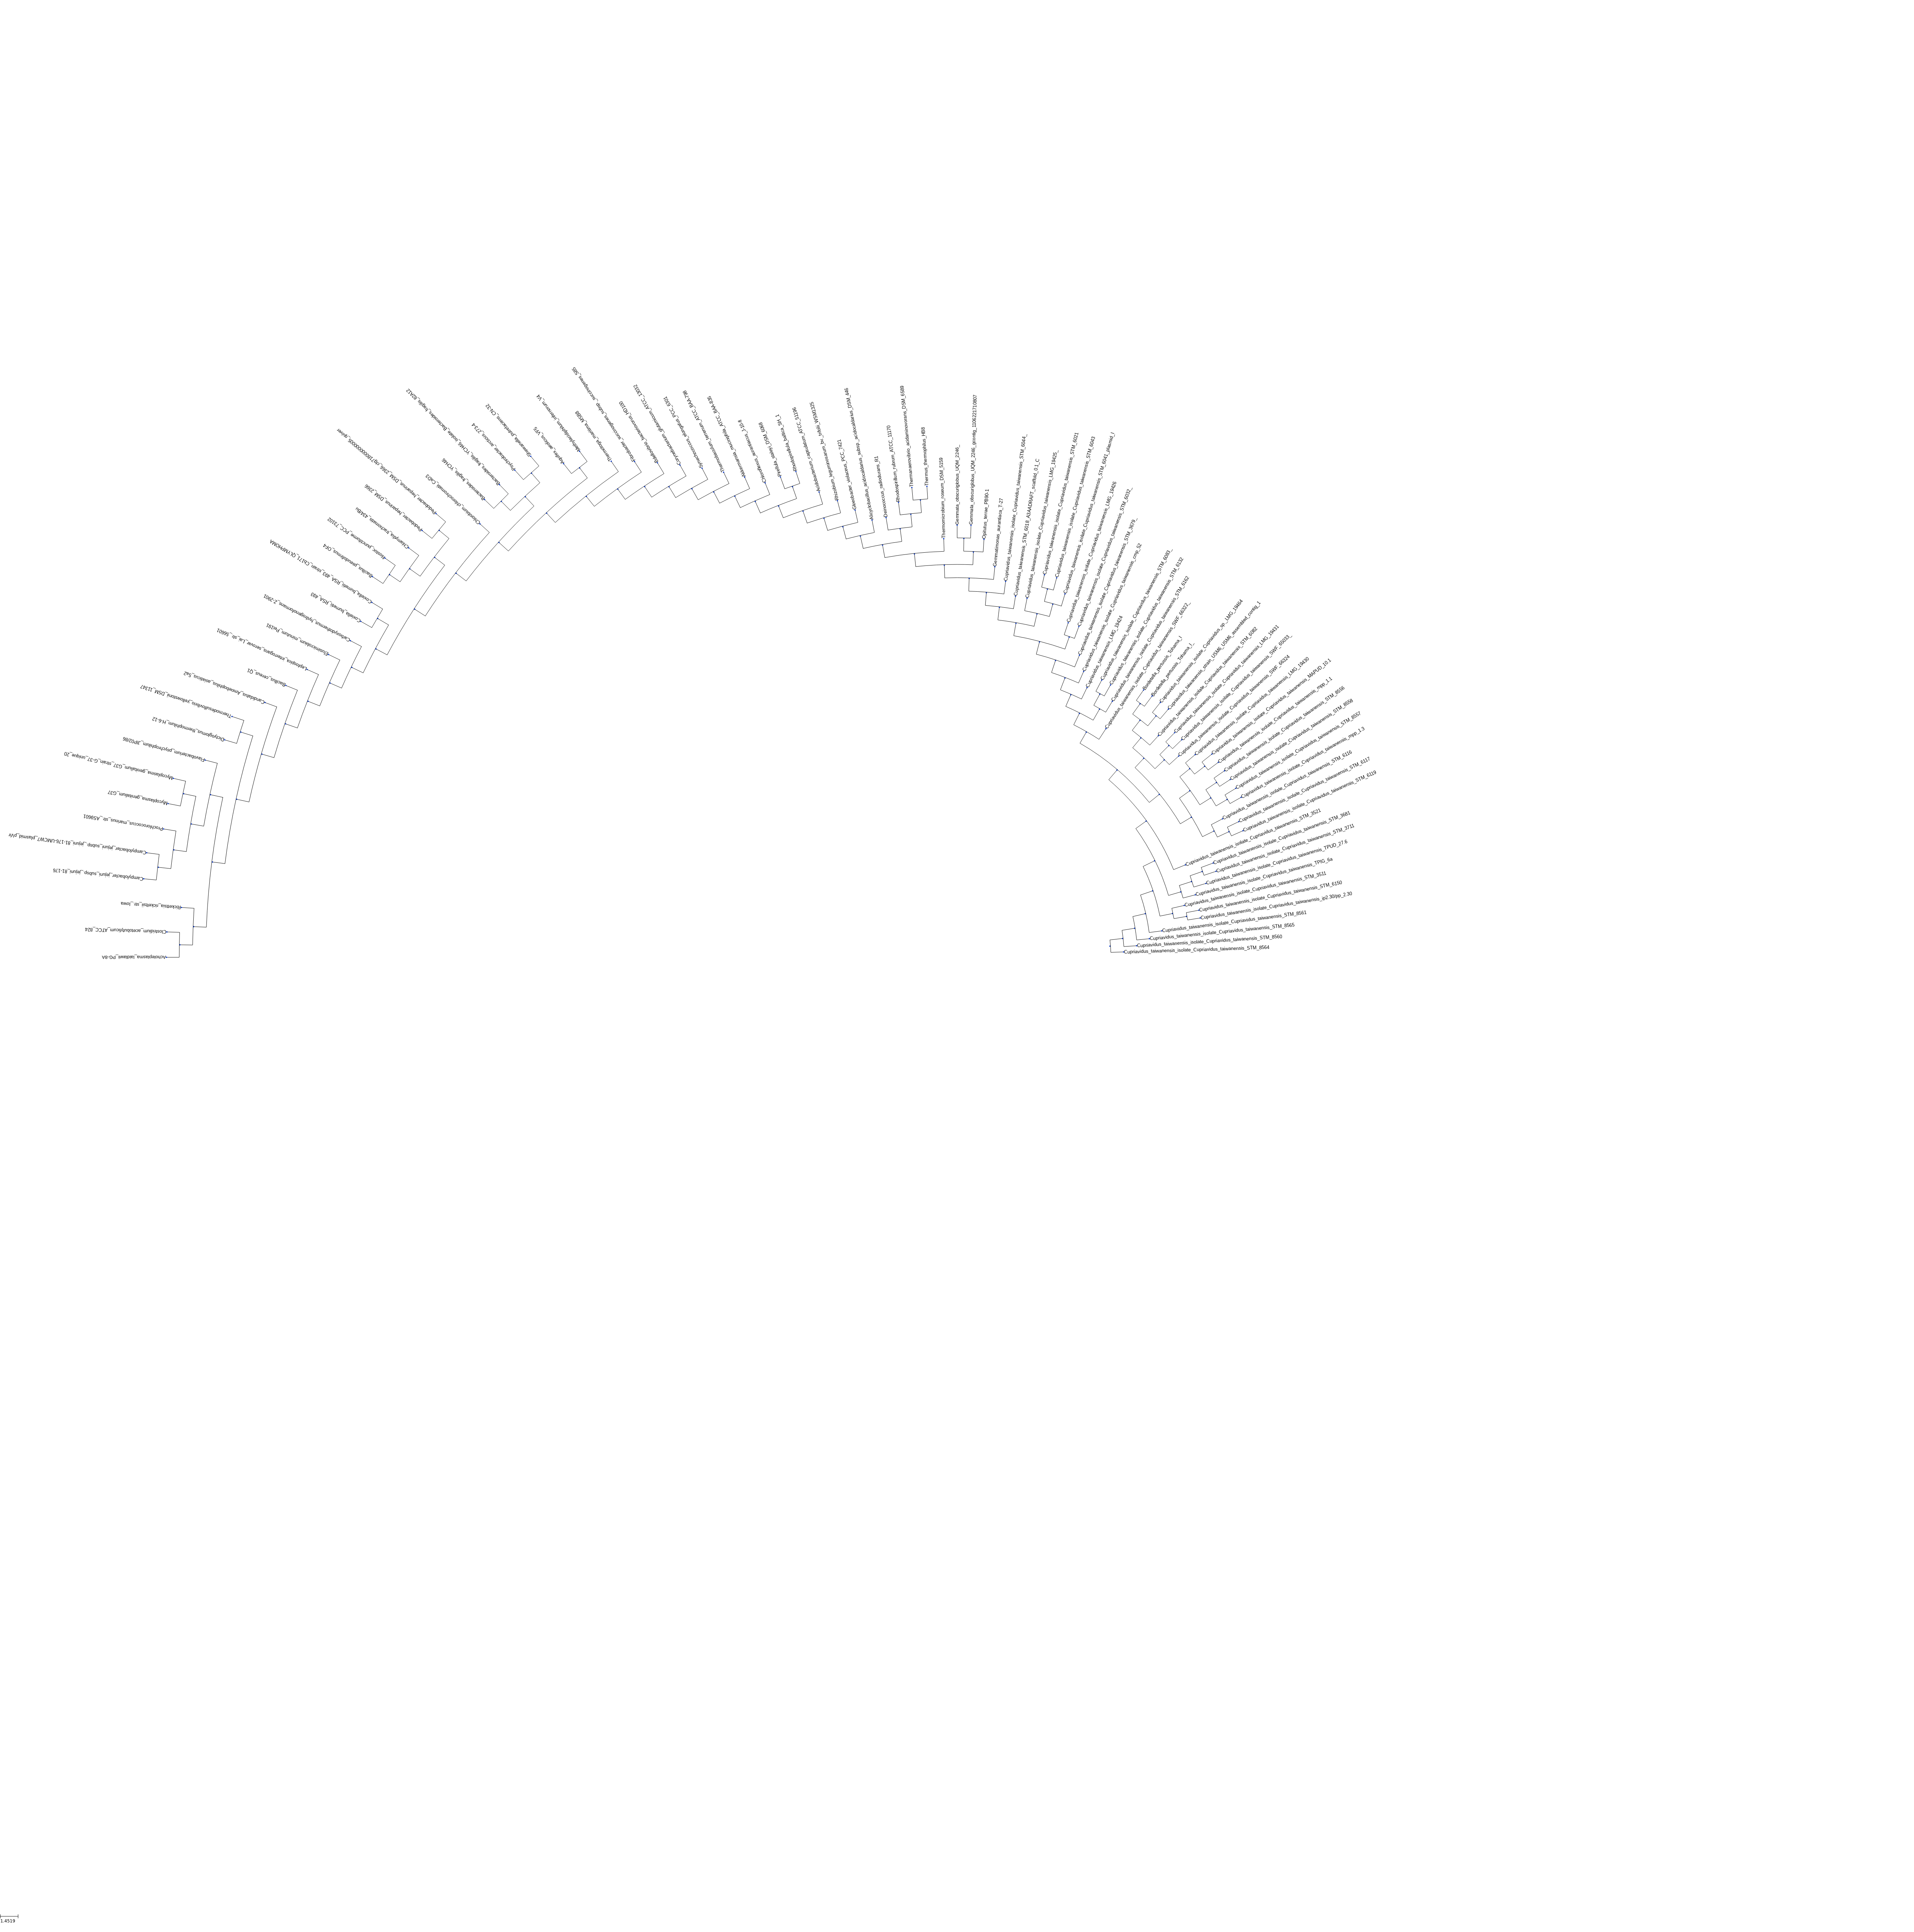

In [73]:
t = bacteria_newickNJ_k2
ts = TreeStyle()
ts.show_leaf_name = True
ts.mode = "c"
ts.arc_start = -180 # 0 degrees = 3 o'clock
ts.arc_span = 180
t.render("%%inline", tree_style=ts)

On affiche l'arbre obtenu avec l'algorithme `UPGMA` de l'ensemble des bactéries.

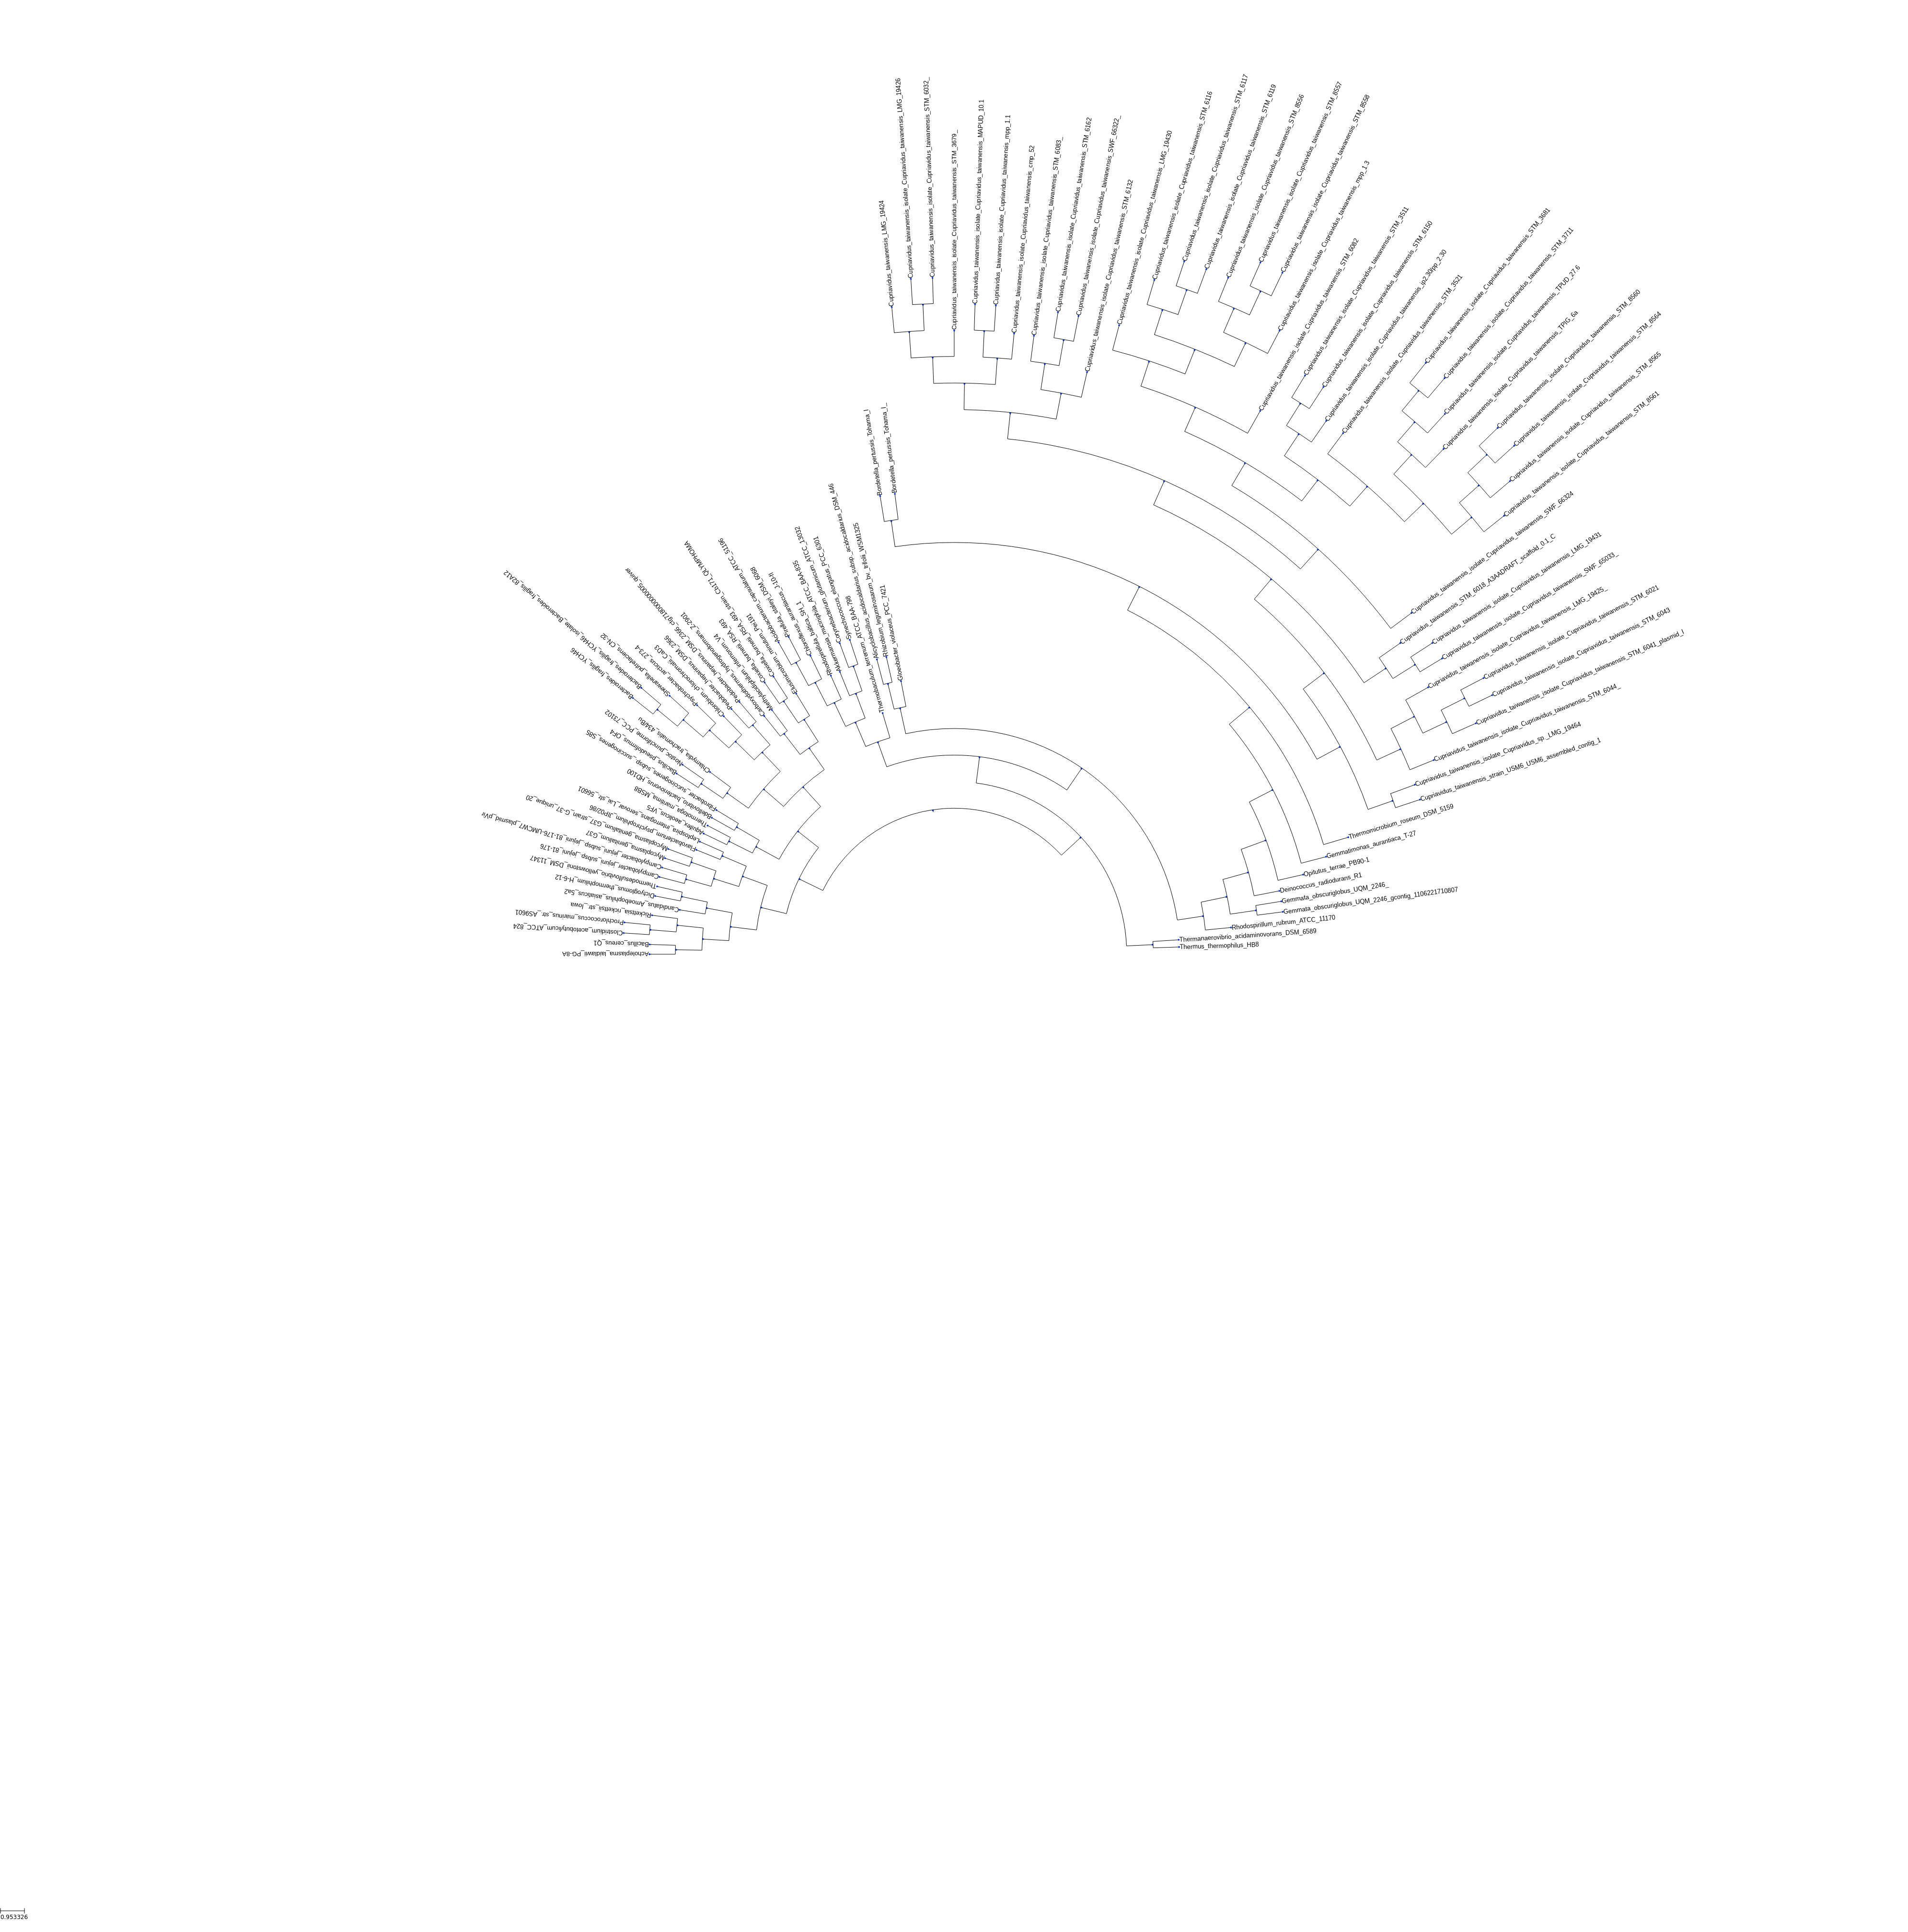

In [74]:
t = bacteria_newickUPGMA_k2
ts = TreeStyle()
ts.show_leaf_name = True
ts.mode = "c"
ts.arc_start = -180 # 0 degrees = 3 o'clock
ts.arc_span = 180
t.render("%%inline", tree_style=ts)

Counting k-mers.. : 100%|#########| 1667163/1667163 [00:06<00:00, 252565.63it/s]


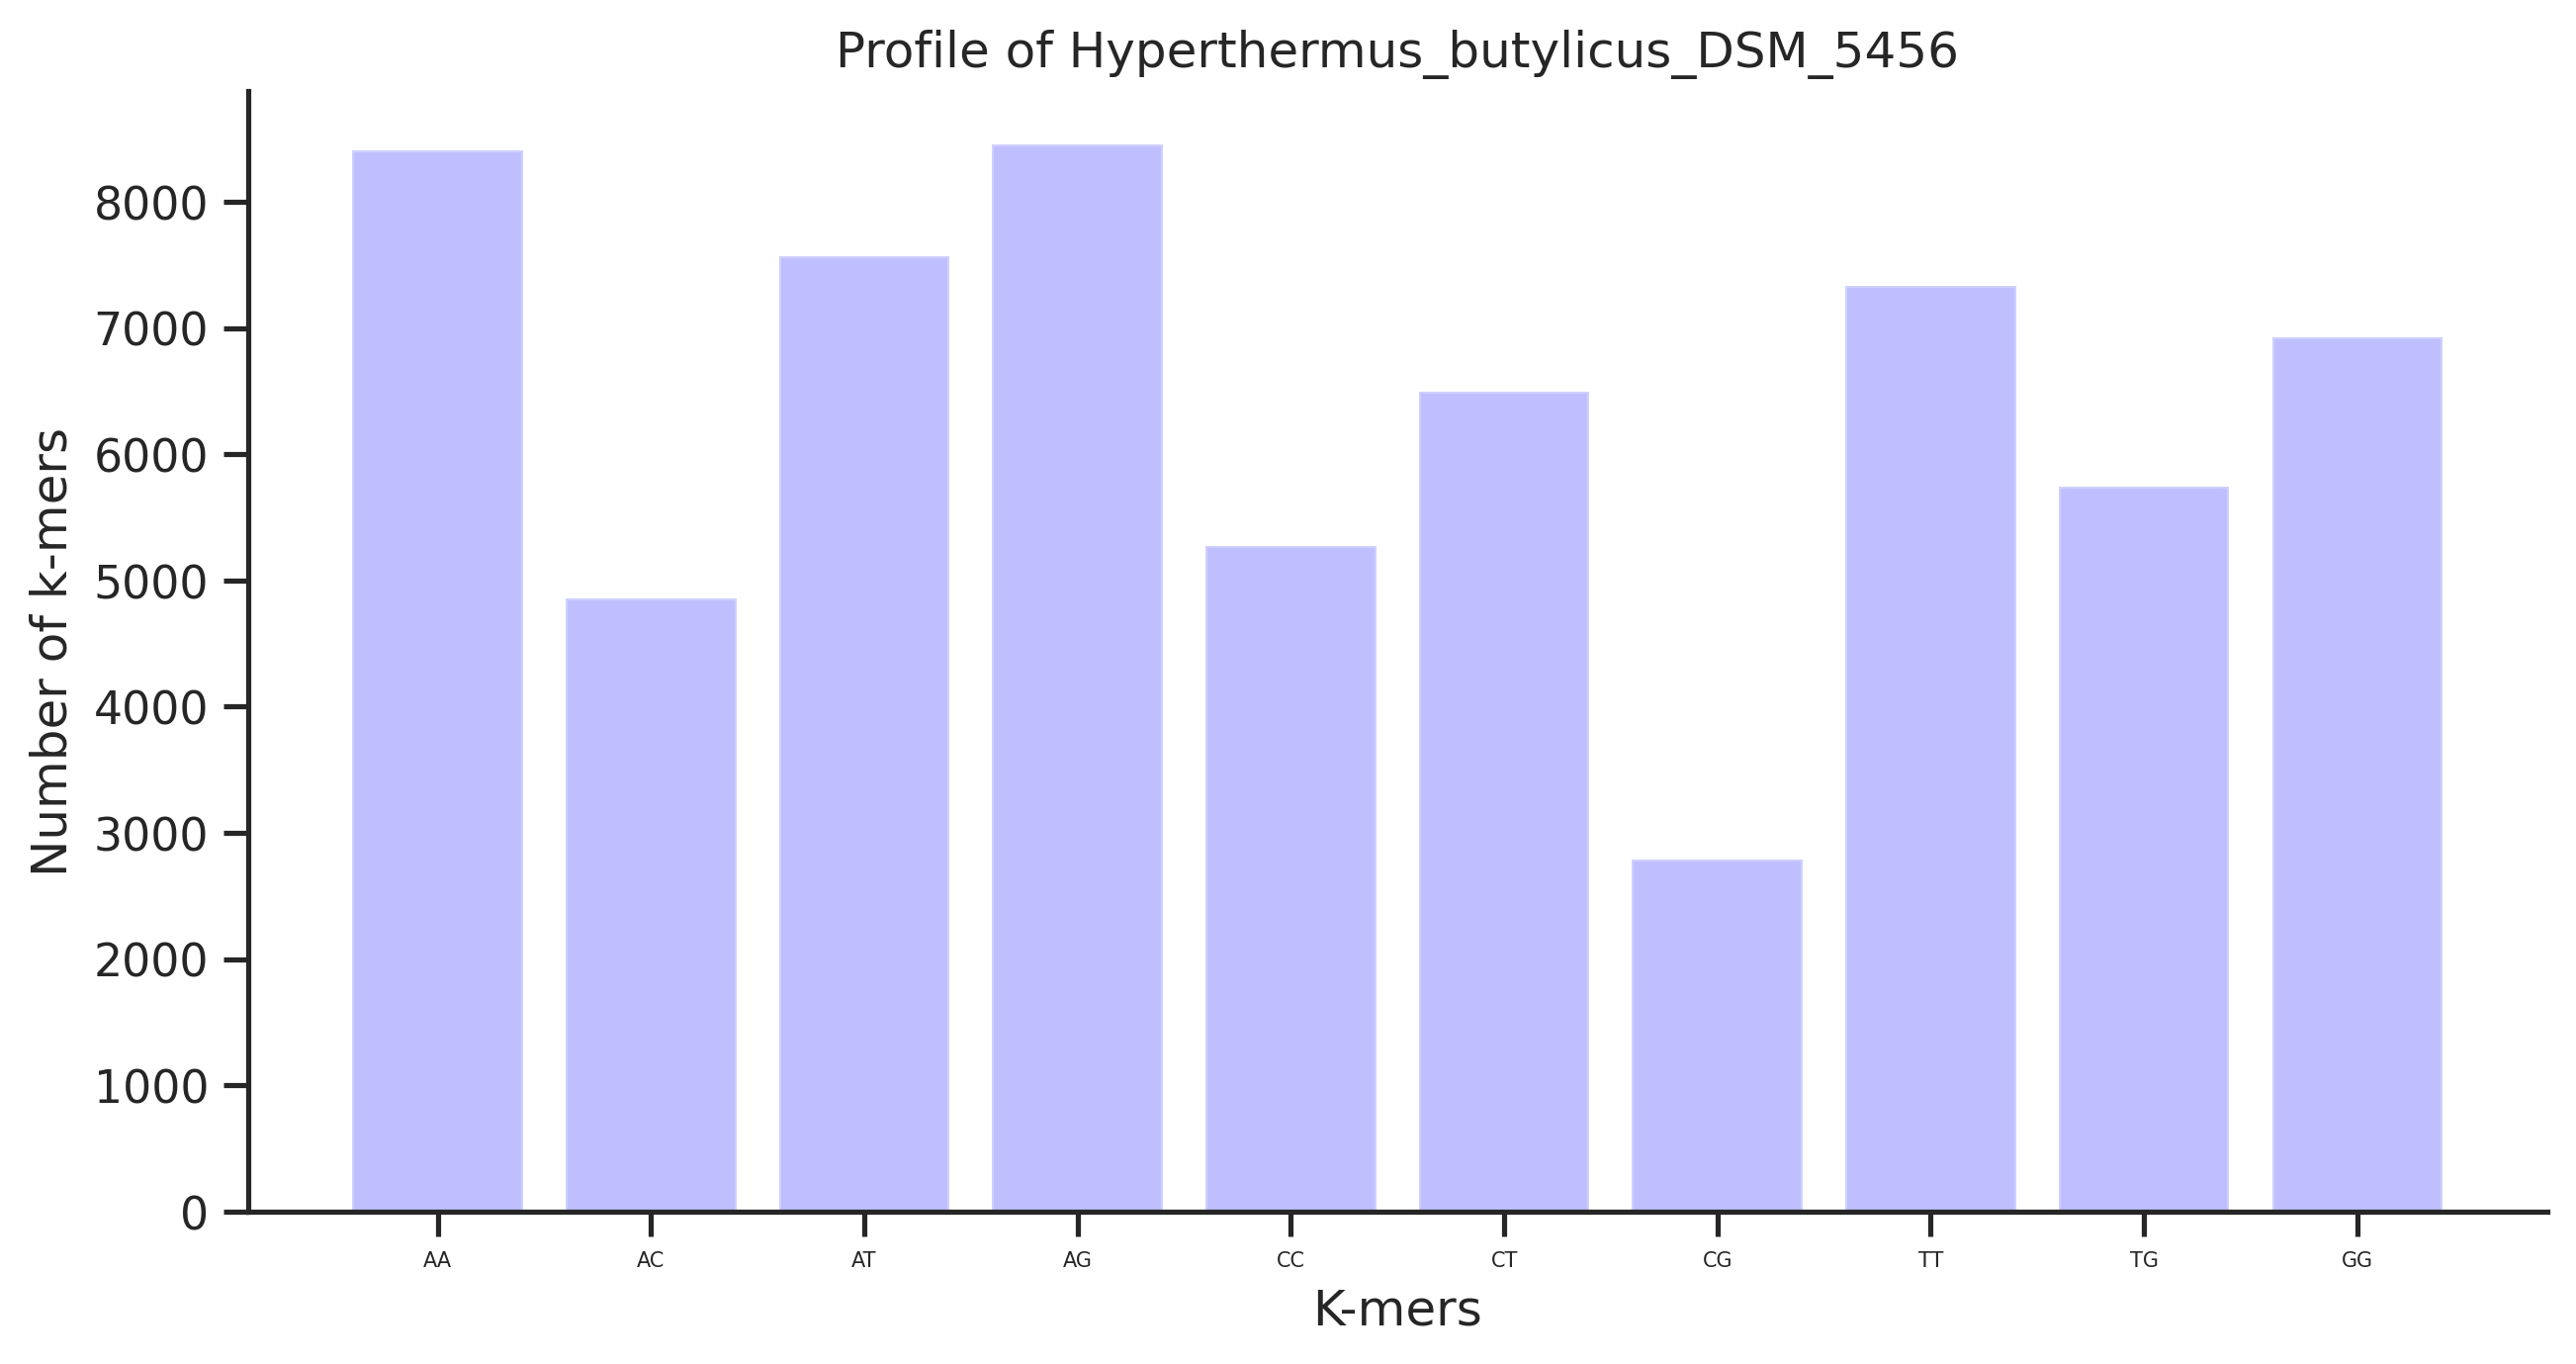

Counting k-mers.. : 100%|#########| 3101661/3101661 [00:12<00:00, 249277.20it/s]


<Figure size 432x288 with 0 Axes>

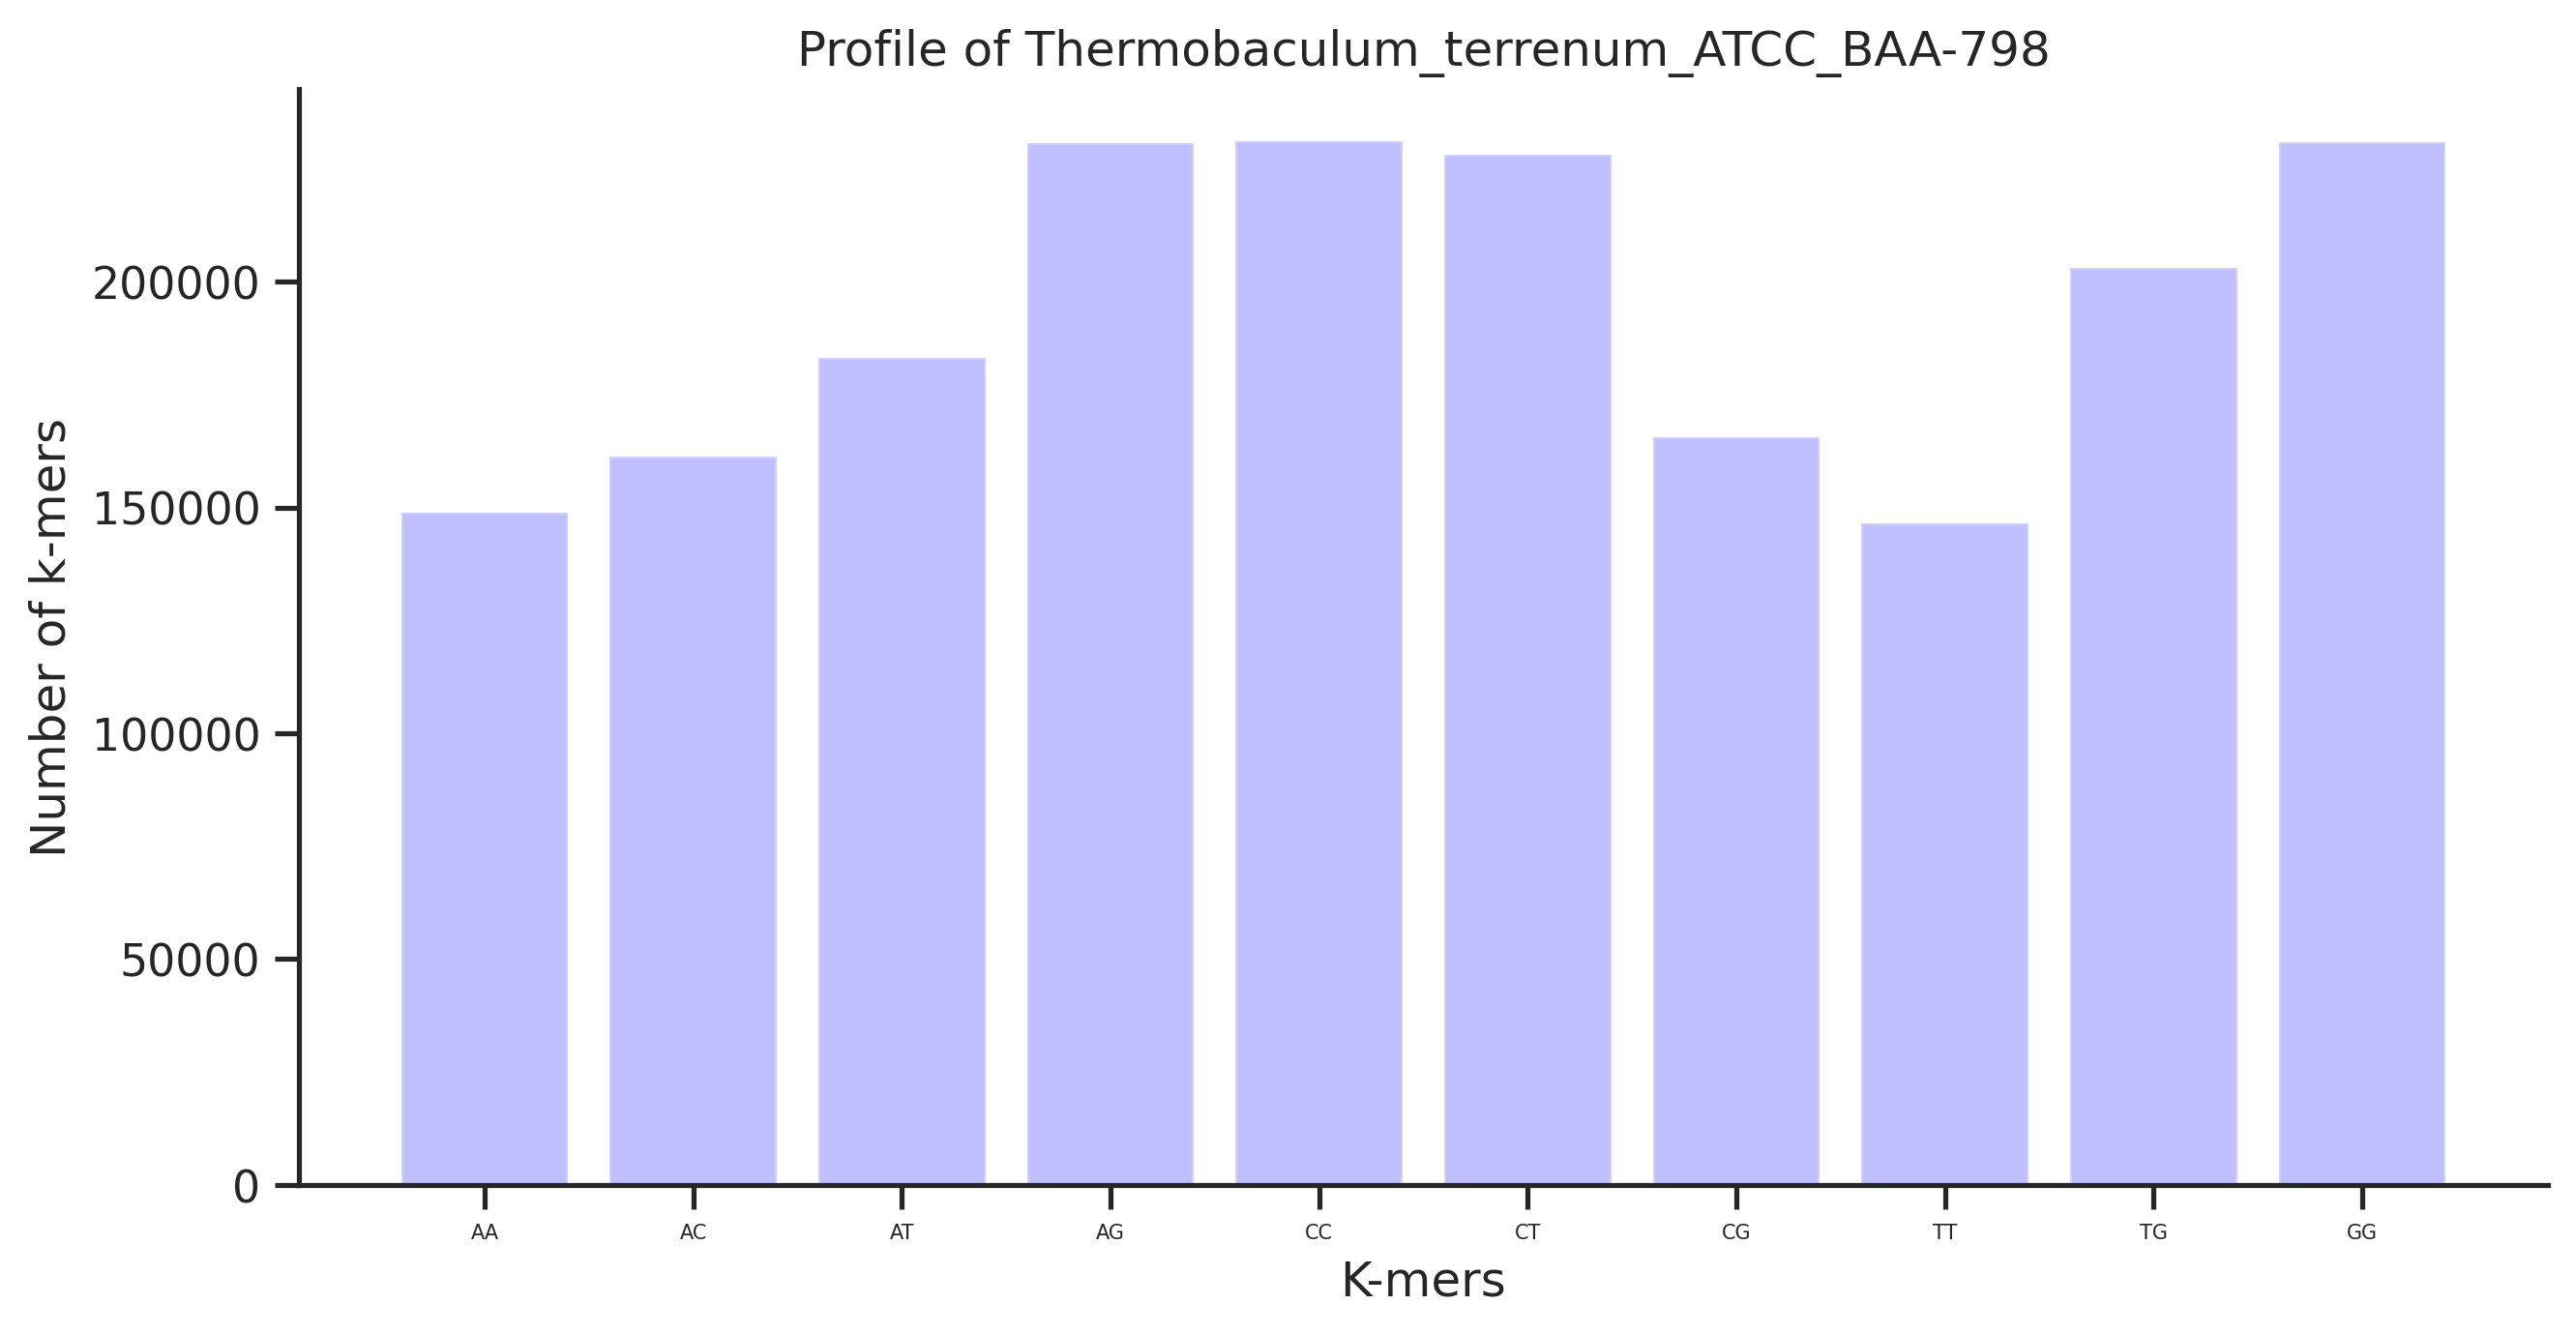

<Figure size 432x288 with 0 Axes>

In [27]:
labels, scores = kmers_count(archaeaGenoms[11][1])
profile_plot(labels, 
             score_locus, 
             "Profile of "+archaeaGenoms[11][0], 
             "K-mers", 
             "Number of k-mers")
labels, scores = kmers_count(bacteriaGenoms[93][1])
profile_plot(labels, 
             scores, 
             "Profile of "+bacteriaGenoms[93][0], 
             "K-mers", 
             "Number of k-mers")

Sweeping k-mers.. : 100%|#######################| 16/16 [00:05<00:00,  2.71it/s]


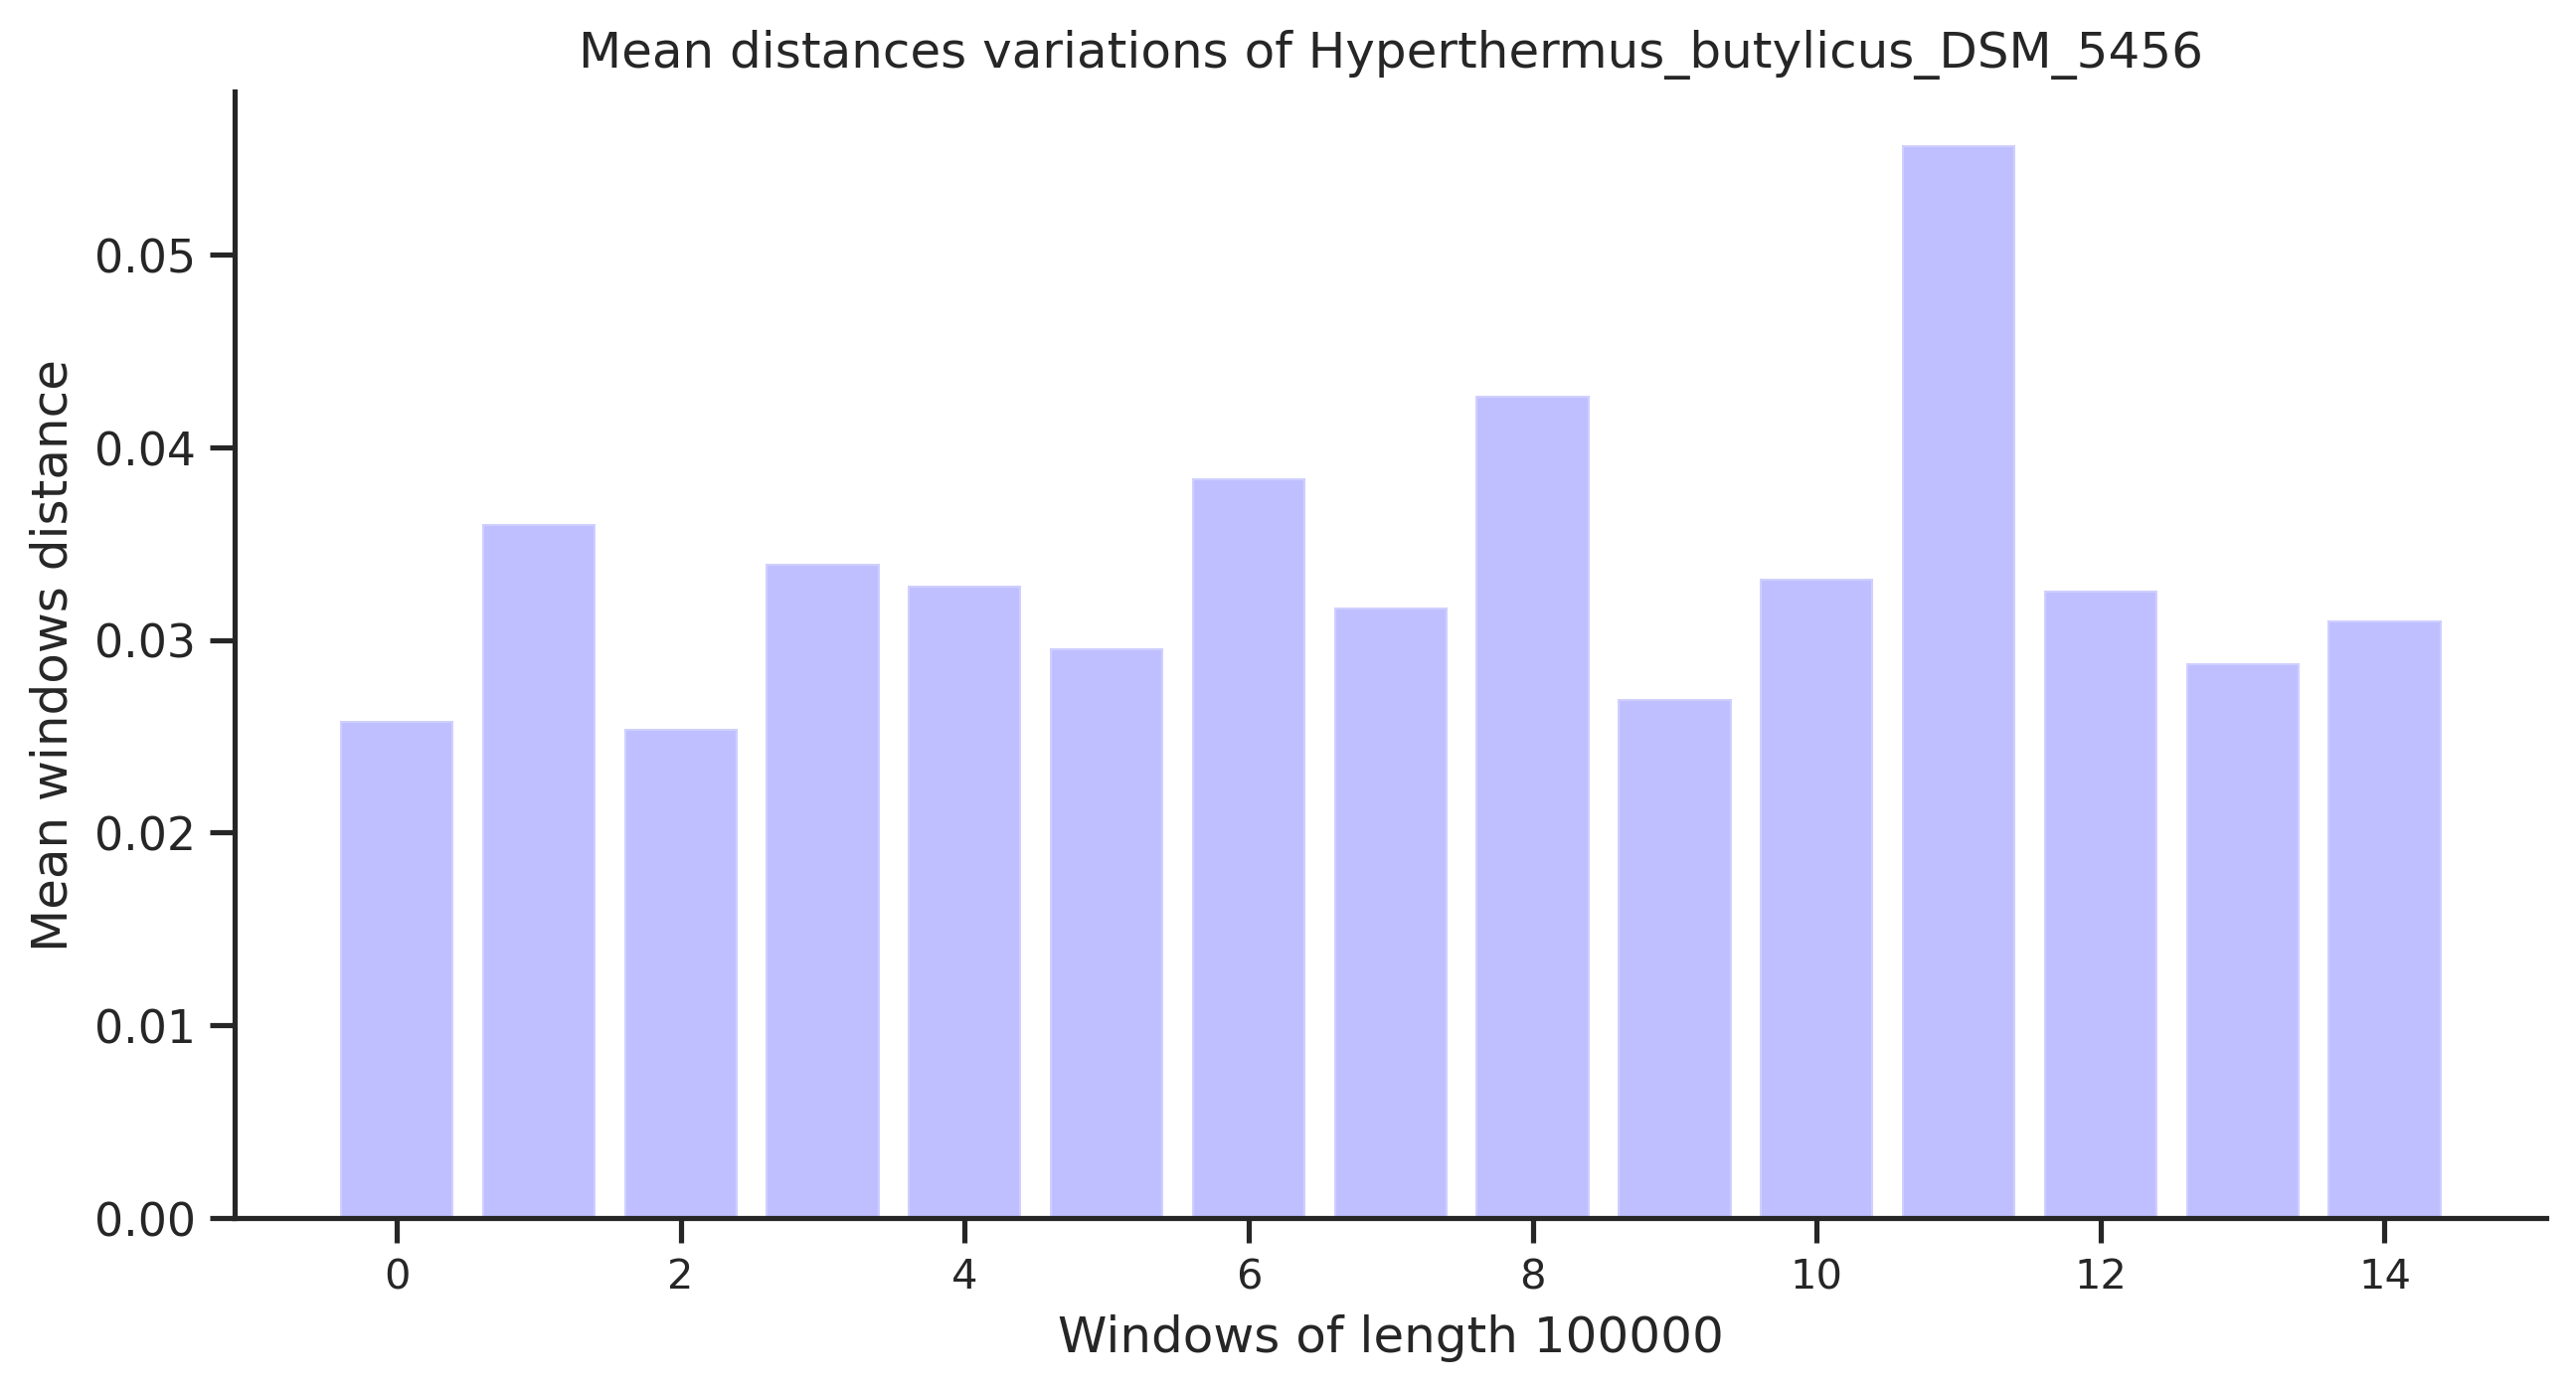

<Figure size 432x288 with 0 Axes>

In [28]:
labels, scores = kmers_sweep(archaeaGenoms[11])
distance_plot(range(len(distance_mean(scores))), 
        distance_mean(scores), 
        "Mean distances variations of "+archaeaGenoms[11][0], 
        "Windows of length 100000", 
        "Mean windows distance", 
        10)